NOTA: Los comentarios estadísticos a este notebook pueden estar desactualizados por alguna actualización en los datos. Se confía en el sentido común del lector para la interpretación de los datos según los valores concretos de las tablas y gráficos que se proporcionan a lo largo de él. 

# Importar librerías

In [1]:
import sys
sys.path.append("../..") 
import sql_utils
import json
import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import f_oneway
import os 
import plotly.express as px
from IPython.display import IFrame
from pytz import timezone

# Cambiar opciones del notebook

In [2]:
# Aumentar el número de columnas que se pueden visualizar
pd.set_option('display.max_columns', 70)

# DataFrame descriptivo ubicaciones balizas

El siguiente DataFrame es para hacer luego un análisis sobre hasta qué punto la distancia al wifi influye en ditintas características como, por ejemplo, la pérdida de datos.

In [3]:
beacons_description = pd.DataFrame(
{
    "device" : ["DBEM003","DBEM004","DBEM006", "DBEM007", "WIFI"],
    "ubicacion" : ["oficina-almacen","entrada-parking","calderas","pasillo", "entrada-parking"],
    "distance_wifi_meters":[3,0,7.5,2.7,np.nan],
    "rate_send_segs": [10,10,60,60,np.nan]
}
) 
beacons_description

device        ubicacion  distance_wifi_meters  rate_send_segs
0  DBEM003  oficina-almacen                   3.0            10.0
1  DBEM004  entrada-parking                   0.0            10.0
2  DBEM006         calderas                   7.5            60.0
3  DBEM007          pasillo                   2.7            60.0
4     WIFI  entrada-parking                   NaN             NaN

## Plano balizas

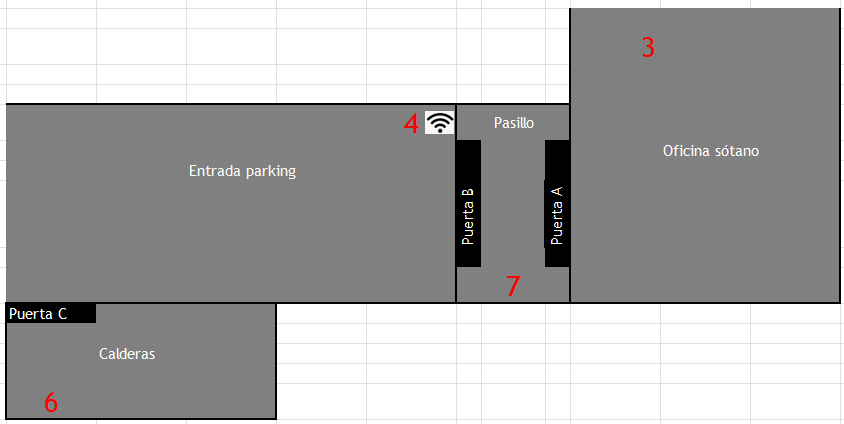

In [4]:
from IPython.display import display
from PIL import Image

imagen = Image.open("plano-pruebas-parque-bomberos-9.png")
display(imagen)

# Funciones 

## Función para guardar los htmls

Para que se puedan ver los gráficos dinámicos en html incrustados en el notebook he creado esta función

In [5]:
def save_plotly_figure(fig, file_name, path_save="", save=True): 
    """
    Guarda un gráfico html. Se tiene que pasar obligatoriamente tanto el objeto
    a guardar (está pensado para que sea un plotly) como un nombre para el gráfico.
    Se puede pasar opcionalmente un directorio donde guardar el html. Si no se pasa
    nada se guarda en el directorio actual de ejecución
    """
    if save:
        if not path_save:
            path_save = os.getcwd()  # Obtiene el directorio actual
        os.makedirs(path_save, exist_ok=True)
        file_path = f"{path_save}/{file_name}.html"
        fig.write_html(file_path)
        print(f"Saved {file_path}")
    else:
        print("save = False")

## Función para hacer resúmenes estadísticos

La siguiente función es para personalizar más los resumenes estadísticos y reutilizar código.

In [6]:
def summary_statistics(df,variables = None, groupby=None):
    """
    La siguiente función genera un resumen estadístico de los datos. Recibe el argumento variables que es .
    
    Inputs:
    - df: DataFrame a partir del cuál hacer el resumen estadístico
    - variables: Nombre de la variable en formato string o de las columnas en formato lista tales que se quiere hacer
    el análisis estadístico
    - grouby:Nombre de la variable en formato string o de las columnas en formato lista tales que tienen categorías. 
    El resumen se hará separando por categorías
    
    - Comentarios:
        Si no se pasa ninguna variable en el argumento se hace el resumen sobre todas las columnas del DataFrame
    
    - Desarrollos futuros:
        - Dejar automatizado la función que se quiera resumir como argumentos 
    """
    df = df.copy()
    
    if groupby is None:
        df["group"] ="all"
        groupby = "group"
    else: 
        if isinstance(variables,str):
            variables = [variables]
    
    if variables is None:
        variables = list(set(df.columns)-set(groupby))
    else: 
        if isinstance(variables,str):
            variables = [variables]
        list(set(variables)-set(groupby))
    
    dfs_summary = []
    
    for variable in variables:
        df_summary = df.groupby(groupby)\
        .agg(
            count=(variable, 'count'),
            Q1=(variable, lambda x: x.quantile(0.25)),
            Q3=(variable, lambda x: x.quantile(0.75)),
            percentil_90=(variable, lambda x: x.quantile(0.9)),
            percentil_99=(variable, lambda x: x.quantile(0.99)),
            median=(variable, 'median'),
            mean=(variable, 'mean'),
            std=(variable, 'std'),
            min=(variable, 'min'),
            max=(variable, 'max')
        ).reset_index()
        df_summary["variable_summary"] = variable
        dfs_summary.append(df_summary)
    
    df = pd.concat(dfs_summary)
    
    return df

# Importación de datos

In [7]:
# si automatic_importation es True, entonces los datos se toman directamente de la bbdd 
# si automatic_importation es False, entonces los datos se toman de local para reducir el tiempo de ejecución
# automatic_importation = False solo es posible si se ha ejecutado previamente el scirpt y se han guardado los datos en local


automatic_importation = False

if automatic_importation:
    
    database = "test_guide2fr_parquebomberos9"
    
    query = "SELECT * FROM data"
    print(query)

    creds_path = '../../creds/sql.json' 

    with open(creds_path, 'r') as json_file:
        creds_sql = json.load(json_file)

    df_imported = sql_utils.get_data_ssh(query, database=database, **creds_sql)
    
else:
    # Path donde se guardan los instantes de los datos 
    path_instants_save_data = "../../data/instants-save-data"
    # Listo todos los datos que hay guardados y los ordeno para obtener el último. Como van a estar identificados los nombres
    # en formato "%Y-%m-%d_%H-%M-%S" el último va a ser el más reciente
    dfs_saved = sorted(os.listdir(path_instants_save_data))
    last_df = dfs_saved[-1]
    print(f"importing {last_df} ...")
    df_imported = pd.read_csv(f"{path_instants_save_data}/{last_df}")
df = df_imported.copy()

SELECT * FROM data


In [8]:
# Para reducir el tiempo de ejecución en alguna ejecución posterior y para tener una imagen de los datos para un cierto 
# instante de tiempo por si cambia inesperadamente alguna característica
save_importation = True 
path_instants_save_data = "../../data/instants-save-data"
if save_importation and automatic_importation:
    name = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    df_imported.to_csv(f"{path_instants_save_data}/{name}.csv",index=False)
# df_imported = pd.read_csv(f"{path_instants_save_data}/2023-05-11_13-15-35.csv")

In [9]:
df = df_imported.copy()
df.rename(columns = {"id_device":"id_beacon"},inplace=True)
df

id_data id_beacon id_sensor id_variable           timestamp   value   
0              1   DBEM003      sWEA     00-temp 2023-04-18 17:00:00  2391.0  \
1              2   DBEM003      sWEA     00-temp 2023-04-18 17:00:10  2391.0   
2              3   DBEM003      sWEA     00-temp 2023-04-18 17:00:20  2391.0   
3              4   DBEM003      sWEA     00-temp 2023-04-18 17:00:30  2390.0   
4              5   DBEM003      sWEA     00-temp 2023-04-18 17:00:40  2391.0   
...          ...       ...       ...         ...                 ...     ...   
3558095  3558096   DBEM007      sWEA     00-temp 2023-05-11 13:25:00  2289.0   
3558096  3558097   DBEM007      sWEA     00-temp 2023-05-11 14:10:00  2279.0   
3558097  3558098   DBEM007      sWEA     00-temp 2023-05-11 14:40:00  2293.0   
3558098  3558099   DBEM007      sWEA     00-temp 2023-05-11 15:49:00  2291.0   
3558099  3558100   DBEM007      sWEA     00-temp 2023-05-11 17:58:00  2281.0   

                     unit  id_location  
0        unidad inventada            3  
1        unidad inventada            3  
2        unidad inventada            3  
3        unidad inventada            3  
4        unidad inventada            3  
...                   ...          ...  
3558095  unidad inventada            7  
3558096  unidad inventada            7  
3558097  unidad inventada            7  
3558098  unidad inventada            7  
3558099  unidad inventada            7  

[3558100 rows x 8 columns]

# Convertir la columna de tiempo a objeto de python adecuado

In [10]:
df["timestamp"] = pd.to_datetime(df["timestamp"],utc=True)
df['timestamp'] = df['timestamp'].dt.tz_convert(timezone('Europe/Madrid'))
df.dtypes

id_data                                int64
id_beacon                             object
id_sensor                             object
id_variable                           object
timestamp      datetime64[ns, Europe/Madrid]
value                                float64
unit                                  object
id_location                            int64
dtype: object

In [11]:
df

id_data id_beacon id_sensor id_variable                 timestamp   
0              1   DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  \
1              2   DBEM003      sWEA     00-temp 2023-04-18 19:00:10+02:00   
2              3   DBEM003      sWEA     00-temp 2023-04-18 19:00:20+02:00   
3              4   DBEM003      sWEA     00-temp 2023-04-18 19:00:30+02:00   
4              5   DBEM003      sWEA     00-temp 2023-04-18 19:00:40+02:00   
...          ...       ...       ...         ...                       ...   
3558095  3558096   DBEM007      sWEA     00-temp 2023-05-11 15:25:00+02:00   
3558096  3558097   DBEM007      sWEA     00-temp 2023-05-11 16:10:00+02:00   
3558097  3558098   DBEM007      sWEA     00-temp 2023-05-11 16:40:00+02:00   
3558098  3558099   DBEM007      sWEA     00-temp 2023-05-11 17:49:00+02:00   
3558099  3558100   DBEM007      sWEA     00-temp 2023-05-11 19:58:00+02:00   

          value              unit  id_location  
0        2391.0  unidad inventada            3  
1        2391.0  unidad inventada            3  
2        2391.0  unidad inventada            3  
3        2390.0  unidad inventada            3  
4        2391.0  unidad inventada            3  
...         ...               ...          ...  
3558095  2289.0  unidad inventada            7  
3558096  2279.0  unidad inventada            7  
3558097  2293.0  unidad inventada            7  
3558098  2291.0  unidad inventada            7  
3558099  2281.0  unidad inventada            7  

[3558100 rows x 8 columns]

# Drop id_data column

In [12]:
df.drop(columns="id_data", inplace=True)
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA     00-temp 2023-04-18 19:00:10+02:00  2391.0   
2         DBEM003      sWEA     00-temp 2023-04-18 19:00:20+02:00  2391.0   
3         DBEM003      sWEA     00-temp 2023-04-18 19:00:30+02:00  2390.0   
4         DBEM003      sWEA     00-temp 2023-04-18 19:00:40+02:00  2391.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM007      sWEA     00-temp 2023-05-11 15:25:00+02:00  2289.0   
3558096   DBEM007      sWEA     00-temp 2023-05-11 16:10:00+02:00  2279.0   
3558097   DBEM007      sWEA     00-temp 2023-05-11 16:40:00+02:00  2293.0   
3558098   DBEM007      sWEA     00-temp 2023-05-11 17:49:00+02:00  2291.0   
3558099   DBEM007      sWEA     00-temp 2023-05-11 19:58:00+02:00  2281.0   

                     unit  id_location  
0        unidad inventada            3  
1        unidad inventada            3  
2        unidad inventada            3  
3        unidad inventada            3  
4        unidad inventada            3  
...                   ...          ...  
3558095  unidad inventada            7  
3558096  unidad inventada            7  
3558097  unidad inventada            7  
3558098  unidad inventada            7  
3558099  unidad inventada            7  

[3558100 rows x 7 columns]

# Check duplicates

In [13]:
df[df.duplicated()]

Empty DataFrame
Columns: [id_beacon, id_sensor, id_variable, timestamp, value, unit, id_location]
Index: []

In [14]:
print(f"Hay {sum(df.duplicated())} duplicados")

Hay 0 duplicados


Si tras una ejecicón hay datos duplicados es posible que sea porque el script de volcado de los datos a la base de datos tienen formatos distintos en la hora en función de si se ejecuta manualmente o si se deja de forma automática en el servidor. Ya hay un script que debería solucionar esto, pero si tras esta ejecución salen duplicados, hay que checkear ese script o si es un tema de las balizas.

In [15]:
df = df.drop_duplicates()
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA     00-temp 2023-04-18 19:00:10+02:00  2391.0   
2         DBEM003      sWEA     00-temp 2023-04-18 19:00:20+02:00  2391.0   
3         DBEM003      sWEA     00-temp 2023-04-18 19:00:30+02:00  2390.0   
4         DBEM003      sWEA     00-temp 2023-04-18 19:00:40+02:00  2391.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM007      sWEA     00-temp 2023-05-11 15:25:00+02:00  2289.0   
3558096   DBEM007      sWEA     00-temp 2023-05-11 16:10:00+02:00  2279.0   
3558097   DBEM007      sWEA     00-temp 2023-05-11 16:40:00+02:00  2293.0   
3558098   DBEM007      sWEA     00-temp 2023-05-11 17:49:00+02:00  2291.0   
3558099   DBEM007      sWEA     00-temp 2023-05-11 19:58:00+02:00  2281.0   

                     unit  id_location  
0        unidad inventada            3  
1        unidad inventada            3  
2        unidad inventada            3  
3        unidad inventada            3  
4        unidad inventada            3  
...                   ...          ...  
3558095  unidad inventada            7  
3558096  unidad inventada            7  
3558097  unidad inventada            7  
3558098  unidad inventada            7  
3558099  unidad inventada            7  

[3558100 rows x 7 columns]

# Ordenación de los datos

Ordeno los datos por si se hubieran subido desordenados en la base de datos 

In [16]:
df = df.sort_values(by = "timestamp").reset_index(drop=True)
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

                     unit  id_location  
0        unidad inventada            3  
1        unidad inventada            3  
2        unidad inventada            3  
3        unidad inventada            7  
4        unidad inventada            7  
...                   ...          ...  
3558095  unidad inventada            4  
3558096  unidad inventada            4  
3558097  unidad inventada            4  
3558098  unidad inventada            4  
3558099  unidad inventada            4  

[3558100 rows x 7 columns]

# Rango temporal de los datos

In [17]:
df.groupby("id_beacon").agg(min_date=('timestamp','min'),max_date=('timestamp','max'))

min_date                  max_date
id_beacon                                                    
DBEM003   2023-04-18 19:00:00+02:00 2023-05-10 17:41:30+02:00
DBEM004   2023-04-18 19:00:00+02:00 2023-05-14 23:56:10+02:00
DBEM006   2023-04-19 02:39:00+02:00 2023-05-14 23:56:00+02:00
DBEM007   2023-04-18 19:00:00+02:00 2023-05-11 19:58:00+02:00

# Relación id_variable con variable

In [18]:
#ToDo: Esto en algún momento sería mejor que esté metido en la bbdd como una tabla nueva maestro por variable

In [19]:
df[["id_sensor","id_variable"]].drop_duplicates()

id_sensor id_variable
0       sWEA     00-temp
1       sWEA    Q0-asiaq
2       sWEA     04-diaq
3       sAQU     00-eco2
4       sAQU     01-tvoc
7       sAQU    Q0-calib
8       sWEA    Q1-adiaq
9       sWEA      01-hum
10      sWEA     02-pres
19      sWEA     03-siaq

In [20]:
variable_nombre = {
    "00-temp"   : "temperatura",
    "01-hum"    : "humedad",
    "02-pres"   : "presion",
    "03-siaq"   : "siaq",
    "04-diaq"   : "diaq",
    "Q0-asiaq"  : "Q0 asiaq",
    "Q1-adiaq"  : "Q1 adiaq",
    "00-eco2"   : "eco2",
    "01-tvoc"   : "tvoc",
    "Q0-calib"  : "Q0 calib"
}
df["variable"] = df["id_variable"].replace(variable_nombre)
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

                     unit  id_location     variable  
0        unidad inventada            3  temperatura  
1        unidad inventada            3     Q0 asiaq  
2        unidad inventada            3         diaq  
3        unidad inventada            7         eco2  
4        unidad inventada            7         tvoc  
...                   ...          ...          ...  
3558095  unidad inventada            4         siaq  
3558096  unidad inventada            4     Q0 calib  
3558097  unidad inventada            4     Q1 adiaq  
3558098  unidad inventada            4         eco2  
3558099  unidad inventada            4         tvoc  

[3558100 rows x 8 columns]

# Unidades de medición

Checkeo si existen diferentes unidades de medición para cada variable por si hubiera que normalizar algo 

In [21]:
count_units_by_variable = df.groupby(["variable"])["unit"].nunique()
count_units_by_variable

variable
Q0 asiaq       1
Q0 calib       1
Q1 adiaq       1
diaq           1
eco2           1
humedad        1
presion        1
siaq           1
temperatura    1
tvoc           1
Name: unit, dtype: int64

In [22]:
if all(count_units_by_variable==1):
    variable_unit = variable_unit = df[["variable","unit"]].drop_duplicates().reset_index(drop=True)
    df.drop(columns="unit",inplace=True)
    print("Para una misma variable solo hay una unidad de medición no hace falta normalizar")
else:
    print("Hay que normalizar unidades porque para una misma variable hay varias unidades")

Para una misma variable solo hay una unidad de medición no hace falta normalizar


In [23]:
variable_unit

variable              unit
0  temperatura  unidad inventada
1     Q0 asiaq  unidad inventada
2         diaq  unidad inventada
3         eco2  unidad inventada
4         tvoc  unidad inventada
5     Q0 calib  unidad inventada
6     Q1 adiaq  unidad inventada
7      humedad  unidad inventada
8      presion  unidad inventada
9         siaq  unidad inventada

# Análisis de pérdidas de observaciones

## Conteo de observaciones a nivel beacon, variable

Este checkeo es importante por si hubiese algún error en el volcado de datos. Como el volcado se hace variable a variable, en algún momento había balizas tales que tenían variables que daban algún error en el script de volcado y despúes no se recuperaba esa información. Por ejemplo, para cierta variable se rechaza la conexión ssh y después no se recuperaba esa info. Esto, en teoría, ya lo he solucionado pero dejo este análisis por si volviera a pasar. La forma de checkear que pasa esto es si hay un conteo de observaciones distintas a nivel beacon 

In [24]:
size_by_beacon_variable = df.groupby(["id_beacon","variable"])["value"]\
.size()\
.reset_index()\
.rename(columns={"value":"size_by_beacon_variable"})\
.sort_values(by=["size_by_beacon_variable","id_beacon"])
size_by_beacon_variable

id_beacon     variable  size_by_beacon_variable
20   DBEM006     Q0 asiaq                    12163
21   DBEM006     Q0 calib                    12163
22   DBEM006     Q1 adiaq                    12163
23   DBEM006         diaq                    12163
24   DBEM006         eco2                    12163
25   DBEM006      humedad                    12163
26   DBEM006      presion                    12163
27   DBEM006         siaq                    12163
28   DBEM006  temperatura                    12163
29   DBEM006         tvoc                    12163
30   DBEM007     Q0 asiaq                    25292
31   DBEM007     Q0 calib                    25292
32   DBEM007     Q1 adiaq                    25292
33   DBEM007         diaq                    25292
34   DBEM007         eco2                    25292
35   DBEM007      humedad                    25292
36   DBEM007      presion                    25292
37   DBEM007         siaq                    25292
38   DBEM007  temperatura                    25292
39   DBEM007         tvoc                    25292
0    DBEM003     Q0 asiaq                   157084
1    DBEM003     Q0 calib                   157084
2    DBEM003     Q1 adiaq                   157084
3    DBEM003         diaq                   157084
4    DBEM003         eco2                   157084
5    DBEM003      humedad                   157084
6    DBEM003      presion                   157084
7    DBEM003         siaq                   157084
8    DBEM003  temperatura                   157084
9    DBEM003         tvoc                   157084
10   DBEM004     Q0 asiaq                   161271
11   DBEM004     Q0 calib                   161271
12   DBEM004     Q1 adiaq                   161271
13   DBEM004         diaq                   161271
14   DBEM004         eco2                   161271
15   DBEM004      humedad                   161271
16   DBEM004      presion                   161271
17   DBEM004         siaq                   161271
18   DBEM004  temperatura                   161271
19   DBEM004         tvoc                   161271

## barplot conteo de observaciones nivel beacon, variable 

In [25]:
fig = px.bar(size_by_beacon_variable, x='id_beacon', y='size_by_beacon_variable', color='variable', barmode='group',
             labels={
                     "id_beacon": "Beacon ID",
                     "size_by_beacon_variable": "Número de observaciones",
                     "variable": "Variable"
                 },
             title="Número de observaciones de cada variable en cada beacon")

# Mostrar el gráfico
name_html = "barplot-conteo-observaciones-nivel-beacon-variable"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/barplot-conteo-observaciones-nivel-beacon-variable.html


## Checkeo automático para revisar si todas las variables se han enviado correctamente en todos los beacons

In [26]:
#Número de valores únicos a nivel id_beacon
check_variables_wrong_sent =  size_by_beacon_variable.groupby(["id_beacon"])\
.agg(unique_values_size_by_beacon_variable=("size_by_beacon_variable","nunique"))\
.reset_index()
check_variables_wrong_sent

id_beacon  unique_values_size_by_beacon_variable
0   DBEM003                                      1
1   DBEM004                                      1
2   DBEM006                                      1
3   DBEM007                                      1

In [27]:
if all(check_variables_wrong_sent["unique_values_size_by_beacon_variable"] ==1):
    print("""
Todas las variables se han enviado correctamente en todos los instantes de tiempo. 
No han habido instantes de tiempo en el que se hayan enviado algunas variables sí y otras no. 
    """)
else:
    print("Han habido instantes de tiempo en el que se han enviado algunas variables sí y otras no")


Todas las variables se han enviado correctamente en todos los instantes de tiempo. 
No han habido instantes de tiempo en el que se hayan enviado algunas variables sí y otras no. 
    


## Conteo de observaciones a nivel beacon desglosando por timestamp

Este apartado está por si en algún momento hay instantes de tiempo tales que no se envían todas las variables

In [28]:
observations_by_beacon_timestamp = df.groupby(["id_beacon", "timestamp"])\
.agg(
    size_variables_by_beacon_timestamp=("value", "size"),
    variables=("variable", lambda x: set(x))
).reset_index()

observations_by_beacon_timestamp

id_beacon                 timestamp   
0        DBEM003 2023-04-18 19:00:00+02:00  \
1        DBEM003 2023-04-18 19:00:10+02:00   
2        DBEM003 2023-04-18 19:00:20+02:00   
3        DBEM003 2023-04-18 19:00:30+02:00   
4        DBEM003 2023-04-18 19:00:40+02:00   
...          ...                       ...   
355805   DBEM007 2023-05-11 15:25:00+02:00   
355806   DBEM007 2023-05-11 16:10:00+02:00   
355807   DBEM007 2023-05-11 16:40:00+02:00   
355808   DBEM007 2023-05-11 17:49:00+02:00   
355809   DBEM007 2023-05-11 19:58:00+02:00   

        size_variables_by_beacon_timestamp   
0                                       10  \
1                                       10   
2                                       10   
3                                       10   
4                                       10   
...                                    ...   
355805                                  10   
355806                                  10   
355807                                  10   
355808                                  10   
355809                                  10   

                                                variables  
0       {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...  
1       {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...  
2       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...  
3       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...  
4       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...  
...                                                   ...  
355805  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...  
355806  {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...  
355807  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...  
355808  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...  
355809  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...  

[355810 rows x 4 columns]

In [29]:
all_variables = set(variable_unit["variable"])
observations_by_beacon_timestamp["missing_variables"] = observations_by_beacon_timestamp["variables"]\
.apply(lambda row_variables: all_variables - row_variables )
observations_by_beacon_timestamp

id_beacon                 timestamp   
0        DBEM003 2023-04-18 19:00:00+02:00  \
1        DBEM003 2023-04-18 19:00:10+02:00   
2        DBEM003 2023-04-18 19:00:20+02:00   
3        DBEM003 2023-04-18 19:00:30+02:00   
4        DBEM003 2023-04-18 19:00:40+02:00   
...          ...                       ...   
355805   DBEM007 2023-05-11 15:25:00+02:00   
355806   DBEM007 2023-05-11 16:10:00+02:00   
355807   DBEM007 2023-05-11 16:40:00+02:00   
355808   DBEM007 2023-05-11 17:49:00+02:00   
355809   DBEM007 2023-05-11 19:58:00+02:00   

        size_variables_by_beacon_timestamp   
0                                       10  \
1                                       10   
2                                       10   
3                                       10   
4                                       10   
...                                    ...   
355805                                  10   
355806                                  10   
355807                                  10   
355808                                  10   
355809                                  10   

                                                variables missing_variables  
0       {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}  
1       {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}  
2       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}  
3       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}  
4       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}  
...                                                   ...               ...  
355805  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}  
355806  {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}  
355807  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}  
355808  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}  
355809  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}  

[355810 rows x 5 columns]

Voy a obtener la hora del timestamp para hacer luego un estudio sobre las horas en que fallan los envíos de datos. En principio, lo esperado sería que se distribuyeran los fallos uniformemente. Si no ocurre de esa manera entonces es posible que haya algún error que se tenga que checkear 

In [30]:
observations_by_beacon_timestamp["timestamp_hour"] = df['timestamp'].dt.hour
observations_by_beacon_timestamp["timestamp_day"] = df['timestamp'].dt.day
observations_by_beacon_timestamp

id_beacon                 timestamp   
0        DBEM003 2023-04-18 19:00:00+02:00  \
1        DBEM003 2023-04-18 19:00:10+02:00   
2        DBEM003 2023-04-18 19:00:20+02:00   
3        DBEM003 2023-04-18 19:00:30+02:00   
4        DBEM003 2023-04-18 19:00:40+02:00   
...          ...                       ...   
355805   DBEM007 2023-05-11 15:25:00+02:00   
355806   DBEM007 2023-05-11 16:10:00+02:00   
355807   DBEM007 2023-05-11 16:40:00+02:00   
355808   DBEM007 2023-05-11 17:49:00+02:00   
355809   DBEM007 2023-05-11 19:58:00+02:00   

        size_variables_by_beacon_timestamp   
0                                       10  \
1                                       10   
2                                       10   
3                                       10   
4                                       10   
...                                    ...   
355805                                  10   
355806                                  10   
355807                                  10   
355808                                  10   
355809                                  10   

                                                variables missing_variables   
0       {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}  \
1       {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}   
2       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}   
3       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}   
4       {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}   
...                                                   ...               ...   
355805  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}   
355806  {tvoc, siaq, Q0 asiaq, eco2, Q1 adiaq, Q0 cali...                {}   
355807  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}   
355808  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}   
355809  {tvoc, siaq, Q0 asiaq, Q1 adiaq, eco2, Q0 cali...                {}   

        timestamp_hour  timestamp_day  
0                   19             18  
1                   19             18  
2                   19             18  
3                   19             18  
4                   19             18  
...                ...            ...  
355805              16             20  
355806              16             20  
355807              16             20  
355808              16             20  
355809              16             20  

[355810 rows x 7 columns]

Nos interesa las observaciones con un número de observaciones < 10 (número de variables que envían los sensores).

In [31]:
n_variables = variable_unit.shape[0]
timestamps_wrong_send_variables = observations_by_beacon_timestamp.query("size_variables_by_beacon_timestamp < @n_variables").reset_index(drop=True)
timestamps_wrong_send_variables

Empty DataFrame
Columns: [id_beacon, timestamp, size_variables_by_beacon_timestamp, variables, missing_variables, timestamp_hour, timestamp_day]
Index: []

In [32]:
timestamps_wrong_send_variables

Empty DataFrame
Columns: [id_beacon, timestamp, size_variables_by_beacon_timestamp, variables, missing_variables, timestamp_hour, timestamp_day]
Index: []

Veamos las horas donde se pierde información

In [33]:
timestamps_wrong_send_variables.groupby(["id_beacon","timestamp_hour"])\
.agg(
    count=("timestamp", "size")
).reset_index()

Empty DataFrame
Columns: [id_beacon, timestamp_hour, count]
Index: []

Veamos si son observaciones puntuales o si se dan en varios días

In [34]:
timestamps_wrong_send_variables.groupby(["id_beacon","timestamp_day","timestamp_hour"])\
.agg(
    count=("timestamp", "size")
).reset_index()

Empty DataFrame
Columns: [id_beacon, timestamp_day, timestamp_hour, count]
Index: []

## Proporción de pérdidas de observaciones a nivel beacon

Teniendo en cuenta la observación más antigua y observación más reciente, calculo el número de observaciones que deberían haberse enviado teóricamente si no se produjeran pérdidas según las distintas tasas de envío. En caso de que en alguna ejecución se perdiese información de alguna variable en algún instante de tiempo se toma como agrupación de beacon la variable con más pérdida.

In [35]:
def compute_number_observations(min_time,max_time, rate_in_seconds) :
    diff_in_seconds = (max_time - min_time).total_seconds()
    num_observations = diff_in_seconds / rate_in_seconds
    return num_observations

In [36]:
min_time,max_time = df["timestamp"].min(),df["timestamp"].max()
rate_10_s = int(compute_number_observations(min_time,max_time,10))
rate_60_s = int(compute_number_observations(min_time,max_time,60))
print(f"Tasa 10 s: {rate_10_s}")
print(f"Tasa 60 s {rate_60_s}")

Tasa 10 s: 226417
Tasa 60 s 37736


In [37]:
beacons_description

device        ubicacion  distance_wifi_meters  rate_send_segs
0  DBEM003  oficina-almacen                   3.0            10.0
1  DBEM004  entrada-parking                   0.0            10.0
2  DBEM006         calderas                   7.5            60.0
3  DBEM007          pasillo                   2.7            60.0
4     WIFI  entrada-parking                   NaN             NaN

In [38]:
beacons_description["theoretical_observations"] = np.where(beacons_description["device"].isin(["DBEM003","DBEM004"]), rate_10_s, 
                                                                      np.where(beacons_description["device"].isin(["DBEM006","DBEM007"]), rate_60_s, np.nan))
beacons_description

device        ubicacion  distance_wifi_meters  rate_send_segs   
0  DBEM003  oficina-almacen                   3.0            10.0  \
1  DBEM004  entrada-parking                   0.0            10.0   
2  DBEM006         calderas                   7.5            60.0   
3  DBEM007          pasillo                   2.7            60.0   
4     WIFI  entrada-parking                   NaN             NaN   

   theoretical_observations  
0                  226417.0  
1                  226417.0  
2                   37736.0  
3                   37736.0  
4                       NaN

In [39]:
beacons_description

device        ubicacion  distance_wifi_meters  rate_send_segs   
0  DBEM003  oficina-almacen                   3.0            10.0  \
1  DBEM004  entrada-parking                   0.0            10.0   
2  DBEM006         calderas                   7.5            60.0   
3  DBEM007          pasillo                   2.7            60.0   
4     WIFI  entrada-parking                   NaN             NaN   

   theoretical_observations  
0                  226417.0  
1                  226417.0  
2                   37736.0  
3                   37736.0  
4                       NaN

In [40]:
beacons_description = beacons_description.merge(
size_by_beacon_variable.groupby("id_beacon").min().reset_index()[["id_beacon","size_by_beacon_variable"]],
how="left",
left_on = "device",
right_on= "id_beacon"
)\
.drop("id_beacon", axis=1)\
.rename(columns={"size_by_beacon_variable":"observations"})
beacons_description

device        ubicacion  distance_wifi_meters  rate_send_segs   
0  DBEM003  oficina-almacen                   3.0            10.0  \
1  DBEM004  entrada-parking                   0.0            10.0   
2  DBEM006         calderas                   7.5            60.0   
3  DBEM007          pasillo                   2.7            60.0   
4     WIFI  entrada-parking                   NaN             NaN   

   theoretical_observations  observations  
0                  226417.0      157084.0  
1                  226417.0      161271.0  
2                   37736.0       12163.0  
3                   37736.0       25292.0  
4                       NaN           NaN

In [41]:
beacons_description["proportion_observations"] = beacons_description["observations"]/beacons_description["theoretical_observations"]
beacons_description["proportion_loss_observations"] = 1- beacons_description["proportion_observations"]
beacons_description

device        ubicacion  distance_wifi_meters  rate_send_segs   
0  DBEM003  oficina-almacen                   3.0            10.0  \
1  DBEM004  entrada-parking                   0.0            10.0   
2  DBEM006         calderas                   7.5            60.0   
3  DBEM007          pasillo                   2.7            60.0   
4     WIFI  entrada-parking                   NaN             NaN   

   theoretical_observations  observations  proportion_observations   
0                  226417.0      157084.0                 0.693782  \
1                  226417.0      161271.0                 0.712274   
2                   37736.0       12163.0                 0.322318   
3                   37736.0       25292.0                 0.670235   
4                       NaN           NaN                      NaN   

   proportion_loss_observations  
0                      0.306218  
1                      0.287726  
2                      0.677682  
3                      0.329765  
4                           NaN

In [42]:
# Crear gráfico de barras
df_plot = beacons_description.query("device!='WIFI'").reset_index(drop=True).sort_values("proportion_loss_observations")
df_plot ["device"] = df_plot["device"] + "<br> distancia wifi:" + df_plot["distance_wifi_meters"].astype(str)
fig = go.Figure(data=[
    go.Bar(name='Proporción observaciones',
           x=df_plot['device'], 
           y=df_plot['proportion_observations']),
    go.Bar(name='Proporción observaciones perdidas', 
           x=df_plot['device'], 
           y=df_plot['proportion_loss_observations'])
])

# Cambiar la disposición del gráfico
fig.update_layout(barmode='stack', 
                  title='Proporción de Observaciones y Pérdida de Observaciones por beacon',
                  xaxis_title='Dispositivo',
                  yaxis_title='Proporción')


# Mostrar el gráfico
name_html = "barplot-proporcion-perdida-observaciones-nivel-beacon"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/barplot-proporcion-perdida-observaciones-nivel-beacon.html


## Conclusiones (ejecución de los datos de 2023-05-11_13-15-35.csv)

- No hay instantes de tiempo en el que se pierde información de alguna variable
- En las balizas con tasas de 10 segundos se pierde más información que las balizas con tasas de 60 segundos. Aunque esto posiblemente sea más por la distancia que por la tasa como tal.
- Entre las balizas con tasa de envío de 10 segundos (3 y 4) se pierde más información en la baliza 3 que es la que está más lejos del wifi
    - nº obs baliza 3: 156,971 (14.2%)
    - nº obs baliza 4: 160,686 (16.2 %)
- Entre las balizas con tasa de envío de 60 segundos (6 y 7) se pierde más información en la baliza 6 que es la que está más lejos del wifi
    - nº obs baliza 6: 12,133 (19%)
    - nº obs baliza 7: 25,267 (61.1%)
- Se puede ver como la distancia, definitivamente, parece influyente en la pérdida de los datos
- Duda: ¿No deberían recuperarse los datos cuando la conexión se recupera? Por qué no ocurre? Hay que investigar eso
    - Hablar con Alberto

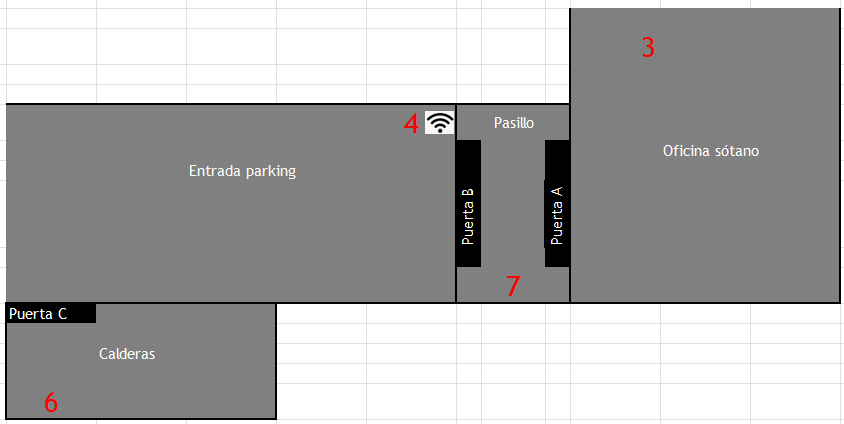

In [43]:
from IPython.display import display
from PIL import Image

imagen = Image.open("plano-pruebas-parque-bomberos-9.png")
display(imagen)

# Periodicidad de los datos a nivel beacon,variable

En este apartado voy a analizar el intervalo de tiempo de llegada de los datos a nivel beacon y variable. Es decir, voy a analizar la tasa de envío de los distintos beacons para cada una de las variables. Esto es por si en algún instante para un cierto beacon se llegaran a enviar datos para unas variables sí y para otros no. Por ejemplo, por si fallara algún sensor dentro del beacon pero otros no.

In [44]:
df 

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  
0                  3  temperatura  
1                  3     Q0 asiaq  
2                  3         diaq  
3                  7         eco2  
4                  7         tvoc  
...              ...          ...  
3558095            4         siaq  
3558096            4     Q0 calib  
3558097            4     Q1 adiaq  
3558098            4         eco2  
3558099            4         tvoc  

[3558100 rows x 7 columns]

## Intervalos de llegada de los datos nivel beacon, variable

In [45]:
# El .set_index() es por la columna extra función que genera la función diff para que luego con pd.concat 
# con el dataframe original. Hay que hacerlo con pd.concat sí o sí no se puede hacer con un join porque 
# df no está identificado a nivel id_beacon, variable, sino a id_beacon, variable, timestamp
# y eso generaría duplicados
intervals_by_beacon_variable = df.groupby(["id_beacon","variable"])\
.apply(lambda x: x["timestamp"].diff())\
.reset_index()\
.rename(columns={"timestamp":"interval_seconds","level_2":"index"})\
.set_index("index") 
intervals_by_beacon_variable

id_beacon  variable interval_seconds
index                                       
1         DBEM003  Q0 asiaq              NaT
31        DBEM003  Q0 asiaq  0 days 00:00:10
51        DBEM003  Q0 asiaq  0 days 00:00:10
89        DBEM003  Q0 asiaq  0 days 00:00:10
94        DBEM003  Q0 asiaq  0 days 00:00:10
...           ...       ...              ...
3557943   DBEM007      tvoc  0 days 01:57:00
3557978   DBEM007      tvoc  0 days 00:45:00
3557982   DBEM007      tvoc  0 days 00:30:00
3557999   DBEM007      tvoc  0 days 01:09:00
3558005   DBEM007      tvoc  0 days 02:09:00

[3558100 rows x 3 columns]

In [46]:
# Convierto la diferencia anterior en segundos
intervals_by_beacon_variable["interval_seconds"] = intervals_by_beacon_variable["interval_seconds"].dt.seconds
intervals_by_beacon_variable

id_beacon  variable  interval_seconds
index                                        
1         DBEM003  Q0 asiaq               NaN
31        DBEM003  Q0 asiaq              10.0
51        DBEM003  Q0 asiaq              10.0
89        DBEM003  Q0 asiaq              10.0
94        DBEM003  Q0 asiaq              10.0
...           ...       ...               ...
3557943   DBEM007      tvoc            7020.0
3557978   DBEM007      tvoc            2700.0
3557982   DBEM007      tvoc            1800.0
3557999   DBEM007      tvoc            4140.0
3558005   DBEM007      tvoc            7740.0

[3558100 rows x 3 columns]

In [47]:
# Agrego la información de los intervalos calculados en el df
df = pd.concat([df,intervals_by_beacon_variable[["interval_seconds"]]],axis=1)
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  
0                  3  temperatura               NaN  
1                  3     Q0 asiaq               NaN  
2                  3         diaq               NaN  
3                  7         eco2               NaN  
4                  7         tvoc               NaN  
...              ...          ...               ...  
3558095            4         siaq              10.0  
3558096            4     Q0 calib              10.0  
3558097            4     Q1 adiaq              10.0  
3558098            4         eco2              10.0  
3558099            4         tvoc              10.0  

[3558100 rows x 8 columns]

## Resumen estadístico del intervalo de llegada de los datos nivel beacon, variable

In [48]:
# Resumen estadístico de todos los datos
summary_statistics_intervals_by_beacon_variable = summary_statistics(
    df,
    variables = "interval_seconds",
    groupby = ["id_beacon","variable"]
)
summary_statistics_intervals_by_beacon_variable

id_beacon     variable   count    Q1    Q3  percentil_90  percentil_99   
0    DBEM003     Q0 asiaq  157083  10.0  10.0          10.0          10.0  \
1    DBEM003     Q0 calib  157083  10.0  10.0          10.0          10.0   
2    DBEM003     Q1 adiaq  157083  10.0  10.0          10.0          10.0   
3    DBEM003         diaq  157083  10.0  10.0          10.0          10.0   
4    DBEM003         eco2  157083  10.0  10.0          10.0          10.0   
5    DBEM003      humedad  157083  10.0  10.0          10.0          10.0   
6    DBEM003      presion  157083  10.0  10.0          10.0          10.0   
7    DBEM003         siaq  157083  10.0  10.0          10.0          10.0   
8    DBEM003  temperatura  157083  10.0  10.0          10.0          10.0   
9    DBEM003         tvoc  157083  10.0  10.0          10.0          10.0   
10   DBEM004     Q0 asiaq  161270  10.0  10.0          10.0          10.0   
11   DBEM004     Q0 calib  161270  10.0  10.0          10.0          10.0   
12   DBEM004     Q1 adiaq  161270  10.0  10.0          10.0          10.0   
13   DBEM004         diaq  161270  10.0  10.0          10.0          10.0   
14   DBEM004         eco2  161270  10.0  10.0          10.0          10.0   
15   DBEM004      humedad  161270  10.0  10.0          10.0          10.0   
16   DBEM004      presion  161270  10.0  10.0          10.0          10.0   
17   DBEM004         siaq  161270  10.0  10.0          10.0          10.0   
18   DBEM004  temperatura  161270  10.0  10.0          10.0          10.0   
19   DBEM004         tvoc  161270  10.0  10.0          10.0          10.0   
20   DBEM006     Q0 asiaq   12162  60.0  60.0          60.0         120.0   
21   DBEM006     Q0 calib   12162  60.0  60.0          60.0         120.0   
22   DBEM006     Q1 adiaq   12162  60.0  60.0          60.0         120.0   
23   DBEM006         diaq   12162  60.0  60.0          60.0         120.0   
24   DBEM006         eco2   12162  60.0  60.0          60.0         120.0   
25   DBEM006      humedad   12162  60.0  60.0          60.0         120.0   
26   DBEM006      presion   12162  60.0  60.0          60.0         120.0   
27   DBEM006         siaq   12162  60.0  60.0          60.0         120.0   
28   DBEM006  temperatura   12162  60.0  60.0          60.0         120.0   
29   DBEM006         tvoc   12162  60.0  60.0          60.0         120.0   
30   DBEM007     Q0 asiaq   25291  60.0  60.0          60.0         120.0   
31   DBEM007     Q0 calib   25291  60.0  60.0          60.0         120.0   
32   DBEM007     Q1 adiaq   25291  60.0  60.0          60.0         120.0   
33   DBEM007         diaq   25291  60.0  60.0          60.0         120.0   
34   DBEM007         eco2   25291  60.0  60.0          60.0         120.0   
35   DBEM007      humedad   25291  60.0  60.0          60.0         120.0   
36   DBEM007      presion   25291  60.0  60.0          60.0         120.0   
37   DBEM007         siaq   25291  60.0  60.0          60.0         120.0   
38   DBEM007  temperatura   25291  60.0  60.0          60.0         120.0   
39   DBEM007         tvoc   25291  60.0  60.0          60.0         120.0   

    median       mean          std   min      max  variable_summary  
0     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
1     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
2     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
3     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
4     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
5     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
6     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
7     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
8     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
9     10.0  10.970570   163.138113  10.0  43150.0  interval_seconds  
10    10.0  11.360885   220.947607  10.0  68370.0  interval_seconds  
11   

In [49]:
# Crear una figura vacía
fig = go.Figure()

# Obtener la lista única de variables e id_beacons
variables = sorted(df['variable'].unique())
id_beacons = sorted(df['id_beacon'].unique())

# Añadir un boxplot por cada variable y id_beacon
for variable in variables:
    for id_beacon in id_beacons:
        fig.add_trace(go.Box(y=df[(df['variable'] == variable) & (df['id_beacon'] == id_beacon)]['interval_seconds'],
                             name=f"{variable} - id_beacon {id_beacon}",
                             visible=False))

# Hacer visible el primer conjunto de boxplots por defecto (un boxplot por id_beacon para la primera variable)
for i in range(len(id_beacons)):
    fig.data[i].visible = True

# Crear botones de la leyenda
legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in id_beacons]}])
                  for variable in variables]

# Añadir leyenda personalizada
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    legend=dict(
        x=0.0,  # Cambiar la posición x de la leyenda
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.5)',  # Añadir un fondo semitransparente para la leyenda
        bordercolor='rgba(0, 0, 0, 0.2)',    # Añadir un borde para la leyenda
        borderwidth=1,                       # Ajustar el grosor del borde de la leyenda
    )
)

# Mostrar el gráfico
name_html = "boxplots-intervalos-llegada-datos-nivel-beacon-variable"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/boxplots-intervalos-llegada-datos-nivel-beacon-variable.html


Hay observaciones atípicas pero la mayoría están en el intervalo esperado. De hecho, el 90 % de los datos para todas las balizas tienen las tasas de envío programadas en la prueba de los bomberos 9 que son: 
- Tasas de envío 10 s : DBEM003, DBEM004
- Tasas de envío 60 s : DBEM006, DBEM007

Voy a analizar únicamente aquellas balizas con tasas de envío incorrectas:

## Observaciones con tasas de datos incorrectas

In [50]:
beacon_rate_send_10s = ["DBEM003","DBEM004"]
beacon_rate_send_60s = ["DBEM006","DBEM007"]
df_wrong_rate_send = df.query("(interval_seconds > 10 & id_beacon.isin(@beacon_rate_send_10s)) | (interval_seconds > 60 & id_beacon.isin(@beacon_rate_send_60s))").reset_index(drop=True)
df_wrong_rate_send

id_beacon id_sensor id_variable                 timestamp    value   
0       DBEM007      sAQU    Q0-calib 2023-04-18 19:56:00+02:00      1.0  \
1       DBEM007      sWEA    Q1-adiaq 2023-04-18 19:56:00+02:00      3.0   
2       DBEM007      sWEA     03-siaq 2023-04-18 19:56:00+02:00     94.0   
3       DBEM007      sAQU     00-eco2 2023-04-18 19:56:00+02:00    462.0   
4       DBEM007      sWEA     04-diaq 2023-04-18 19:56:00+02:00    100.0   
...         ...       ...         ...                       ...      ...   
22735   DBEM006      sWEA    Q0-asiaq 2023-05-14 23:56:00+02:00      1.0   
22736   DBEM006      sWEA     03-siaq 2023-05-14 23:56:00+02:00     30.0   
22737   DBEM006      sAQU     00-eco2 2023-05-14 23:56:00+02:00    514.0   
22738   DBEM006      sWEA     00-temp 2023-05-14 23:56:00+02:00   2394.0   
22739   DBEM006      sWEA     02-pres 2023-05-14 23:56:00+02:00  94196.0   

       id_location     variable  interval_seconds  
0                7     Q0 calib             120.0  
1                7     Q1 adiaq             120.0  
2                7         siaq             120.0  
3                7         eco2             120.0  
4                7         diaq             120.0  
...            ...          ...               ...  
22735            6     Q0 asiaq           42840.0  
22736            6         siaq           42840.0  
22737            6         eco2           42840.0  
22738            6  temperatura           42840.0  
22739            6      presion           42840.0  

[22740 rows x 8 columns]

### Resumen estadístico de los segundos de los datos de llegada con tasa de envío incorrectas nivel beacon, variable 

In [51]:
# Resumen estadístico de todos los datos con tasa de envío incorrecta
summary_statistics_wrong_intervals_by_beacon_variable = summary_statistics(
    df_wrong_rate_send,
    variables = "interval_seconds",
    groupby = ["id_beacon","variable"]                                                                          
)
summary_statistics_wrong_intervals_by_beacon_variable

id_beacon     variable  count     Q1     Q3  percentil_90  percentil_99   
0    DBEM003     Q0 asiaq   1168   20.0   20.0          30.0          70.0  \
1    DBEM003     Q0 calib   1168   20.0   20.0          30.0          70.0   
2    DBEM003     Q1 adiaq   1168   20.0   20.0          30.0          70.0   
3    DBEM003         diaq   1168   20.0   20.0          30.0          70.0   
4    DBEM003         eco2   1168   20.0   20.0          30.0          70.0   
5    DBEM003      humedad   1168   20.0   20.0          30.0          70.0   
6    DBEM003      presion   1168   20.0   20.0          30.0          70.0   
7    DBEM003         siaq   1168   20.0   20.0          30.0          70.0   
8    DBEM003  temperatura   1168   20.0   20.0          30.0          70.0   
9    DBEM003         tvoc   1168   20.0   20.0          30.0          70.0   
10   DBEM004     Q0 asiaq    575   20.0   30.0          40.0       13563.0   
11   DBEM004     Q0 calib    575   20.0   30.0          40.0       13563.0   
12   DBEM004     Q1 adiaq    575   20.0   30.0          40.0       13563.0   
13   DBEM004         diaq    575   20.0   30.0          40.0       13563.0   
14   DBEM004         eco2    575   20.0   30.0          40.0       13563.0   
15   DBEM004      humedad    575   20.0   30.0          40.0       13563.0   
16   DBEM004      presion    575   20.0   30.0          40.0       13563.0   
17   DBEM004         siaq    575   20.0   30.0          40.0       13563.0   
18   DBEM004  temperatura    575   20.0   30.0          40.0       13563.0   
19   DBEM004         tvoc    575   20.0   30.0          40.0       13563.0   
20   DBEM006     Q0 asiaq    176  120.0  360.0         840.0       49365.0   
21   DBEM006     Q0 calib    176  120.0  360.0         840.0       49365.0   
22   DBEM006     Q1 adiaq    176  120.0  360.0         840.0       49365.0   
23   DBEM006         diaq    176  120.0  360.0         840.0       49365.0   
24   DBEM006         eco2    176  120.0  360.0         840.0       49365.0   
25   DBEM006      humedad    176  120.0  360.0         840.0       49365.0   
26   DBEM006      presion    176  120.0  360.0         840.0       49365.0   
27   DBEM006         siaq    176  120.0  360.0         840.0       49365.0   
28   DBEM006  temperatura    176  120.0  360.0         840.0       49365.0   
29   DBEM006         tvoc    176  120.0  360.0         840.0       49365.0   
30   DBEM007     Q0 asiaq    355  120.0  240.0         660.0        7905.6   
31   DBEM007     Q0 calib    355  120.0  240.0         660.0        7905.6   
32   DBEM007     Q1 adiaq    355  120.0  240.0         660.0        7905.6   
33   DBEM007         diaq    355  120.0  240.0         660.0        7905.6   
34   DBEM007         eco2    355  120.0  240.0         660.0        7905.6   
35   DBEM007      humedad    355  120.0  240.0         660.0        7905.6   
36   DBEM007      presion    355  120.0  240.0         660.0        7905.6   
37   DBEM007         siaq    355  120.0  240.0         660.0        7905.6   
38   DBEM007  temperatura    355  120.0  240.0         660.0        7905.6   
39   DBEM007         tvoc    355  120.0  240.0         660.0        7905.6   

    median         mean          std    min      max  variable_summary  
0     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
1     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
2     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
3     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
4     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
5     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
6     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
7     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
8     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
9     20.0   140.530822  1888.229556   20.0  43150.0  interval_seconds  
1

In [52]:

summary_statistics_wrong_intervals_by_beacon_variable.drop("variable",axis=1).drop_duplicates()

id_beacon  count     Q1     Q3  percentil_90  percentil_99  median   
0    DBEM003   1168   20.0   20.0          30.0          70.0    20.0  \
10   DBEM004    575   20.0   30.0          40.0       13563.0    20.0   
20   DBEM006    176  120.0  360.0         840.0       49365.0   180.0   
30   DBEM007    355  120.0  240.0         660.0        7905.6   120.0   

           mean          std    min      max  variable_summary  
0    140.530822  1888.229556   20.0  43150.0  interval_seconds  
10   391.686957  3683.784711   20.0  68370.0  interval_seconds  
20  1749.204545  8887.455007  120.0  78180.0  interval_seconds  
30   662.873239  4099.529761  120.0  68580.0  interval_seconds

Ploteo los distintos intervalos de llegada de los datos para ver la distribución:

In [53]:
# groupby_columns = ['id_sensor', 'variable']
# value_column = 'interval_seconds'
# nbins=None
# groups = df_wrong_rate_send.groupby(groupby_columns)

# for name, group in groups:
#     fig = px.histogram(group, x=value_column, nbins=nbins, title=f"Histogram for {name}")
# #     save_plotly_figure(fig, f"histogramas-periodicidad-tasas-envio-incorrectas-{name[0]}-{name[1]}","htmls/EDA")
#     fig.show()

In [54]:
# groupby_columns = ['id_beacon', 'variable']
# value_column = 'interval_seconds'
# groups = df_wrong_rate_send.groupby(groupby_columns)

# data = []
# buttons_sensors = []
# buttons_variables = []
# sensor_names = df_wrong_rate_send[groupby_columns[0]].unique()
# variable_names = df_wrong_rate_send[groupby_columns[1]].unique()

# for i, (name, group) in enumerate(groups):
#     # Calcular el número de bins basado en un intervalo de 60 para cada grupo
# #     data_range = group[value_column].max() - group[value_column].min()
# #     nbins = int(data_range / 60)
#     nbins = None

#     hist = px.histogram(group, x=value_column, nbins=nbins, title=f"Histogram for {name}")
#     for trace in hist.data:
#         trace.visible = False if i != 0 else True
#         data.append(trace)

#     if i % len(variable_names) == 0:
#         buttons_sensors.append(
#             dict(
#                 label=f"{name[0]}",
#                 method="update",
#                 args=[{"visible": [False] * i + [True] * len(hist.data) * len(variable_names) + [False] * (len(groups) - i - len(variable_names)) * len(hist.data)}],
#             )
#         )

#     if i < len(variable_names):
#         buttons_variables.append(
#             dict(
#                 label=f"{name[1]}",
#                 method="update",
#                 args=[{"visible": [False] * i * len(hist.data) + [True] * len(hist.data) + [False] * (len(groups) - i - 1) * len(hist.data)}],
#             )
#         )

# layout = go.Layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             showactive=True,
#             buttons=buttons_sensors,
#             x=0,
#             xanchor="left",
#             y=-0.05,
#             yanchor="top",
#             pad={"r": 10, "t": 10},
#             direction="right",
#         ),
#         dict(
#             type="buttons",
#             showactive=True,
#             buttons=buttons_variables,
#             x=1.4,
#             xanchor="right",
#             y=1,
#             yanchor="top",
#             pad={"r": 10, "t": 10},
#             direction="down",
#         ),
#     ],
# )

# fig = go.Figure(data=data, layout=layout)

# name_html = "histogramas-periodicidad-tasas-envio-incorrectas-nivel-sensor-variable"
# save_plotly_figure(fig, name_html)
# IFrame(src=f"{name_html}.html", width=900, height=600)

### Boxplot de la periodicidad en las tasas de envío incorrectas

In [55]:
# Crear una figura vacía
fig = go.Figure()

# Obtener la lista única de variables e id_beacons
variables = sorted(df_wrong_rate_send['variable'].unique())
id_beacons = sorted(df_wrong_rate_send['id_beacon'].unique())

# Añadir un boxplot por cada variable y id_beacon
for variable in variables:
    for id_beacon in id_beacons:
        fig.add_trace(go.Box(y=df_wrong_rate_send[(df_wrong_rate_send['variable'] == variable) & (df_wrong_rate_send['id_beacon'] == id_beacon)]['interval_seconds'],
                             name=f"{variable} - id_beacon {id_beacon}",
                             visible=False))

# Hacer visible el primer conjunto de boxplots por defecto (un boxplot por id_beacon para la primera variable)
for i in range(len(id_beacons)):
    fig.data[i].visible = True

# Crear botones de la leyenda
legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in id_beacons]}])
                  for variable in variables]

# Añadir leyenda personalizada
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    legend=dict(
        x=0.0,  # Cambiar la posición x de la leyenda
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.5)',  # Añadir un fondo semitransparente para la leyenda
        bordercolor='rgba(0, 0, 0, 0.2)',    # Añadir un borde para la leyenda
        borderwidth=1,                       # Ajustar el grosor del borde de la leyenda
    )
)

# Mostrar el gráfico
name_html = "boxplots-tasas-envio-incorrectas-nivel-beacon-variable"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/boxplots-tasas-envio-incorrectas-nivel-beacon-variable.html


- Beacons con tasas de envío de 10 s:
    - DBEM003 : La gran mayoría de observaciones (75%) solo pierden información en un instante de tiempo, pues Q3=20. Además, se considera atípio un valor por encima de 20 upper fencer=20
    - DBEM004 : Resultado parecido a DBEM003 salvo que los datos están algo más dispersos: Q3=30 y upper fencer=40
- Beacons con tasas de envío de 60 s:
    - DBEM006 : 
        - El 25 % de las tasas de envío incorrectas pierden información en un instante de tiempo
        - El 25 % de las tasas de envío incorrectas pierden información en dos intantes de tiempo consecutivas
        - El 25 % de las tasas de envío incorrectas pierden información en 3 o 4 instantes de tiempo consecutivas
    - DBEM007 :
        - El 50 % de las tasas de envío incorrectas pierden información  en un instante de tiempo
        - El 25 % de las tasas de envío incorrectas pierden información en 2 o 3 instantes de tiempo consecutivas

- Para la torre de bomberos de Alcorcón: Probar a poner balizas con tasas más frecuentes a mayores distancias para ver si se sigue manteniendo esta tendencia de mayor pérdida en balizas con tasas más infrecuentes o si es por la distancia.

### Gráfica serie temporal de los segundos de llegada para cada sensor

Voy a analizar esos instantes de tiempo y si tienen alguna peculiaridad. Por ejemplo, instantes de tiempo tales que han transcurrido en el desarrollo de alguna prueba

In [56]:
# Crear un objeto Figure
fig = go.Figure()

# Obtener las variables únicas
unique_id_beacons = df['id_beacon'].unique()
unique_variables = df['variable'].unique()

# Añadir trazas para cada variable
for sensor_id in unique_id_beacons:
    for variable in unique_variables:
        df_filtered = df[(df['id_beacon'] == sensor_id) & (df['variable'] == variable)]
        fig.add_trace(go.Scatter(x=df_filtered['timestamp'],
                                 y=df_filtered['interval_seconds'],
                                 mode='lines',
                                 name=f'{sensor_id} - {variable}',
                                 visible=(variable == unique_variables[0])))  # Hacer visible la primera variable

# Crear botones para seleccionar variables
buttons = []
for i, variable in enumerate(unique_variables):
    visible = [False] * len(unique_variables) * len(unique_id_beacons)
    visible[i::len(unique_variables)] = [True] * len(unique_id_beacons)
    buttons.append(
        dict(
            label=variable,
            method='update',
            args=[{'visible': visible},
                  {'title': f'Segundos de llegada desde la última observación por cada variable'}]
        )
    )

# Añadir botones al gráfico y mover la leyenda a la esquina superior izquierda
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="down",
            buttons=buttons,
            showactive=True,
            pad={"r": 10, "t": 10},
            x=1.1,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ],
    legend=dict(  # Añadir la configuración de la leyenda aquí
        x=0,
        xanchor="left",
        y=1,
        yanchor="top"
    )
)

name_html = "serie-temporal-periodicidad-tasas-envio-incorrectas-nivel-beacon-variable"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)


Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/serie-temporal-periodicidad-tasas-envio-incorrectas-nivel-beacon-variable.html


- La baliza 6,la que se encuentra en las calderas, ha dejado de enviar desde el 19 de abril a las 7:17 hasta el 28 de abril a las 9:07
- En el periodo del 6 de mayo hasta el 7 de mayo ha habido un periodo muy irregular en las tasas de envío hasta dejar de enviarse datos paulatinamente en todas las balizas. 
- Falta relacionar si los problemas en la periodicidad tienen algo que ver con las pruebas de los bomberos (más abajo en el notebook está)

# Group by different moments of time

In [57]:
df["timestamp_hour"] = df['timestamp'].dt.hour
df["timestamp_day"] = df['timestamp'].dt.day
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3558095            4         siaq              10.0              23   
3558096            4     Q0 calib              10.0              23   
3558097            4     Q1 adiaq              10.0              23   
3558098            4         eco2              10.0              23   
3558099            4         tvoc              10.0              23   

         timestamp_day  
0                   18  
1                   18  
2                   18  
3                   18  
4                   18  
...                ...  
3558095             14  
3558096             14  
3558097             14  
3558098             14  
3558099             14  

[3558100 rows x 10 columns]

# Análisis variables

In [58]:
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3558095            4         siaq              10.0              23   
3558096            4     Q0 calib              10.0              23   
3558097            4     Q1 adiaq              10.0              23   
3558098            4         eco2              10.0              23   
3558099            4         tvoc              10.0              23   

         timestamp_day  
0                   18  
1                   18  
2                   18  
3                   18  
4                   18  
...                ...  
3558095             14  
3558096             14  
3558097             14  
3558098             14  
3558099             14  

[3558100 rows x 10 columns]

## Análisis de las variables a nivel global

In [59]:
summary_all_variables = summary_statistics(
    df, 
    variables= 'value',
    groupby = "variable")
summary_all_variables

variable   count       Q1       Q3  percentil_90  percentil_99   median   
0     Q0 asiaq  355810      3.0      3.0           3.0           3.0      3.0  \
1     Q0 calib  355810      1.0      1.0           1.0           1.0      1.0   
2     Q1 adiaq  355810      3.0      3.0           3.0           3.0      3.0   
3         diaq  355810     34.0    100.0         161.0         250.0     58.0   
4         eco2  355810    425.0    628.0         796.0        2231.0    502.0   
5      humedad  355810   3124.0   3673.0        4052.0        5059.0   3345.0   
6      presion  355810  93526.0  93830.0       93996.0       94114.0  93695.0   
7         siaq  355810     35.0    104.0         187.0         457.0     60.0   
8  temperatura  355810   2198.0   2449.0        2479.0        2539.0   2353.0   
9         tvoc  355810     69.0    495.0         860.0        2946.0    169.0   

           mean          std      min      max variable_summary  
0      2.661345     0.717083      0.0      3.0            value  
1      0.990841     0.095265      0.0      1.0            value  
2      2.661345     0.717083      0.0      3.0            value  
3     77.634516    59.089052      0.0    500.0            value  
4    620.765468   933.945898    400.0  57330.0            value  
5   3426.753919   491.941254   1204.0   8068.0            value  
6  93630.845477   324.344343  92581.0  94240.0            value  
7     88.925865    89.978621      0.0   1970.0            value  
8   2316.646098   154.560672   1929.0   4571.0            value  
9    403.237408  1209.669381      0.0  60000.0            value

### Boxplot de las variables a nivel global

In [60]:
# Crear una figura vacía
fig = go.Figure()

# Obtener la lista única de variables
variables = df['variable'].unique()

# Añadir un boxplot por cada variable
for variable in variables:
    fig.add_trace(go.Box(y=df[df['variable'] == variable]['value'],
                         name=variable,
                         visible=False))

# Hacer visible el primer boxplot por defecto
fig.data[0].visible = True

# Crear botones de la leyenda
legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables]}])
                  for variable in variables]

# Añadir leyenda personalizada
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ])

# Mostrar el gráfico
name_html = "boxplots-variables-nivel-global"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/boxplots-variables-nivel-global.html


### Histograma de las variables a nivel global

In [61]:
# Crear una figura vacía
fig = go.Figure()

# Obtener la lista única de variables
variables = df['variable'].unique()

# Añadir un histograma por cada variable
for variable in variables:
    fig.add_trace(go.Histogram(x=df[df['variable'] == variable]['value'],
                               name=variable,
                               visible=False))

# Hacer visible el primer histograma por defecto
fig.data[0].visible = True

# Crear botones de la leyenda
legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables]}])
                  for variable in variables]

# Añadir leyenda personalizada
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ])

# Mostrar el gráfico
name_html = "histogramas-variables-nivel-global"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/histogramas-variables-nivel-global.html


- Temperatura 
    - Parece estar multiplicada por 100. De momento lo dejo así hasta averiguar por qué ocurre.
    - El 50 % (Q1,Q3) de las observaciones se mueven en torno a los 22 y 25 º. 
    - Los valores atípicos están únicamente en el rango superior. 
    - Hay muchos valores atípicos por encima de los 29º. Estos posiblemente, correspondan a los instantes de tiempo de las pruebas. 

- Presión
    - El 50 % de las observaciones están entre 93.525 y 93.829
    - Los valores atípicos se encuentran únicamente en el rango inferior
    - Hay muchos valores atípicos por debajo de 93.069. Estos posiblemente, correspondan a los instantes de tiempo de las pruebas. 
    
- Humedad
    - El 50 % de las observaciones están entre 3124 y 3672
    - Los valores atípicos se encuentran tanto por encima como por debajo (<2304 y >4494)

- eco2
    - El 50 % de las observaciones están entre 425 y 628.
    - Los valores atípicos únicamente están por encima. 
    - Los valores atípicos están muy dispersos y hay valores muy altos.
    
- Tvoc

    - El 50% de las observaciones están entre 69 y 496.
    - Hay muchos valores atípicos en el extremo superior, con un valor máximo de 60,000, lo que sugiere un sesgo a la derecha.
    - La media es significativamente mayor que la mediana, lo que indica que hay valores muy altos que están inflando la media.
    

- Diaq

    - Se observa que el 50% de las observaciones están entre 34 y 100.
    - El valor de diaq se extiende hasta un máximo de 500, con muchos valores atípicos, especialmente en el rango superior. Esto podría indicar períodos de tiempo durante los cuales se producen condiciones anómalas.
    - La media y la mediana son relativamente bajas en comparación con el valor máximo, lo que sugiere una distribución sesgada a la derecha.
    
- Siaq

    - El 50% de las observaciones están entre 35 y 104.
    - Similar a diaq, los valores se extienden hasta 1970 con muchos valores atípicos en el rango superior. Esto también podría indicar períodos de condiciones anómalas.
    - La media es mayor que la mediana, lo que indica un sesgo a la derecha en la distribución de los datos.
    
- Comentarios generales

    - Es llamativo que la presión tenga muchos valores atípicos por debajo y la temperatura valores atípicos por encima. Según la Ley de Gay-Lussac. la presión de un gas es directamente proporcional a su temperatura cuando el volumen es constante. Así que si la temperatura aumenta, la presión también aumentará, y si la temperatura disminuye, la presión disminuirá. Habrá que desglosar a más bajo nivel esto para ver por qué ocurre.
    
    - Hay que tener en cuenta que los entornos de las balizas están muy heterogéneas. Por ejemplo, La sala de las calderas es más calurosa que las otras salas. Estas observaciones están sesgando el análisis global y hay que hacer un mayor desglose 
    
    - Podría ser útil considerar la normalización o la transformación de algunas de estas variables debido a su sesgo y rango de valores
    
- Hablar con Alberto tema de unidades

## Análisis de las variables a nivel beacon

Veamos si existen diferencias para cada una de las variables dependiendo del sensor 

In [62]:
summary_all_variables_by_sensor = summary_statistics(
    df, 
    variables= 'value',
    groupby = ["id_beacon","variable"])
summary_all_variables_by_sensor

id_beacon     variable   count       Q1       Q3  percentil_90   
0    DBEM003     Q0 asiaq  157084      1.0      3.0           3.0  \
1    DBEM003     Q0 calib  157084      1.0      1.0           1.0   
2    DBEM003     Q1 adiaq  157084      1.0      3.0           3.0   
3    DBEM003         diaq  157084     35.0    110.0         177.0   
4    DBEM003         eco2  157084    409.0    598.0         779.0   
5    DBEM003      humedad  157084   2988.0   3388.0        3652.0   
6    DBEM003      presion  157084  93521.0  93827.0       93997.0   
7    DBEM003         siaq  157084     32.0     85.0         166.0   
8    DBEM003  temperatura  157084   2408.0   2473.0        2496.0   
9    DBEM003         tvoc  157084     37.0    107.0         177.0   
10   DBEM004     Q0 asiaq  161271      3.0      3.0           3.0   
11   DBEM004     Q0 calib  161271      1.0      1.0           1.0   
12   DBEM004     Q1 adiaq  161271      3.0      3.0           3.0   
13   DBEM004         diaq  161271     35.0     94.0         149.0   
14   DBEM004         eco2  161271    459.0    648.0         829.0   
15   DBEM004      humedad  161271   3206.0   3858.0        4205.0   
16   DBEM004      presion  161271  93516.0  93818.0       93980.0   
17   DBEM004         siaq  161271     40.0    120.0         207.0   
18   DBEM004  temperatura  161271   2138.0   2298.0        2343.0   
19   DBEM004         tvoc  161271    335.0    796.0        1178.0   
20   DBEM006     Q0 asiaq   12163      1.0      3.0           3.0   
21   DBEM006     Q0 calib   12163      1.0      1.0           1.0   
22   DBEM006     Q1 adiaq   12163      1.0      3.0           3.0   
23   DBEM006         diaq   12163     30.0     86.0         147.0   
24   DBEM006         eco2   12163    435.0    660.0         737.0   
25   DBEM006      humedad   12163   3005.0   3603.0        3755.0   
26   DBEM006      presion   12163  93716.0  94018.0       94092.0   
27   DBEM006         siaq   12163     29.0     62.0         100.0   
28   DBEM006  temperatura   12163   2394.0   2534.0        2560.0   
29   DBEM006         tvoc   12163    102.0    396.5         794.0   
30   DBEM007     Q0 asiaq   25292      3.0      3.0           3.0   
31   DBEM007     Q0 calib   25292      1.0      1.0           1.0   
32   DBEM007     Q1 adiaq   25292      3.0      3.0           3.0   
33   DBEM007         diaq   25292     30.0     77.0         138.0   
34   DBEM007         eco2   25292    434.0    612.0         863.8   
35   DBEM007      humedad   25292   3445.0   4174.0        4482.9   
36   DBEM007      presion   25292  93533.0  93838.0       93999.0   
37   DBEM007         siaq   25292     33.0     97.0         210.0   
38   DBEM007  temperatura   25292   2034.0   2172.0        2221.0   
39   DBEM007         tvoc   25292     91.0    183.0         261.0   

    percentil_99   median          mean          std      min      max   
0           3.00      3.0      2.401715     0.891280      0.0      3.0  \
1           1.00      1.0      0.983824     0.126153      0.0      1.0   
2           3.00      3.0      2.401715     0.891280      0.0      3.0   
3         250.00     62.0     83.536089    61.198108      0.0    453.0   
4        1595.00    462.0    555.174862   358.037423    400.0  33909.0   
5        3935.00   3226.0   3240.297230   337.600385   2581.0   7310.0   
6       94115.00  93692.0  93625.439255   326.848862  92583.0  94240.0   
7         335.00     56.0     76.776005    68.976856      0.0    844.0   
8        2528.00   2450.0   2442.054920    41.512637   2094.0   2576.0   
9         420.00     68.0     87.542086    83.509589      0.0   1286.0   
10          3.00      3.0      2.917691     0.325241      0.0      3.0   
11          1.00      1.0      1.000000     0.000000      1.0      1.0   
12          3.00      3.0      2.917691     0.325241      0.0      3.0   
13        274.00     56.0     74.340173    56.839181     22.0    500.0   
14       2727.00    532.0    678.138556  1247.593036    400.0  

In [63]:
# Para verlo mejor pongo los id_beacon como columnas
summary_all_variables_by_sensor.pivot_table(
    index='variable', 
    columns='id_beacon', 
    values=['count', 'Q1', 'Q3', 'percentil_90', 'median', 'mean', 'std', 'min', 'max']
)

Q1                                  Q3                     
id_beacon    DBEM003  DBEM004  DBEM006  DBEM007  DBEM003  DBEM004  DBEM006   
variable                                                                     
Q0 asiaq         1.0      3.0      1.0      3.0      3.0      3.0      3.0  \
Q0 calib         1.0      1.0      1.0      1.0      1.0      1.0      1.0   
Q1 adiaq         1.0      3.0      1.0      3.0      3.0      3.0      3.0   
diaq            35.0     35.0     30.0     30.0    110.0     94.0     86.0   
eco2           409.0    459.0    435.0    434.0    598.0    648.0    660.0   
humedad       2988.0   3206.0   3005.0   3445.0   3388.0   3858.0   3603.0   
presion      93521.0  93516.0  93716.0  93533.0  93827.0  93818.0  94018.0   
siaq            32.0     40.0     29.0     33.0     85.0    120.0     62.0   
temperatura   2408.0   2138.0   2394.0   2034.0   2473.0   2298.0   2534.0   
tvoc            37.0    335.0    102.0     91.0    107.0    796.0    396.5   

                       count                              max            
id_beacon    DBEM007 DBEM003 DBEM004 DBEM006 DBEM007  DBEM003  DBEM004   
variable                                                                 
Q0 asiaq         3.0  157084  161271   12163   25292      3.0      3.0  \
Q0 calib         1.0  157084  161271   12163   25292      1.0      1.0   
Q1 adiaq         3.0  157084  161271   12163   25292      3.0      3.0   
diaq            77.0  157084  161271   12163   25292    453.0    500.0   
eco2           612.0  157084  161271   12163   25292  33909.0  57330.0   
humedad       4174.0  157084  161271   12163   25292   7310.0   8068.0   
presion      93838.0  157084  161271   12163   25292  94240.0  94216.0   
siaq            97.0  157084  161271   12163   25292    844.0   1970.0   
temperatura   2172.0  157084  161271   12163   25292   2576.0   4571.0   
tvoc           183.0  157084  161271   12163   25292   1286.0  60000.0   

                                       mean                               
id_beacon    DBEM006  DBEM007       DBEM003       DBEM004       DBEM006   
variable                                                                  
Q0 asiaq         3.0      3.0      2.401715      2.917691      2.104415  \
Q0 calib         1.0      1.0      0.983824      1.000000      0.940969   
Q1 adiaq         3.0      3.0      2.401715      2.917691      2.104415   
diaq           500.0    500.0     83.536089     74.340173     68.229466   
eco2         13103.0  57330.0    555.174862    678.138556    586.054263   
humedad       4761.0   6000.0   3240.297230   3556.402825   3325.087807   
presion      94196.0  94151.0  93625.439255  93618.370829  93856.487626   
siaq           648.0   1538.0     76.776005    102.099299     56.675902   
temperatura   2618.0   2325.0   2442.054920   2214.881405   2471.036669   
tvoc          4783.0   5500.0     87.542086    756.649670    287.159171   

                            median                                 min   
id_beacon         DBEM007  DBEM003  DBEM004  DBEM006  DBEM007  DBEM003   
variable                                                                 
Q0 asiaq         2.907125      3.0      3.0      3.0      3.0      0.0  \
Q0 calib         1.000000      1.0      1.0      1.0      1.0      0.0   
Q1 adiaq         2.907125      3.0      3.0      3.0      3.0      0.0   
diaq            66.509766     62.0     56.0     45.0     46.0      0.0   
eco2           678.997786    462.0    532.0    513.0    495.0    400.0   
humedad       3807.005338   3226.0   3496.0   3311.0   3761.0   2581.0   
presion      93635.453424  93692.0  93682.0  93847.0  93711.0  92583.0   
siaq            95.896924     56.0     72.0     37.0     58.0      0.0   
temperatura   2112.396608   2450.0   2222.0   2511.0   2123.0   2094.0   
tvoc           166.300609     68.0    511.0    151.0    133.0      0.0   

                                       percentil_90                     
id_beacon    DBEM004  DBEM00

- DBEM003

    - Temperatura: Aunque sigue pareciendo multiplicada por 100, los valores son un poco más elevados que el promedio global. Esto podría indicar que la baliza DBEM003 se encuentra en un entorno más caluroso. Además, los valores atípicos son menores que en el conjunto global, lo que indica una menor variabilidad.
    - Presión: Los valores están bastante cerca de la media global, aunque se nota una menor variabilidad en los valores atípicos.
    - Humedad: La humedad es ligeramente menor que la media global, pero la variabilidad es menor. Los valores atípicos están principalmente en el rango superior.
    - eco2: Aunque la media es menor que la global, la variabilidad es mayor, especialmente en el rango superior.

- DBEM004

    - Temperatura: Los valores son bastante inferiores a la media global, lo que podría indicar un entorno más frío para esta baliza.
    - Presión: Similar a la baliza DBEM003, los valores están cerca de la media global pero con menos variabilidad.
    - Humedad: La humedad es más alta que la media global y presenta una mayor variabilidad. Los valores atípicos se encuentran principalmente en el rango superior.
    - eco2: La media es superior a la global, lo que podría indicar una mayor concentración de CO2 en este entorno. La variabilidad es mucho mayor, especialmente en el rango superior.

- DBEM006

    - Temperatura: Los valores son similares a la media global.
    - Presión: La presión es ligeramente superior a la media global y tiene menos variabilidad, especialmente en los valores atípicos.
    - Humedad: Los valores son similares a la media global, pero con menos variabilidad.
    - eco2: La media es ligeramente inferior a la global, con una variabilidad menor.

- DBEM007

    - Temperatura: Los valores son significativamente más bajos que la media global, lo que indica que este entorno es más frío.
    - Presión: Los valores son similares a la media global pero con mayor variabilidad.
    - Humedad: La humedad es superior a la media global, con mayor variabilidad, especialmente en los valores atípicos.
    - eco2: Aunque la media es similar a la global, hay mucha más variabilidad en los valores, especialmente en los valores atípicos.

En general, los resultados muestran cómo las características del entorno varían significativamente entre balizas, pero vamos a ver si esto es cierto desde un punto de vista más formal, usando test estadísticos así como hacer una corroboración visual.

### Tests estadísticos

El ANOVA, o Análisis de Varianza, es un método estadístico utilizado para determinar si hay diferencias significativas entre las medias de tres o más grupos independientes. El ANOVA se basa en comparar la varianza (la medida de la dispersión de los datos) entre los diferentes grupos y dentro de los grupos. Si la varianza entre los grupos es significativamente mayor que la varianza dentro de los grupos, entonces podemos inferir que hay una diferencia significativa entre las medias de los grupos. La hipótesis nula en un test ANOVA es que todas las medias de los grupos son iguales. En otras palabras, no hay ninguna diferencia entre ellos. Por otro lado, la hipótesis alternativa es que al menos una de las medias de los grupos es diferente.

#### Comparación entre los sensores con tasas de 10 segundos

In [64]:
# Obtener la lista única de variables y sensores
variables = df['variable'].unique()

# Sensores tasa 10 segunods
sensors = ["DBEM003","DBEM004"] #df['id_beacon'].unique()

# Realizar el test ANOVA para cada variable
for variable in variables:
    # Crear una lista vacía para almacenar los valores de cada sensor
    sensor_values = []

    # Obtener los valores de cada sensor
    for sensor in sensors:
        values = df[(df['variable'] == variable) & (df['id_beacon'] == sensor)]['value'].tolist()
        sensor_values.append(values)

    # Realizar el test ANOVA
    f_statistic, p_value = f_oneway(*sensor_values)

    # Mostrar los resultados del test ANOVA
    print(f"Variable: {variable}")
    print(f"F-estadístico: {f_statistic:.4f}")
    print(f"p-valor: {p_value:.4f}")

    # Interpretar el p-valor
    alpha = 0.05
    if p_value < alpha:
        print("Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.")
    else:
        print("No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que las distribuciones son diferentes para los sensores.")
    print("\n")

Variable: temperatura
F-estadístico: 480870.6765
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: Q0 asiaq
F-estadístico: 47548.5326
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: diaq
F-estadístico: 1931.1577
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: eco2
F-estadístico: 1412.6264
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: tvoc
F-estadístico: 23551.9313
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: Q0 calib
F-estadístico: 2651.6053
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: Q1 adiaq
F-estadístico: 47548.5326
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los s

#### Comparación entre los sensores con tasas de 60 segundos

In [65]:
# Obtener la lista única de variables y sensores
variables = df['variable'].unique()

# Sensores tasa 10 segunods
sensors = ["DBEM006","DBEM007"] #df['id_beacon'].unique()

# Realizar el test ANOVA para cada variable
for variable in variables:
    # Crear una lista vacía para almacenar los valores de cada sensor
    sensor_values = []

    # Obtener los valores de cada sensor
    for sensor in sensors:
        values = df[(df['variable'] == variable) & (df['id_beacon'] == sensor)]['value'].tolist()
        sensor_values.append(values)

    # Realizar el test ANOVA
    f_statistic, p_value = f_oneway(*sensor_values)

    # Mostrar los resultados del test ANOVA
    print(f"Variable: {variable}")
    print(f"F-estadístico: {f_statistic:.4f}")
    print(f"p-valor: {p_value:.4f}")

    # Interpretar el p-valor
    alpha = 0.05
    if p_value < alpha:
        print("Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.")
    else:
        print("No se rechaza la hipótesis nula: No hay evidencia suficiente para afirmar que las distribuciones son diferentes para los sensores.")
    print("\n")

Variable: temperatura
F-estadístico: 133916.3225
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: Q0 asiaq
F-estadístico: 13547.7335
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: diaq
F-estadístico: 7.4835
p-valor: 0.0062
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: eco2
F-estadístico: 70.1176
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: tvoc
F-estadístico: 2623.4581
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: Q0 calib
F-estadístico: 1586.6043
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensores.


Variable: Q1 adiaq
F-estadístico: 13547.7335
p-valor: 0.0000
Se rechaza la hipótesis nula: Las distribuciones son diferentes para los sensore

Efectivamente, en todas las variables, existen diferencias a nivel beacon

### Boxplot de las variables a nivel beacon

In [66]:
# Crear una figura vacía
fig = go.Figure()

# Obtener la lista única de variables e id_beacons
variables = df['variable'].unique()
id_beacons = df['id_beacon'].unique()

# Añadir un boxplot por cada variable y id_beacon
for variable in variables:
    for id_beacon in id_beacons:
        fig.add_trace(go.Box(y=df[(df['variable'] == variable) & (df['id_beacon'] == id_beacon)]['value'],
                             name=f"{variable} - id_beacon {id_beacon}",
                             visible=False))

# Hacer visible el primer conjunto de boxplots por defecto (un boxplot por id_beacon para la primera variable)
for i in range(len(id_beacons)):
    fig.data[i].visible = True

# Crear botones de la leyenda
legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in id_beacons]}])
                  for variable in variables]

# Añadir leyenda personalizada
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    legend=dict(
        x=0.0,  # Cambiar la posición x de la leyenda
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.5)',  # Añadir un fondo semitransparente para la leyenda
        bordercolor='rgba(0, 0, 0, 0.2)',    # Añadir un borde para la leyenda
        borderwidth=1,                       # Ajustar el grosor del borde de la leyenda
    )
)

# Mostrar el gráfico
name_html = "boxplots-variables-nivel-beacon"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/boxplots-variables-nivel-beacon.html


### Histograma de las variables a nivel beacon

In [67]:
# Crear una figura vacía
fig = go.Figure()

# Obtener la lista única de variables e id_beacons
variables = df['variable'].unique()
id_beacons = df['id_beacon'].unique()

# Añadir un histograma por cada variable y id_beacon
for variable in variables:
    for id_beacon in id_beacons:
        fig.add_trace(go.Histogram(x=df[(df['variable'] == variable) & (df['id_beacon'] == id_beacon)]['value'],
                                   name=f"{variable} - id_beacon {id_beacon}",
                                   visible=False,
                                   opacity=0.6))  # Ajustar la transparencia de los histogramas

# Hacer visible el primer conjunto de histogramas por defecto (un histograma por id_beacon para la primera variable)
for i in range(len(id_beacons)):
    fig.data[i].visible = True

# Crear botones de la leyenda
legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in id_beacons]}])
                  for variable in variables]

# Añadir leyenda personalizada y ajustar configuración de histograma
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,  # Mantener la posición x de los botones
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    barmode='overlay',  # Para superponer los histogramas
    bargap=0.1,         # Espacio entre las barras en el histograma
    bargroupgap=0.1,    # Espacio entre las barras en grupos de histogramas
    legend=dict(
        x=0.0,  # Cambiar la posición x de la leyenda
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.5)',  # Añadir un fondo semitransparente para la leyenda
        bordercolor='rgba(0, 0, 0, 0.2)',    # Añadir un borde para la leyenda
        borderwidth=1,                       # Ajustar el grosor del borde de la leyenda
    )
)

# Mostrar el gráfico
name_html = "histogramas-variables-nivel-beacon"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/histogramas-variables-nivel-beacon.html


## Análisis de las variabes a nivel temporal

In [68]:
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3558095            4         siaq              10.0              23   
3558096            4     Q0 calib              10.0              23   
3558097            4     Q1 adiaq              10.0              23   
3558098            4         eco2              10.0              23   
3558099            4         tvoc              10.0              23   

         timestamp_day  
0                   18  
1                   18  
2                   18  
3                   18  
4                   18  
...                ...  
3558095             14  
3558096             14  
3558097             14  
3558098             14  
3558099             14  

[3558100 rows x 10 columns]

In [69]:
summary_all_variables_by_hour = summary_statistics(
    df, 
    variables= 'value',
    groupby = ["variable","timestamp_hour"])
summary_all_variables_by_hour

variable  timestamp_hour  count    Q1     Q3  percentil_90  percentil_99   
0    Q0 asiaq               0  15116   2.0    3.0           3.0          3.00  \
1    Q0 asiaq               1  15128   2.0    3.0           3.0          3.00   
2    Q0 asiaq               2  15604   2.0    3.0           3.0          3.00   
3    Q0 asiaq               3  15201   2.0    3.0           3.0          3.00   
4    Q0 asiaq               4  14861   2.0    3.0           3.0          3.00   
..        ...             ...    ...   ...    ...           ...           ...   
235      tvoc              19  15224  77.0  542.0         878.0       1466.00   
236      tvoc              20  15143  71.0  563.0         855.0       1246.16   
237      tvoc              21  15066  67.0  512.0         744.0       1117.00   
238      tvoc              22  15159  60.0  476.0         660.0        897.42   
239      tvoc              23  15160  62.0  428.0         658.0        855.00   

     median        mean         std  min      max variable_summary  
0       3.0    2.494840    0.839348  0.0      3.0            value  
1       3.0    2.432708    0.796448  0.0      3.0            value  
2       3.0    2.470392    0.792005  0.0      3.0            value  
3       3.0    2.516216    0.787829  0.0      3.0            value  
4       3.0    2.459996    0.841131  0.0      3.0            value  
..      ...         ...         ...  ...      ...              ...  
235   153.5  352.491789  370.631971  0.0   2757.0            value  
236   163.0  349.418543  451.407109  0.0  12777.0            value  
237   158.0  302.706956  298.428810  0.0   1679.0            value  
238   156.0  271.457154  253.844064  0.0   1099.0            value  
239   152.5  259.493404  247.883733  0.0   2270.0            value  

[240 rows x 13 columns]

In [70]:
summary_all_variables_by_hour.pivot_table(
    index='variable', 
    columns='timestamp_hour', 
    values=['count', 'Q1', 'Q3', 'percentil_90', 'median', 'mean', 'std', 'min', 'max']
)

Q1                                                         
timestamp_hour       0        1        2        3        4        5        6    
variable                                                                        
Q0 asiaq            2.0      2.0      2.0      2.0      2.0      2.0      3.0  \
Q0 calib            1.0      1.0      1.0      1.0      1.0      1.0      1.0   
Q1 adiaq            2.0      2.0      2.0      2.0      2.0      2.0      3.0   
diaq               28.0     26.0     26.0     27.0     27.0     28.0     29.0   
eco2              418.0    409.0    404.0    403.0    404.0    401.0    403.0   
humedad          3052.0   3136.0   3124.0   3101.0   3133.0   3159.0   3147.0   
presion         93594.0  93608.0  93598.0  93570.0  93549.0  93538.0  93554.0   
siaq               28.0     26.0     26.0     26.0     27.0     27.0     28.0   
temperatura      2208.0   2200.0   2198.0   2161.0   2159.0   2153.0   2144.0   
tvoc               64.0     57.0     52.0     50.0     47.0     45.0     43.0   

                                                                        
timestamp_hour        7        8        9        10       11       12   
variable                                                                
Q0 asiaq            3.00      3.0      2.0      3.0      3.0      3.0  \
Q0 calib            1.00      1.0      1.0      1.0      1.0      1.0   
Q1 adiaq            3.00      3.0      2.0      3.0      3.0      3.0   
diaq               30.00     39.0    118.0     88.0     71.0     71.0   
eco2              407.00    430.0    549.0    515.0    553.0    565.0   
humedad          3132.75   3129.0   3134.0   3170.0   3257.0   3328.0   
presion         93598.00  93631.0  93658.0  93684.0  93668.0  93648.0   
siaq               28.00     35.0    113.0     95.0     90.0     79.0   
temperatura      2135.00   2132.0   2158.0   2187.0   2213.0   2201.0   
tvoc               40.00     51.0     91.0     82.0     98.0    106.0   

                                                                                
timestamp_hour       13       14       15       16       17       18       19   
variable                                                                        
Q0 asiaq            3.0      3.0      3.0      3.0      3.0      3.0      3.0  \
Q0 calib            1.0      1.0      1.0      1.0      1.0      1.0      1.0   
Q1 adiaq            3.0      3.0      3.0      3.0      3.0      3.0      3.0   
diaq               64.0     54.0     56.0     39.0     34.0     35.0     41.0   
eco2              562.0    531.0    509.0    471.0    454.0    442.0    436.0   
humedad          3296.0   3262.0   3151.0   3125.0   3016.0   3026.0   2958.0   
presion         93610.0  93564.0  93535.0  93484.0  93434.0  93398.0  93353.0   
siaq               80.0     66.0     63.0     48.0     41.0     41.0     46.0   
temperatura      2231.0   2225.0   2212.0   2218.0   2236.0   2232.5   2218.0   
tvoc              106.0    111.0    110.0    107.0     90.0     84.0     77.0   

                                                          Q3            
timestamp_hour       20        21       22       23       0        1    
variable                                                                
Q0 asiaq            3.0      3.00      3.0      3.0      3.0      3.0  \
Q0 calib            1.0      1.00      1.0      1.0      1.0      1.0   
Q1 adiaq            3.0      3.00      3.0      3.0      3.0      3.0   
diaq               44.0     41.00     39.0     33.0     62.0     55.0   
eco2              429.0    424.25    427.0    422.0    521.0    505.0   
humedad          2927.0   2959.00   3018.0   3031.0   3607.0   3552.0   
presion         93385.0  93435.00  93522.0  93581.0  93821.0  93820.0   
siaq               48.0     43.00     38.0     32.0     61.0     48.0   
temperatura      2219.0   2218.00   2215.0   2213.0   2453.0   2454.0   
tvoc               71.0     67.00     60.0     62.0    406.0    356.0   

             

### Boxplot de las variables a nivel hora 

In [71]:
# Crear una figura vacía
fig = go.Figure()

# Obtener la lista única de variables y timestamp_hours
variables = df['variable'].unique()
timestamp_hours = df['timestamp_hour'].unique()

# Añadir un boxplot por cada variable y timestamp_hour
for variable in variables:
    for timestamp_hour in timestamp_hours:
        fig.add_trace(go.Box(y=df[(df['variable'] == variable) & (df['timestamp_hour'] == timestamp_hour)]['value'],
                             name=f"{timestamp_hour}",
                             visible=False))

# Hacer visible el primer conjunto de boxplots por defecto (un boxplot por timestamp_hour para la primera variable)
for i in range(len(timestamp_hours)):
    fig.data[i].visible = True

# Crear botones de la leyenda
legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in timestamp_hours]}])
                  for variable in variables]

# Añadir leyenda personalizada
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    showlegend=False  # Ocultar la leyenda
)

# Mostrar el gráfico
name_html = "boxplots-variables-nivel-hora"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/boxplots-variables-nivel-hora.html


In [72]:
summary_all_variables_by_sensor_hour = summary_statistics(
    df, 
    variables= 'value',
    groupby = ["variable","timestamp_hour","id_beacon"])
summary_all_variables_by_sensor_hour

variable  timestamp_hour id_beacon  count     Q1     Q3  percentil_90   
0    Q0 asiaq               0   DBEM003   6770    1.0    3.0           3.0  \
1    Q0 asiaq               0   DBEM004   6804    3.0    3.0           3.0   
2    Q0 asiaq               0   DBEM006    478    1.0    3.0           3.0   
3    Q0 asiaq               0   DBEM007   1064    3.0    3.0           3.0   
4    Q0 asiaq               1   DBEM003   6790    1.0    3.0           3.0   
..        ...             ...       ...    ...    ...    ...           ...   
955      tvoc              22   DBEM007   1073   96.0  151.0         167.8   
956      tvoc              23   DBEM003   6786   28.0   83.0         212.0   
957      tvoc              23   DBEM004   6828  317.0  598.0         753.0   
958      tvoc              23   DBEM006    479  117.0  538.0         806.4   
959      tvoc              23   DBEM007   1067   83.0  153.0         167.0   

     percentil_99  median        mean         std   min     max   
0            3.00     3.0    2.126883    0.986690   0.0     3.0  \
1            3.00     3.0    2.836126    0.462353   0.0     3.0   
2            3.00     1.5    1.958159    0.978986   1.0     3.0   
3            3.00     3.0    2.894737    0.349991   0.0     3.0   
4            3.00     3.0    2.138439    0.940087   0.0     3.0   
..            ...     ...         ...         ...   ...     ...   
955        207.84   125.0  122.552656   37.943045  24.0   230.0   
956        317.00    61.0   76.396404   70.151105   0.0   340.0   
957        895.00   440.0  460.188781  220.682846   0.0  2270.0   
958        855.88   146.0  304.699374  285.882231  39.0   883.0   
959        184.00   122.0  119.375820   44.177052  25.0   513.0   

    variable_summary  
0              value  
1              value  
2              value  
3              value  
4              value  
..               ...  
955            value  
956            value  
957            value  
958            value  
959            value  

[960 rows x 14 columns]

Observaciones:

- Temperatura
    - llamativa la dispersión de los datos a las horas 17 y 18 y a las horas 10 y 11
- Presión 
    - La presión parece ir variando en función de las distintas horas hay un pico de 7 a 11. Sería interesante hacer un zoom a los datos

- Humedad 
    - Es llamativo que solo haya datos atípicos a las 17 y 18 y a las 11 por debajo. ¿Puertas?
    
- eco2
    - Hay claramente unos instantes de tiempo en el que hay varias observaciones con niveles altos de CO2 que es de 6 a 9.
    - De 19 a 5 los valores se mantienen en un intervalo más estrecho

- siaq/diaq
    - Los instantes de tiempo parecen influir en los valores

- Comentarios adicionales

    - Hipótesis a verificar/refutar: Las perturbaciones de puertas altura balizas influyen en los valores

    - Para la torre de bomberos de alcorcón: Las perturbaciones sería más interesante homogeneizarlas, es decir, que siempre ocurran más o menos en un mismo instante de tiempo para ver si ocurren sobre esos instantes de tiempo o es algo que no tiene que ver.
    - Las horas parecen estar desplazadas dos horas respecto las horas reales 

### Boxplot de las variables a nivel beacon, hora 

Según vimos en el apartado anterior sería interesante hacer un análisis a nivel beacon, hora, pero tarda mucho en ejecutarse el gráfico. Existen alternativas, pero de momento, me centraré en otros aspectos del análisis, lo completaré en otro momento.

In [73]:
# Tarda mucho en ejecutarse!!!

# import plotly.graph_objs as go

# groupby_columns = ['id_sensor', 'variable']
# variables = df['variable'].unique()
# timestamp_hours = df['timestamp_hour'].unique()

# data = []
# buttons_sensors = []
# buttons_variables = []
# sensor_names = df[groupby_columns[0]].unique()
# variable_names = df[groupby_columns[1]].unique()

# for i, (sensor_name, variable) in enumerate([(sensor, var) for sensor in sensor_names for var in variable_names]):
#     for timestamp_hour in timestamp_hours:
#         box = go.Box(y=df[(df['id_sensor'] == sensor_name) & (df['variable'] == variable) & (df['timestamp_hour'] == timestamp_hour)]['value'],
#                      name=f"{timestamp_hour}",
#                      visible=False if i != 0 else True)
#         data.append(box)

#     if i % len(variable_names) == 0:
#         buttons_sensors.append(
#             dict(
#                 label=f"{sensor_name}",
#                 method="update",
#                 args=[{"visible": [False] * i + [True] * len(timestamp_hours) * len(variable_names) + [False] * (len(sensor_names) * len(variable_names) - i - len(variable_names)) * len(timestamp_hours)}],
#             )
#         )

#     if i < len(variable_names):
#         buttons_variables.append(
#             dict(
#                 label=f"{variable}",
#                 method="update",
#                 args=[{"visible": [False] * i * len(timestamp_hours) + [True] * len(timestamp_hours) + [False] * (len(sensor_names) * len(variable_names) - i - 1) * len(timestamp_hours)}],
#             )
#         )

# layout = go.Layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             showactive=True,
#             buttons=buttons_sensors,
#             x=0,
#             xanchor="left",
#             y=-0.05,
#             yanchor="top",
#             pad={"r": 10, "t": 10},
#             direction="right",
#         ),
#         dict(
#             type="buttons",
#             showactive=True,
#             buttons=buttons_variables,
#             x=1.4,
#             xanchor="right",
#             y=1,
#             yanchor="top",
#             pad={"r": 10, "t": 10},
#             direction="down",
#         ),
#     ],
# )

# fig = go.Figure(data=data, layout=layout)
# fig.show()

In [74]:
# save_plotly_figure(fig, "boxplots-variables-nivel-sensor-hora","htmls/EDA")

### Análisis datos atípicos

Como hay diferencias a nivel beacon vamos a ver los datos atípicos a nivel variable, beacon

In [75]:
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3558095            4         siaq              10.0              23   
3558096            4     Q0 calib              10.0              23   
3558097            4     Q1 adiaq              10.0              23   
3558098            4         eco2              10.0              23   
3558099            4         tvoc              10.0              23   

         timestamp_day  
0                   18  
1                   18  
2                   18  
3                   18  
4                   18  
...                ...  
3558095             14  
3558096             14  
3558097             14  
3558098             14  
3558099             14  

[3558100 rows x 10 columns]

In [76]:
def find_outliers(group):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group['value'] < lower_bound) | (group['value'] > upper_bound)]
    return outliers

group_outlier = ['id_beacon', 'variable']

outliers_df = df.groupby(group_outlier).apply(find_outliers).reset_index(drop=True)
outliers_df

id_beacon id_sensor id_variable                 timestamp  value   
0        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:00+02:00    0.0  \
1        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:10+02:00    0.0   
2        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:20+02:00    0.0   
3        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:30+02:00    0.0   
4        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:40+02:00    0.0   
...          ...       ...         ...                       ...    ...   
169846   DBEM007      sAQU     01-tvoc 2023-05-05 23:59:00+02:00  499.0   
169847   DBEM007      sAQU     01-tvoc 2023-05-06 00:00:00+02:00  461.0   
169848   DBEM007      sAQU     01-tvoc 2023-05-06 00:01:00+02:00  377.0   
169849   DBEM007      sAQU     01-tvoc 2023-05-06 00:02:00+02:00  346.0   
169850   DBEM007      sAQU     01-tvoc 2023-05-09 14:30:00+02:00  364.0   

        id_location  variable  interval_seconds  timestamp_hour  timestamp_day  
0                 3  Q0 calib               NaN              19             18  
1                 3  Q0 calib              10.0              19             18  
2                 3  Q0 calib              10.0              19             18  
3                 3  Q0 calib              10.0              19             18  
4                 3  Q0 calib              10.0              19             18  
...             ...       ...               ...             ...            ...  
169846            7      tvoc              60.0              23              5  
169847            7      tvoc              60.0               0              6  
169848            7      tvoc              60.0               0              6  
169849            7      tvoc              60.0               0              6  
169850            7      tvoc           30420.0              14              9  

[169851 rows x 10 columns]

In [77]:
outliers_df["outlier"] = True
outliers_df

id_beacon id_sensor id_variable                 timestamp  value   
0        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:00+02:00    0.0  \
1        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:10+02:00    0.0   
2        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:20+02:00    0.0   
3        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:30+02:00    0.0   
4        DBEM003      sAQU    Q0-calib 2023-04-18 19:00:40+02:00    0.0   
...          ...       ...         ...                       ...    ...   
169846   DBEM007      sAQU     01-tvoc 2023-05-05 23:59:00+02:00  499.0   
169847   DBEM007      sAQU     01-tvoc 2023-05-06 00:00:00+02:00  461.0   
169848   DBEM007      sAQU     01-tvoc 2023-05-06 00:01:00+02:00  377.0   
169849   DBEM007      sAQU     01-tvoc 2023-05-06 00:02:00+02:00  346.0   
169850   DBEM007      sAQU     01-tvoc 2023-05-09 14:30:00+02:00  364.0   

        id_location  variable  interval_seconds  timestamp_hour   
0                 3  Q0 calib               NaN              19  \
1                 3  Q0 calib              10.0              19   
2                 3  Q0 calib              10.0              19   
3                 3  Q0 calib              10.0              19   
4                 3  Q0 calib              10.0              19   
...             ...       ...               ...             ...   
169846            7      tvoc              60.0              23   
169847            7      tvoc              60.0               0   
169848            7      tvoc              60.0               0   
169849            7      tvoc              60.0               0   
169850            7      tvoc           30420.0              14   

        timestamp_day  outlier  
0                  18     True  
1                  18     True  
2                  18     True  
3                  18     True  
4                  18     True  
...               ...      ...  
169846              5     True  
169847              6     True  
169848              6     True  
169849              6     True  
169850              9     True  

[169851 rows x 11 columns]

In [78]:
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3558095   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3558096   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3558097   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3558098   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3558099   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3558095            4         siaq              10.0              23   
3558096            4     Q0 calib              10.0              23   
3558097            4     Q1 adiaq              10.0              23   
3558098            4         eco2              10.0              23   
3558099            4         tvoc              10.0              23   

         timestamp_day  
0                   18  
1                   18  
2                   18  
3                   18  
4                   18  
...                ...  
3558095             14  
3558096             14  
3558097             14  
3558098             14  
3558099             14  

[3558100 rows x 10 columns]

In [79]:
df = df.merge(
    outliers_df[["id_sensor","timestamp","variable","outlier"]],
    how="left", 
    left_on = ["id_sensor","timestamp","variable"],
    right_on = ["id_sensor","timestamp","variable"]
)
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3669209   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3669210   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3669211   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3669212   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3669213   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3669209            4         siaq              10.0              23   
3669210            4     Q0 calib              10.0              23   
3669211            4     Q1 adiaq              10.0              23   
3669212            4         eco2              10.0              23   
3669213            4         tvoc              10.0              23   

         timestamp_day outlier  
0                   18     NaN  
1                   18     NaN  
2                   18     NaN  
3                   18     NaN  
4                   18     NaN  
...                ...     ...  
3669209             14     NaN  
3669210             14     NaN  
3669211             14    True  
3669212             14     NaN  
3669213             14     NaN  

[3669214 rows x 11 columns]

In [80]:
df["outlier"] = df["outlier"].fillna(False)
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3669209   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3669210   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3669211   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3669212   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3669213   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3669209            4         siaq              10.0              23   
3669210            4     Q0 calib              10.0              23   
3669211            4     Q1 adiaq              10.0              23   
3669212            4         eco2              10.0              23   
3669213            4         tvoc              10.0              23   

         timestamp_day  outlier  
0                   18    False  
1                   18    False  
2                   18    False  
3                   18    False  
4                   18    False  
...                ...      ...  
3669209             14    False  
3669210             14    False  
3669211             14     True  
3669212             14    False  
3669213             14    False  

[3669214 rows x 11 columns]

### Gráfica serie temporal a nivel beacon (con outliers)

In [81]:
fig = go.Figure()

variables = df['variable'].unique()
id_beacones = df['id_beacon'].unique()

for variable in variables:
    for id_beacon in id_beacones:
        filtered_df = df[(df['variable'] == variable) & (df['id_beacon'] == id_beacon)]
    
        
        fig.add_trace(go.Scatter(x=filtered_df['timestamp'],
                                 y=filtered_df['value'],
                                 mode='lines',
                                 name=f"{variable} - id_beacon {id_beacon}",
                                 marker=dict(size=3),
                                 visible=False))

    


for i in range(0, len(id_beacones), 1):
    fig.data[i].visible = True

legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in id_beacones]}])
                  for variable in variables]

fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    legend=dict(
        x=0.0,
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.2)',
        borderwidth=1,
    )
)

# Mostrar el gráfico
name_html = "serie-temporal-variables-nivel-beacon"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/serie-temporal-variables-nivel-beacon.html


### Autocorrelación a nivel beacon (con outliers)

In [82]:
from statsmodels.tsa.stattools import acf

fig = go.Figure()

variables = df['variable'].unique()
id_beacones = df['id_beacon'].unique()

for variable in variables:
    for id_beacon in id_beacones:
        filtered_df = df[(df['variable'] == variable) & (df['id_beacon'] == id_beacon)]
        
        # Calcular la autocorrelación
        autocorr = acf(filtered_df['value'])
        
        fig.add_trace(go.Bar(
            x=list(range(len(autocorr))),
            y=autocorr,
            name=f"{variable} - id_beacon {id_beacon}",
            visible=False
        ))

# Hacer visible la primera serie
for i in range(0, len(id_beacones), 1):
    fig.data[i].visible = True

legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in id_beacones]}])
                  for variable in variables]

fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    showlegend=True,
    xaxis_title="Lag",
    yaxis_title="Autocorrelation",
)

# Mostrar el gráfico
name_html = "autocorrelacion-variables-nivel-beacon"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/autocorrelacion-variables-nivel-beacon.html


### Gráfica serie temporal a nivel beacon (sin outliers)

In [83]:
fig = go.Figure()

variables = df['variable'].unique()
id_beacones = df['id_beacon'].unique()

for variable in variables:
    for id_beacon in id_beacones:
        filtered_df = df[(df['variable'] == variable) & (df['id_beacon'] == id_beacon) & ~df["outlier"]]
    
        
        fig.add_trace(go.Scatter(x=filtered_df['timestamp'],
                                 y=filtered_df['value'],
                                 mode='lines',
                                 name=f"{variable} - id_beacon {id_beacon}",
                                 marker=dict(size=3),
                                 visible=False))

    


for i in range(0, len(id_beacones), 1):
    fig.data[i].visible = True

legend_buttons = [dict(label=variable,
                       method='update',
                       args=[{'visible': [v == variable for v in variables for _ in id_beacones]}])
                  for variable in variables]

fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=legend_buttons,
            x=1.1,
            xanchor='left',
            y=1,
            yanchor='top'
        )
    ],
    legend=dict(
        x=0.0,
        y=1.0,
        xanchor='left',
        yanchor='top',
        bgcolor='rgba(255, 255, 255, 0.5)',
        bordercolor='rgba(0, 0, 0, 0.2)',
        borderwidth=1,
    )
)

# Mostrar el gráfico
name_html = "serie-temporal-variables-nivel-beacon-quitando-outliers"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/serie-temporal-variables-nivel-beacon-quitando-outliers.html


- tvoc:
    - Dependiendo de la localización de la baliza, esta variable tiene claramente valores distintos
    - El orden suele ser baliza4>baliza7>baliza3>baliza 6
    - En general, valores mucho más altos en la baliza 4, la de la entrada parking. Tiene sentido.
    - Parece La baliza 6 únicamente no ocupa una posición más alta porque tiene más pérdida de datos ya que remonta al final
- presion:
    - El orden se invierte con respecto al tvoc con una dominancia de la baliza 6 cuando envía datos

- Temperatura:
... 
Ver gráficos  y comentar

# Análisis relación entre las variables

In [84]:
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3669209   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3669210   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3669211   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3669212   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3669213   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3669209            4         siaq              10.0              23   
3669210            4     Q0 calib              10.0              23   
3669211            4     Q1 adiaq              10.0              23   
3669212            4         eco2              10.0              23   
3669213            4         tvoc              10.0              23   

         timestamp_day  outlier  
0                   18    False  
1                   18    False  
2                   18    False  
3                   18    False  
4                   18    False  
...                ...      ...  
3669209             14    False  
3669210             14    False  
3669211             14     True  
3669212             14    False  
3669213             14    False  

[3669214 rows x 11 columns]

## Correlaciones nivel beacon

In [85]:
df_timestamp_beacon_variables = df.pivot_table(index=["timestamp","id_beacon"],columns="variable", values="value").reset_index()
df_timestamp_beacon_variables

variable                 timestamp id_beacon  Q0 asiaq  Q0 calib  Q1 adiaq   
0        2023-04-18 19:00:00+02:00   DBEM003       1.0       0.0       1.0  \
1        2023-04-18 19:00:00+02:00   DBEM004       3.0       1.0       3.0   
2        2023-04-18 19:00:00+02:00   DBEM007       3.0       1.0       3.0   
3        2023-04-18 19:00:10+02:00   DBEM003       1.0       0.0       1.0   
4        2023-04-18 19:00:10+02:00   DBEM004       3.0       1.0       3.0   
...                            ...       ...       ...       ...       ...   
355805   2023-05-14 23:55:40+02:00   DBEM004       0.0       1.0       0.0   
355806   2023-05-14 23:55:50+02:00   DBEM004       0.0       1.0       0.0   
355807   2023-05-14 23:56:00+02:00   DBEM004       0.0       1.0       0.0   
355808   2023-05-14 23:56:00+02:00   DBEM006       1.0       1.0       1.0   
355809   2023-05-14 23:56:10+02:00   DBEM004       0.0       1.0       0.0   

variable   diaq   eco2  humedad  presion   siaq  temperatura   tvoc  
0          51.0  425.0   2729.0  93075.0   36.0       2391.0   18.0  
1         115.0  400.0   2514.0  93063.0  118.0       2093.0  306.0  
2         125.0  409.0   2728.0  93078.0  120.0       2012.0   38.0  
3          51.0  400.0   2730.0  93075.0   36.0       2391.0   10.0  
4         117.0  400.0   2516.0  93063.0  120.0       2094.0  274.0  
...         ...    ...      ...      ...    ...          ...    ...  
355805     69.0  501.0   3189.0  94149.0   86.0       2222.0   14.0  
355806     68.0  501.0   3194.0  94153.0   84.0       2224.0    0.0  
355807     67.0  542.0   3197.0  94149.0   82.0       2224.0   17.0  
355808     35.0  514.0   3277.0  94196.0   30.0       2394.0  812.0  
355809     65.0  492.0   3196.0  94149.0   80.0       2227.0    0.0  

[355810 rows x 12 columns]

In [86]:
grouped = df_timestamp_beacon_variables.groupby('id_beacon')

correlations = {id_beacon: group.drop(['id_beacon',"timestamp"], axis=1).corr()  for id_beacon, group in grouped}
correlations

{'DBEM003': variable     Q0 asiaq  Q0 calib  Q1 adiaq      diaq      eco2   humedad   
 variable                                                                  
 Q0 asiaq     1.000000  0.201662  1.000000  0.103174  0.132808  0.254778  \
 Q0 calib     0.201662  1.000000  0.201662  0.048367  0.052698  0.186150   
 Q1 adiaq     1.000000  0.201662  1.000000  0.103174  0.132808  0.254778   
 diaq         0.103174  0.048367  0.103174  1.000000  0.444758  0.045724   
 eco2         0.132808  0.052698  0.132808  0.444758  1.000000  0.152993   
 humedad      0.254778  0.186150  0.254778  0.045724  0.152993  1.000000   
 presion      0.115016  0.168913  0.115016  0.030863  0.026040  0.400556   
 siaq         0.230693  0.067982  0.230693  0.862953  0.598531  0.097961   
 temperatura  0.246562  0.174274  0.246562 -0.009736  0.053854  0.166183   
 tvoc         0.253750  0.097112  0.253750  0.343722  0.781844  0.215968   
 
 variable      presion      siaq  temperatura      tvoc  
 variable        

In [87]:
correlations_df = pd.concat(correlations, axis=0)
correlations_df

variable             Q0 asiaq  Q0 calib  Q1 adiaq      diaq      eco2   
        variable                                                        
DBEM003 Q0 asiaq     1.000000  0.201662  1.000000  0.103174  0.132808  \
        Q0 calib     0.201662  1.000000  0.201662  0.048367  0.052698   
        Q1 adiaq     1.000000  0.201662  1.000000  0.103174  0.132808   
        diaq         0.103174  0.048367  0.103174  1.000000  0.444758   
        eco2         0.132808  0.052698  0.132808  0.444758  1.000000   
        humedad      0.254778  0.186150  0.254778  0.045724  0.152993   
        presion      0.115016  0.168913  0.115016  0.030863  0.026040   
        siaq         0.230693  0.067982  0.230693  0.862953  0.598531   
        temperatura  0.246562  0.174274  0.246562 -0.009736  0.053854   
        tvoc         0.253750  0.097112  0.253750  0.343722  0.781844   
DBEM004 Q0 asiaq     1.000000       NaN  1.000000 -0.081761 -0.130450   
        Q0 calib          NaN       NaN       NaN       NaN       NaN   
        Q1 adiaq     1.000000       NaN  1.000000 -0.081761 -0.130450   
        diaq        -0.081761       NaN -0.081761  1.000000  0.431977   
        eco2        -0.130450       NaN -0.130450  0.431977  1.000000   
        humedad      0.011353       NaN  0.011353  0.043778  0.097239   
        presion      0.001432       NaN  0.001432  0.115182 -0.000735   
        siaq        -0.099065       NaN -0.099065  0.913616  0.524904   
        temperatura  0.015250       NaN  0.015250 -0.023685 -0.037202   
        tvoc        -0.146466       NaN -0.146466  0.532174  0.928997   
DBEM006 Q0 asiaq     1.000000 -0.195854  1.000000 -0.113617  0.241807   
        Q0 calib    -0.195854  1.000000 -0.195854 -0.001131  0.137428   
        Q1 adiaq     1.000000 -0.195854  1.000000 -0.113617  0.241807   
        diaq        -0.113617 -0.001131 -0.113617  1.000000  0.499725   
        eco2         0.241807  0.137428  0.241807  0.499725  1.000000   
        humedad      0.303372 -0.191269  0.303372  0.104889  0.073975   
        presion      0.105565  0.211093  0.105565  0.043169  0.174502   
        siaq         0.141264 -0.185804  0.141264  0.838287  0.661886   
        temperatura  0.112331  0.079050  0.112331 -0.250089  0.159198   
        tvoc         0.250172  0.219588  0.250172  0.079638  0.506418   
DBEM007 Q0 asiaq     1.000000       NaN  1.000000 -0.096310 -0.146739   
        Q0 calib          NaN       NaN       NaN       NaN       NaN   
        Q1 adiaq     1.000000       NaN  1.000000 -0.096310 -0.146739   
        diaq        -0.096310       NaN -0.096310  1.000000  0.524944   
        eco2        -0.146739       NaN -0.146739  0.524944  1.000000   
        humedad      0.007726       NaN  0.007726  0.020183  0.082927   
        presion      0.016197       NaN  0.016197  0.052687  0.002135   
        siaq        -0.107470       NaN -0.107470  0.914750  0.599356   
        temperatura  0.011973       NaN  0.011973 -0.088304 -0.056882   
        tvoc        -0.128046       NaN -0.128046  0.675326  0.794512   

variable              humedad   presion      siaq  temperatura      tvoc  
        variable                                                          
DBEM003 Q0 asiaq     0.254778  0.115016  0.230693     0.246562  0.253750  
        Q0 calib     0.186150  0.168913  0.067982     0.174274  0.097112  
        Q1 adiaq     0.254778  0.115016  0.230693     0.246562  0.253750  
        diaq         0.045724  0.030863  0.862953    -0.009736  0.343722  
        eco2         0.152993  0.026040  0.598531     0.053854  0.781844  
        humedad      1.000000  0.400556  0.097961     0.166183  0.215968  
        presion      0.400556  1.000000  0.096085     0.422693 -0.006935  
        siaq         0.097961  0.096085  1.000000     0.053088  0.509162  
        temperatura  0.166183  0.422693  0.053088     1.000000  0.158482  
        tvoc         0.215968 -0.006935  0.509162     0.158482  1.000000  
DBEM004 Q0 asiaq     0.011353  0.

## Gráfica de matriz de correlaciones nivel beacon

In [88]:
beacons = list(correlations.keys())

# Calculate the global minimum and maximum correlation
global_min = min(np.min(correlations[beacon].values) for beacon in beacons)
global_max = max(np.max(correlations[beacon].values) for beacon in beacons)

# Initialize figure
fig = go.Figure()

# Add traces, one for each beacon
for beacon in beacons:
    fig.add_trace(
        go.Heatmap(z=correlations[beacon], 
                   x=correlations[beacon].columns, 
                   y=correlations[beacon].index, 
                   zmin=global_min, zmax=global_max,  # Set the same color scale
                   colorscale='RdYlGn',  # Use Red-Yellow-Green colorscale
                   name=beacon))

# Make all traces invisible
for i in range(len(fig.data)):
    fig.data[i].visible = False

# Make first trace visible
fig.data[0].visible = True

# Create and add buttons
buttons = []
for i, beacon in enumerate(beacons):
    visible = [False]*len(beacons)
    visible[i] = True  # Toggle i'th trace to "visible"
    button = dict(
        label=beacon,
        method="update",
        args=[{"visible": visible}],
    )
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=1.1,
            y=1.2,
            buttons=buttons,
        )
    ]
)

# Mostrar el gráfico
name_html = "matriz-correlaciones-variables-nivel-beacon"
save_plotly_figure(fig, name_html)
IFrame(src=f"{name_html}.html", width=900, height=600)

Saved C:\Users\rober\OneDrive\app-guide2fr\guide2fr-cda\exploratory_notebooks\EDA/matriz-correlaciones-variables-nivel-beacon.html


In [89]:
df

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3669209   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3669210   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3669211   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3669212   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3669213   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3669209            4         siaq              10.0              23   
3669210            4     Q0 calib              10.0              23   
3669211            4     Q1 adiaq              10.0              23   
3669212            4         eco2              10.0              23   
3669213            4         tvoc              10.0              23   

         timestamp_day  outlier  
0                   18    False  
1                   18    False  
2                   18    False  
3                   18    False  
4                   18    False  
...                ...      ...  
3669209             14    False  
3669210             14    False  
3669211             14     True  
3669212             14    False  
3669213             14    False  

[3669214 rows x 11 columns]

## Comentarios

stas matrices de correlación representan las relaciones entre diferentes variables para diferentes beacons. Las correlaciones varían entre -1 y 1, donde -1 indica una correlación negativa perfecta, 1 indica una correlación positiva perfecta y 0 indica que no hay correlación.

- diaq y siaq muestran una fuerte correlación positiva en todos los beacons. Esto sugiere que estas dos variables tienden a moverse juntas, es decir, cuando una aumenta, la otra también tiende a aumentar. Esta correlación es particularmente fuerte para los beacons DBEM004 y DBEM007.

- eco2 y tvoc también muestran una fuerte correlación positiva, especialmente en DBEM004 y DBEM007. Esto sugiere que estas dos variables también tienden a moverse juntas.

- La correlación entre eco2 y diaq es significativamente alta en todos los beacons, lo que sugiere una posible relación entre estas dos variables.

- temperatura y presion muestran una correlación moderada en DBEM006 y DBEM007, lo que indica que estas dos variables podrían estar relacionadas.

- Q0 asiaq, Q1 adiaq y Q0 calib tienen exactamente la misma correlación con todas las otras variables en cada beacon. Esto podría indicar que estas tres variables son similares o tienen la misma información.

- En DBEM004 y DBEM007, la correlación de Q0 calib con las demás variables es NaN, lo que significa que los datos para Q0 calib pueden estar ausentes o no variar en estos beacons.

- humedad y temperatura tienen una correlación negativa lo que sugiere que estas variables se mueven en direcciones opuestas. cuando la humedad aumenta, la temperatura tiende a disminuir y viceversa.

# Pruebas bomberos

## Ejemplo de las salidas del preprocesado del excel para una variable

El excel consta de varias pestañas, una para cada prueba. Hay que limpiar eso y dejarlo en el DataFrame original sobre el que estoy haciendo el análisis. Para eso voy a crear una función para que se vean las distintas salidas y se entienda el código cuando después se aplique a todas las pestañas del excel

In [90]:
path_pruebas = "../../data/pruebas-bomberos-parque-9-relleno.xlsx"

In [91]:
pruebas_temperatura = pd.read_excel(path_pruebas,"temperatura", header = [0,1,2])
pruebas_temperatura

timestamp temperatura                                    
     Unnamed: 0_level_1    baliza 3                                    
     Unnamed: 0_level_2 descripcion duracion comentarios adicionales   
0   2023-04-18 00:00:00         NaN      NaN                     NaN  \
1   2023-04-18 01:00:00         NaN      NaN                     NaN   
2   2023-04-18 02:00:00         NaN      NaN                     NaN   
3   2023-04-18 03:00:00         NaN      NaN                     NaN   
4   2023-04-18 04:00:00         NaN      NaN                     NaN   
..                  ...         ...      ...                     ...   
716 2023-05-17 20:00:00         NaN      NaN                     NaN   
717 2023-05-17 21:00:00         NaN      NaN                     NaN   
718 2023-05-17 22:00:00         NaN      NaN                     NaN   
719 2023-05-17 23:00:00         NaN      NaN                     NaN   
720 2023-05-18 00:00:00         NaN      NaN                     NaN   

                                                                        
       baliza 4                                     baliza 6            
    descripcion duracion comentarios adicionales descripcion duracion   
0           NaN      NaN                     NaN         NaN      NaN  \
1           NaN      NaN                     NaN         NaN      NaN   
2           NaN      NaN                     NaN         NaN      NaN   
3           NaN      NaN                     NaN         NaN      NaN   
4           NaN      NaN                     NaN         NaN      NaN   
..          ...      ...                     ...         ...      ...   
716         NaN      NaN                     NaN         NaN      NaN   
717         NaN      NaN                     NaN         NaN      NaN   
718         NaN      NaN                     NaN         NaN      NaN   
719         NaN      NaN                     NaN         NaN      NaN   
720         NaN      NaN                     NaN         NaN      NaN   

                                                                          
                               baliza 7                                   
    comentarios adicionales descripcion duracion comentarios adicionales  
0                       NaN         NaN      NaN                     NaN  
1                       NaN         NaN      NaN                     NaN  
2                       NaN         NaN      NaN                     NaN  
3                       NaN         NaN      NaN                     NaN  
4                       NaN         NaN      NaN                     NaN  
..                      ...         ...      ...                     ...  
716                     NaN         NaN      NaN                     NaN  
717                     NaN         NaN      NaN                     NaN  
718                     NaN         NaN      NaN                     NaN  
719                     NaN         NaN      NaN                     NaN  
720                     NaN         NaN      NaN                     NaN  

[721 rows x 13 columns]

### Aplanamiento de las columnas 

Es necesario trabajar con el DataFrame no con multiindex de las columnas si no con un nivel. Para eso uso un separador 

In [92]:
pruebas_temperatura.columns

MultiIndex([(  'timestamp', 'Unnamed: 0_level_1',      'Unnamed: 0_level_2'),
            ('temperatura',           'baliza 3',             'descripcion'),
            ('temperatura',           'baliza 3',                'duracion'),
            ('temperatura',           'baliza 3', 'comentarios adicionales'),
            ('temperatura',           'baliza 4',             'descripcion'),
            ('temperatura',           'baliza 4',                'duracion'),
            ('temperatura',           'baliza 4', 'comentarios adicionales'),
            ('temperatura',           'baliza 6',             'descripcion'),
            ('temperatura',           'baliza 6',                'duracion'),
            ('temperatura',           'baliza 6', 'comentarios adicionales'),
            ('temperatura',           'baliza 7',             'descripcion'),
            ('temperatura',           'baliza 7',                'duracion'),
            ('temperatura',           'baliza 7', 'comentarios a

In [93]:
separator = ";;;"
pruebas_temperatura.columns = [separator.join(col).strip() if col[0]!='timestamp' else "timestamp"  for col in pruebas_temperatura.columns ]
pruebas_temperatura

timestamp temperatura;;;baliza 3;;;descripcion   
0   2023-04-18 00:00:00                                  NaN  \
1   2023-04-18 01:00:00                                  NaN   
2   2023-04-18 02:00:00                                  NaN   
3   2023-04-18 03:00:00                                  NaN   
4   2023-04-18 04:00:00                                  NaN   
..                  ...                                  ...   
716 2023-05-17 20:00:00                                  NaN   
717 2023-05-17 21:00:00                                  NaN   
718 2023-05-17 22:00:00                                  NaN   
719 2023-05-17 23:00:00                                  NaN   
720 2023-05-18 00:00:00                                  NaN   

    temperatura;;;baliza 3;;;duracion   
0                                 NaN  \
1                                 NaN   
2                                 NaN   
3                                 NaN   
4                                 NaN   
..                                ...   
716                               NaN   
717                               NaN   
718                               NaN   
719                               NaN   
720                               NaN   

    temperatura;;;baliza 3;;;comentarios adicionales   
0                                                NaN  \
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
..                                               ...   
716                                              NaN   
717                                              NaN   
718                                              NaN   
719                                              NaN   
720                                              NaN   

    temperatura;;;baliza 4;;;descripcion temperatura;;;baliza 4;;;duracion   
0                                    NaN                               NaN  \
1                                    NaN                               NaN   
2                                    NaN                               NaN   
3                                    NaN                               NaN   
4                                    NaN                               NaN   
..                                   ...                               ...   
716                                  NaN                               NaN   
717                                  NaN                               NaN   
718                                  NaN                               NaN   
719                                  NaN                               NaN   
720                                  NaN                               NaN   

     temperatura;;;baliza 4;;;comentarios adicionales   
0                                                 NaN  \
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
..                                                ...   
716                                               NaN   
717                                               NaN   
718                                               NaN   
719                                               NaN   
720                                               NaN   

    temperatura;;;baliza 6;;;descripcion temperatura;;;baliza 6;;;duracion   
0                                    NaN                               NaN  \
1                                    NaN                               NaN   
2                                    NaN                               NaN   
3                                    NaN                               NaN   
4                                    NaN                           

### Formato wider a formato longer

In [94]:
pruebas_temperatura = pruebas_temperatura.melt(id_vars='timestamp', var_name='variable')
pruebas_temperatura

timestamp                                          variable   
0    2023-04-18 00:00:00              temperatura;;;baliza 3;;;descripcion  \
1    2023-04-18 01:00:00              temperatura;;;baliza 3;;;descripcion   
2    2023-04-18 02:00:00              temperatura;;;baliza 3;;;descripcion   
3    2023-04-18 03:00:00              temperatura;;;baliza 3;;;descripcion   
4    2023-04-18 04:00:00              temperatura;;;baliza 3;;;descripcion   
...                  ...                                               ...   
8647 2023-05-17 20:00:00  temperatura;;;baliza 7;;;comentarios adicionales   
8648 2023-05-17 21:00:00  temperatura;;;baliza 7;;;comentarios adicionales   
8649 2023-05-17 22:00:00  temperatura;;;baliza 7;;;comentarios adicionales   
8650 2023-05-17 23:00:00  temperatura;;;baliza 7;;;comentarios adicionales   
8651 2023-05-18 00:00:00  temperatura;;;baliza 7;;;comentarios adicionales   

     value  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
...    ...  
8647   NaN  
8648   NaN  
8649   NaN  
8650   NaN  
8651   NaN  

[8652 rows x 3 columns]

### Expansión de columnas 

In [95]:
columns_expanded = pruebas_temperatura['variable'].str.split(separator,expand=True)\
.rename(columns={
    0: "variable_intervention",
    1: "id_beacon",
    2: "filled_field"
})
columns_expanded

variable_intervention id_beacon             filled_field
0              temperatura  baliza 3              descripcion
1              temperatura  baliza 3              descripcion
2              temperatura  baliza 3              descripcion
3              temperatura  baliza 3              descripcion
4              temperatura  baliza 3              descripcion
...                    ...       ...                      ...
8647           temperatura  baliza 7  comentarios adicionales
8648           temperatura  baliza 7  comentarios adicionales
8649           temperatura  baliza 7  comentarios adicionales
8650           temperatura  baliza 7  comentarios adicionales
8651           temperatura  baliza 7  comentarios adicionales

[8652 rows x 3 columns]

In [96]:
pruebas_temperatura = pd.concat([pruebas_temperatura.drop("variable",axis=1),columns_expanded],axis=1)
pruebas_temperatura

timestamp value variable_intervention id_beacon   
0    2023-04-18 00:00:00   NaN           temperatura  baliza 3  \
1    2023-04-18 01:00:00   NaN           temperatura  baliza 3   
2    2023-04-18 02:00:00   NaN           temperatura  baliza 3   
3    2023-04-18 03:00:00   NaN           temperatura  baliza 3   
4    2023-04-18 04:00:00   NaN           temperatura  baliza 3   
...                  ...   ...                   ...       ...   
8647 2023-05-17 20:00:00   NaN           temperatura  baliza 7   
8648 2023-05-17 21:00:00   NaN           temperatura  baliza 7   
8649 2023-05-17 22:00:00   NaN           temperatura  baliza 7   
8650 2023-05-17 23:00:00   NaN           temperatura  baliza 7   
8651 2023-05-18 00:00:00   NaN           temperatura  baliza 7   

                 filled_field  
0                 descripcion  
1                 descripcion  
2                 descripcion  
3                 descripcion  
4                 descripcion  
...                       ...  
8647  comentarios adicionales  
8648  comentarios adicionales  
8649  comentarios adicionales  
8650  comentarios adicionales  
8651  comentarios adicionales  

[8652 rows x 5 columns]

## Preprocesamiento del excel de los bomberos

Voy a automatizar el paso anterior para todas las sheets:

In [184]:
def preprocessing_interventions_df(path,sheet_name):
    print(sheet_name)
    df = pd.read_excel(path,sheet_name, header = [0,1,2])
    separator = ";;;"
    df.columns = [separator.join(col).strip() if col[0]!='timestamp' else "timestamp"  for col in df.columns ]
    df = df.melt(id_vars='timestamp', var_name='variable')
    columns_expanded = df['variable'].str.split(separator,expand=True)\
    .rename(columns={
        0: "variable_intervention",
        1: "id_beacon",
        2: "filled_field"
    })
    df = pd.concat([df.drop("variable",axis=1),columns_expanded],axis=1)
    return df
    

In [185]:
sheet_names = ["temperatura","humedad","combustion","otras variables"]
dfs_interventions = [preprocessing_interventions_df(path_pruebas,sheet) for sheet in sheet_names]
dfs_interventions

temperatura
humedad
combustion
otras variables


[               timestamp value variable_intervention id_beacon   
 0    2023-04-18 00:00:00   NaN           temperatura  baliza 3  \
 1    2023-04-18 01:00:00   NaN           temperatura  baliza 3   
 2    2023-04-18 02:00:00   NaN           temperatura  baliza 3   
 3    2023-04-18 03:00:00   NaN           temperatura  baliza 3   
 4    2023-04-18 04:00:00   NaN           temperatura  baliza 3   
 ...                  ...   ...                   ...       ...   
 8647 2023-05-17 20:00:00   NaN           temperatura  baliza 7   
 8648 2023-05-17 21:00:00   NaN           temperatura  baliza 7   
 8649 2023-05-17 22:00:00   NaN           temperatura  baliza 7   
 8650 2023-05-17 23:00:00   NaN           temperatura  baliza 7   
 8651 2023-05-18 00:00:00   NaN           temperatura  baliza 7   
 
                  filled_field  
 0                 descripcion  
 1                 descripcion  
 2                 descripcion  
 3                 descripcion  
 4                 descripcio

In [186]:
df_interventions = pd.concat(dfs_interventions,axis=0)
df_interventions

timestamp value variable_intervention id_beacon   
0    2023-04-18 00:00:00   NaN           temperatura  baliza 3  \
1    2023-04-18 01:00:00   NaN           temperatura  baliza 3   
2    2023-04-18 02:00:00   NaN           temperatura  baliza 3   
3    2023-04-18 03:00:00   NaN           temperatura  baliza 3   
4    2023-04-18 04:00:00   NaN           temperatura  baliza 3   
...                  ...   ...                   ...       ...   
8647 2023-05-17 20:00:00   NaN       otras variables  baliza 7   
8648 2023-05-17 21:00:00   NaN       otras variables  baliza 7   
8649 2023-05-17 22:00:00   NaN       otras variables  baliza 7   
8650 2023-05-17 23:00:00   NaN       otras variables  baliza 7   
8651 2023-05-18 00:00:00   NaN       otras variables  baliza 7   

                 filled_field  
0                 descripcion  
1                 descripcion  
2                 descripcion  
3                 descripcion  
4                 descripcion  
...                       ...  
8647  comentarios adicionales  
8648  comentarios adicionales  
8649  comentarios adicionales  
8650  comentarios adicionales  
8651  comentarios adicionales  

[34608 rows x 5 columns]

In [187]:
replace_name_beacons = {
"baliza 3":"DBEM003",
"baliza 4":"DBEM004",
"baliza 6":"DBEM006",
"baliza 7":"DBEM007"
}
df_interventions.replace(replace_name_beacons,inplace=True)
df_interventions

timestamp value variable_intervention id_beacon   
0    2023-04-18 00:00:00   NaN           temperatura   DBEM003  \
1    2023-04-18 01:00:00   NaN           temperatura   DBEM003   
2    2023-04-18 02:00:00   NaN           temperatura   DBEM003   
3    2023-04-18 03:00:00   NaN           temperatura   DBEM003   
4    2023-04-18 04:00:00   NaN           temperatura   DBEM003   
...                  ...   ...                   ...       ...   
8647 2023-05-17 20:00:00   NaN       otras variables   DBEM007   
8648 2023-05-17 21:00:00   NaN       otras variables   DBEM007   
8649 2023-05-17 22:00:00   NaN       otras variables   DBEM007   
8650 2023-05-17 23:00:00   NaN       otras variables   DBEM007   
8651 2023-05-18 00:00:00   NaN       otras variables   DBEM007   

                 filled_field  
0                 descripcion  
1                 descripcion  
2                 descripcion  
3                 descripcion  
4                 descripcion  
...                       ...  
8647  comentarios adicionales  
8648  comentarios adicionales  
8649  comentarios adicionales  
8650  comentarios adicionales  
8651  comentarios adicionales  

[34608 rows x 5 columns]

In [188]:
# Muestro las intervenciones que han hecho. Tengo que pasar esto a formato wider en el filled_field
df_interventions.query('~value.isna()').sort_values(["timestamp"])

timestamp                                              value   
2366 2023-04-26 11:00:00                                Aplicación de calor  \
3087 2023-04-26 11:00:00                                          5 minutos   
7416 2023-04-26 14:00:00                                          5 minutos   
6695 2023-04-26 14:00:00                                Aplicación de calor   
8137 2023-04-26 14:00:00                                        A las 14:20   
7437 2023-04-27 11:00:00                                          5 minutos   
227  2023-04-27 11:00:00                                  Carga de material   
6716 2023-04-27 11:00:00                                  Carga de material   
2390 2023-04-27 11:00:00                                  Carga de material   
3111 2023-04-27 11:00:00                                          5 minutos   
4553 2023-04-27 11:00:00                                  Carga de material   
5274 2023-04-27 11:00:00                                          5 minutos   
948  2023-04-27 11:00:00                                          5 minutos   
3112 2023-04-27 12:00:00                                          5 minutos   
2391 2023-04-27 12:00:00        Pulverización de la zona de forma dinámica    
3835 2023-04-27 14:00:00                                           14:05:00   
3114 2023-04-27 14:00:00                                        10 minutos    
2393 2023-04-27 14:00:00              Pulverización forma estática con agua   
3118 2023-04-27 18:00:00                                         10 minutos   
2397 2023-04-27 18:00:00           Pulverización de forma estática con agua   
3839 2023-04-27 18:00:00                                           18:40:00   
3842 2023-04-27 21:00:00  2 minutos combustión de llama baja, resto se d...   
3121 2023-04-27 21:00:00                                          2 minutos   
2400 2023-04-27 21:00:00                                         Combustión   
372  2023-05-03 12:00:00  pulverización + humedad residual de manga tubu...   
1093 2023-05-03 12:00:00                                         12 minutos   
379  2023-05-03 19:00:00                                 Pequeña combustión   
1124 2023-05-04 19:00:00                                          3 minutos   
1845 2023-05-04 19:00:00                 19:27: 2 minutos. 19:45: 3 minutos   
403  2023-05-04 19:00:00                                   Aplicación calor   
2627 2023-05-07 08:00:00                      Pequeña combustión de cartón    
4069 2023-05-07 08:00:00                                         A las 8:11   
4827 2023-05-08 21:00:00                              Aplicación de humedad   
5548 2023-05-08 21:00:00                                         10 minutos   
6269 2023-05-08 21:00:00                                        A las 21:40   
6270 2023-05-08 22:00:00                                        A las 22:35   
4828 2023-05-08 22:00:00                              Aplicación de humedad   
5549 2023-05-08 22:00:00                                         11 minutos   
5571 2023-05-09 20:00:00                                           5 miutos   
4850 2023-05-09 20:00:00                          Calor con secador de peño   
6292 2023-05-09 20:00:00                                        A las 20:10   
5572 2023-05-09 21:00:00                                           5 miutos   
6293 2023-05-09 21:00:00                                        A las 21:50   
4851 2023-05-09 21:00:00                          Calor con secador de peño   
6295 2023-05-09 23:00:00                                        A las 23:05   
5574 2023-05-09 23:00:00                                           5 miutos   
4853 2023-05-09 23:00:00                          Calor con secador de peño   
4874 2023-05-10 20:00:00                    Combustión de pequeños cartones   
5703 2023-05-15 08:00:00                                         10 minutos   
4982 2023-05-15 08:00:00                                 Aplicaci

In [189]:
problematic_pivot = not (df_interventions\
.pivot_table(index=['timestamp', 'id_beacon', 'variable_intervention'],
             columns='filled_field',
             values='value',
             aggfunc='first').reset_index()).shape == \
(df_interventions\
.pivot_table(index=['timestamp', 'id_beacon', 'variable_intervention'],
             columns='filled_field',
             values='value',
             aggfunc='last').reset_index()).shape

if problematic_pivot :
    print("¡cuidado al pivotar el DataFrame! Checkea")


In [190]:
df_interventions_filled = df_interventions\
.pivot_table(index=['timestamp', 'id_beacon', 'variable_intervention'],
             columns='filled_field',
             values='value',
             aggfunc='first').reset_index()
df_interventions_filled

filled_field           timestamp id_beacon variable_intervention   
0            2023-04-26 11:00:00   DBEM004           temperatura  \
1            2023-04-26 14:00:00   DBEM007           temperatura   
2            2023-04-27 11:00:00   DBEM003       otras variables   
3            2023-04-27 11:00:00   DBEM004       otras variables   
4            2023-04-27 11:00:00   DBEM006       otras variables   
5            2023-04-27 11:00:00   DBEM007       otras variables   
6            2023-04-27 12:00:00   DBEM004               humedad   
7            2023-04-27 14:00:00   DBEM004               humedad   
8            2023-04-27 18:00:00   DBEM004               humedad   
9            2023-04-27 21:00:00   DBEM004            combustion   
10           2023-05-03 12:00:00   DBEM003               humedad   
11           2023-05-03 19:00:00   DBEM003            combustion   
12           2023-05-04 19:00:00   DBEM003           temperatura   
13           2023-05-07 08:00:00   DBEM004            combustion   
14           2023-05-08 21:00:00   DBEM006               humedad   
15           2023-05-08 22:00:00   DBEM006               humedad   
16           2023-05-09 20:00:00   DBEM006           temperatura   
17           2023-05-09 21:00:00   DBEM006           temperatura   
18           2023-05-09 23:00:00   DBEM006           temperatura   
19           2023-05-10 20:00:00   DBEM006            combustion   
20           2023-05-15 08:00:00   DBEM006               humedad   
21           2023-05-15 09:00:00   DBEM006               humedad   
22           2023-05-15 12:00:00   DBEM006           temperatura   
23           2023-05-15 13:00:00   DBEM006            combustion   

filled_field                            comentarios adicionales   
0                                                           NaN  \
1                                                   A las 14:20   
2                                                           NaN   
3                                                           NaN   
4                                                           NaN   
5                                                           NaN   
6                                                           NaN   
7                                                      14:05:00   
8                                                      18:40:00   
9             2 minutos combustión de llama baja, resto se d...   
10                                                          NaN   
11                                                          NaN   
12                           19:27: 2 minutos. 19:45: 3 minutos   
13                                                   A las 8:11   
14                                                  A las 21:40   
15                                                  A las 22:35   
16                                                  A las 20:10   
17                                                  A las 21:50   
18                                                  A las 23:05   
19                                                          NaN   
20                                                   A las 9:20   
21                                                  A las 10:28   
22                                                          NaN   
23                                                          NaN   

filled_field                                        descripcion     duracion  
0                                           Aplicación de calor    5 minutos  
1                                           Aplicación de calor    5 minutos  
2                                             Carga de material    5 minutos  
3                                             Carga de material    5 minutos  
4                                             Carga de material    5 minutos  
5                                             Carga de material    5 minutos  
6                   Pulverización de la zona de forma dinámica     5 m

In [191]:
df_interventions_filled.to_excel("../../data/ejemplo-relleno-intervenciones.xlsx")

In [192]:
# df_interventions_filled["id_intervention"] = [i for i in range(df_interventions_filled.shape[0])]
# df_interventions_filled["lower_timestamp_intervention"] = [timestamp - datetime.timedelta(hours=hours_interval) for timestamp in df_interventions_filled["timestamp"]]
# df_interventions_filled["upper_timestamp_intervention"] = [timestamp + datetime.timedelta(hours=hours_interval) for timestamp in df_interventions_filled["timestamp"]]
# df_interventions_filled.rename(columns = {"timestamp":"timestamp_planning"},inplace=True)
# df_interventions_filled

In [193]:
# Mergeo la información en el DataFrame anterior tanto en el timestamp que se ha hecho
# la prueba como en un cierto intervalo por arriba y por abajo. Así, podré filtrar
# con notnull únicamente los instantes que se han hecho la prueba y adicionalmente,
# ciertos instantes de tiempo antes y ciertos instantes de tiempo después. Esto
# servirá para visualizar mejor
hours_interval = 1
df_interventions_filled.rename(columns = {"timestamp":"timestamp_planning"},inplace=True)
df_interventions_filled["timestamp_planning"] = df_interventions_filled["timestamp_planning"].dt.tz_localize("Europe/Madrid")
df_interventions_filled.rename(columns={"id_beacon":"id_beacon_intervention"},inplace=True)

columns = ["timestamp_planning",
           "variable_intervention",
           "comentarios adicionales",
           "descripcion",
           "duracion",
           "id_beacon_intervention"
          ]
# df_including_interventions = pd.merge_asof(df, df_interventions_filled[columns], left_on="timestamp",right_on = "timestamp_planning", tolerance = datetime.timedelta(hours=hours_interval))
df_forward = pd.merge_asof(df, df_interventions_filled[columns], 
                           left_on="timestamp",
                           right_on = "timestamp_planning", 
                           direction='forward',
                           tolerance = datetime.timedelta(hours=hours_interval))

df_backward = pd.merge_asof(df, df_interventions_filled[columns], 
                            left_on="timestamp",
                            right_on = "timestamp_planning", 
                            direction='backward',
                            tolerance = datetime.timedelta(hours=hours_interval))

# Combina los dos dataframes, conservando las filas que están en cualquiera de los dos dataframes.
df_including_interventions = df_forward.combine_first(df_backward)
df_including_interventions

id_beacon id_sensor id_variable                 timestamp   value   
0         DBEM003      sWEA     00-temp 2023-04-18 19:00:00+02:00  2391.0  \
1         DBEM003      sWEA    Q0-asiaq 2023-04-18 19:00:00+02:00     1.0   
2         DBEM003      sWEA     04-diaq 2023-04-18 19:00:00+02:00    51.0   
3         DBEM007      sAQU     00-eco2 2023-04-18 19:00:00+02:00   409.0   
4         DBEM007      sAQU     01-tvoc 2023-04-18 19:00:00+02:00    38.0   
...           ...       ...         ...                       ...     ...   
3669209   DBEM004      sWEA     03-siaq 2023-05-14 23:56:10+02:00    80.0   
3669210   DBEM004      sAQU    Q0-calib 2023-05-14 23:56:10+02:00     1.0   
3669211   DBEM004      sWEA    Q1-adiaq 2023-05-14 23:56:10+02:00     0.0   
3669212   DBEM004      sAQU     00-eco2 2023-05-14 23:56:10+02:00   492.0   
3669213   DBEM004      sAQU     01-tvoc 2023-05-14 23:56:10+02:00     0.0   

         id_location     variable  interval_seconds  timestamp_hour   
0                  3  temperatura               NaN              19  \
1                  3     Q0 asiaq               NaN              19   
2                  3         diaq               NaN              19   
3                  7         eco2               NaN              19   
4                  7         tvoc               NaN              19   
...              ...          ...               ...             ...   
3669209            4         siaq              10.0              23   
3669210            4     Q0 calib              10.0              23   
3669211            4     Q1 adiaq              10.0              23   
3669212            4         eco2              10.0              23   
3669213            4         tvoc              10.0              23   

         timestamp_day  outlier timestamp_planning variable_intervention   
0                   18    False                NaT                   NaN  \
1                   18    False                NaT                   NaN   
2                   18    False                NaT                   NaN   
3                   18    False                NaT                   NaN   
4                   18    False                NaT                   NaN   
...                ...      ...                ...                   ...   
3669209             14    False                NaT                   NaN   
3669210             14    False                NaT                   NaN   
3669211             14     True                NaT                   NaN   
3669212             14    False                NaT                   NaN   
3669213             14    False                NaT                   NaN   

        comentarios adicionales descripcion duracion id_beacon_intervention  
0                           NaN         NaN      NaN                    NaN  
1                           NaN         NaN      NaN                    NaN  
2                           NaN         NaN      NaN                    NaN  
3                           NaN         NaN      NaN                    NaN  
4                           NaN         NaN      NaN                    NaN  
...                         ...         ...      ...                    ...  
3669209                     NaN         NaN      NaN                    NaN  
3669210                     NaN         NaN      NaN                    NaN  
3669211                     NaN         NaN      NaN                    NaN  
3669212                     NaN         NaN      NaN                    NaN  
3669213                     NaN         NaN      NaN                    NaN  

[3669214 rows x 17 columns]

In [194]:
# Checkeo que el merge se hace para las horas correctas 
df_including_interventions.query("timestamp_planning.notnull() & timestamp_planning == '2023-04-26 11:00:00+02:00' & id_beacon == 'DBEM004' & id_variable == '00-eco2' ")

id_beacon id_sensor id_variable                 timestamp   value   
1483496   DBEM004      sAQU     00-eco2 2023-04-26 10:00:00+02:00  1489.0  \
1483497   DBEM004      sAQU     00-eco2 2023-04-26 10:00:00+02:00  1489.0   
1483531   DBEM004      sAQU     00-eco2 2023-04-26 10:00:10+02:00  1498.0   
1483557   DBEM004      sAQU     00-eco2 2023-04-26 10:00:20+02:00  1525.0   
1483579   DBEM004      sAQU     00-eco2 2023-04-26 10:00:30+02:00  1449.0   
...           ...       ...         ...                       ...     ...   
1500152   DBEM004      sAQU     00-eco2 2023-04-26 11:59:20+02:00   713.0   
1500169   DBEM004      sAQU     00-eco2 2023-04-26 11:59:30+02:00   711.0   
1500195   DBEM004      sAQU     00-eco2 2023-04-26 11:59:40+02:00   733.0   
1500209   DBEM004      sAQU     00-eco2 2023-04-26 11:59:50+02:00   766.0   
1500249   DBEM004      sAQU     00-eco2 2023-04-26 12:00:00+02:00   764.0   

         id_location variable  interval_seconds  timestamp_hour   
1483496            4     eco2              10.0              10  \
1483497            4     eco2              10.0              10   
1483531            4     eco2              10.0              10   
1483557            4     eco2              10.0              10   
1483579            4     eco2              10.0              10   
...              ...      ...               ...             ...   
1500152            4     eco2              10.0              11   
1500169            4     eco2              10.0              11   
1500195            4     eco2              10.0              11   
1500209            4     eco2              10.0              11   
1500249            4     eco2              10.0              12   

         timestamp_day  outlier        timestamp_planning   
1483496             26     True 2023-04-26 11:00:00+02:00  \
1483497             26     True 2023-04-26 11:00:00+02:00   
1483531             26     True 2023-04-26 11:00:00+02:00   
1483557             26     True 2023-04-26 11:00:00+02:00   
1483579             26     True 2023-04-26 11:00:00+02:00   
...                ...      ...                       ...   
1500152             26    False 2023-04-26 11:00:00+02:00   
1500169             26    False 2023-04-26 11:00:00+02:00   
1500195             26    False 2023-04-26 11:00:00+02:00   
1500209             26    False 2023-04-26 11:00:00+02:00   
1500249             26    False 2023-04-26 11:00:00+02:00   

        variable_intervention comentarios adicionales          descripcion   
1483496           temperatura                     NaN  Aplicación de calor  \
1483497           temperatura                     NaN  Aplicación de calor   
1483531           temperatura                     NaN  Aplicación de calor   
1483557           temperatura                     NaN  Aplicación de calor   
1483579           temperatura                     NaN  Aplicación de calor   
...                       ...                     ...                  ...   
1500152           temperatura                     NaN  Aplicación de calor   
1500169           temperatura                     NaN  Aplicación de calor   
1500195           temperatura                     NaN  Aplicación de calor   
1500209           temperatura                     NaN  Aplicación de calor   
1500249           temperatura                     NaN  Aplicación de calor   

          duracion id_beacon_intervention  
1483496  5 minutos                DBEM004  
1483497  5 minutos                DBEM004  
1483531  5 minutos                DBEM004  
1483557  5 minutos                DBEM004  
1483579  5 minutos                DBEM004  
...            ...                    ...  
1500152  5 minutos                DBEM004  
1500169  5 minutos                DBEM004  
1500195  5 minutos                DBEM004  
1500209  5 minutos                DBEM004  
1500249  5 minutos                DBEM004  

[764 rows x 17 columns]

In [195]:
df.query("timestamp == '2023-04-26 11:00:00+02:00' & id_beacon == 'DBEM004' & id_variable == '00-eco2' ")

id_beacon id_sensor id_variable                 timestamp  value   
1492310   DBEM004      sAQU     00-eco2 2023-04-26 11:00:00+02:00  861.0  \

         id_location variable  interval_seconds  timestamp_hour   
1492310            4     eco2              10.0              11  \

         timestamp_day  outlier  
1492310             26    False

In [196]:
df_including_interventions.query("timestamp_planning.notnull()")

id_beacon id_sensor id_variable                 timestamp    value   
1483481   DBEM007      sWEA     02-pres 2023-04-26 10:00:00+02:00  93805.0  \
1483482   DBEM004      sWEA     04-diaq 2023-04-26 10:00:00+02:00    177.0   
1483483   DBEM004      sWEA     04-diaq 2023-04-26 10:00:00+02:00    177.0   
1483484   DBEM007      sWEA     03-siaq 2023-04-26 10:00:00+02:00    408.0   
1483485   DBEM007      sWEA     03-siaq 2023-04-26 10:00:00+02:00    408.0   
...           ...       ...         ...                       ...      ...   
3661461   DBEM004      sWEA    Q0-asiaq 2023-05-09 21:30:10+02:00      3.0   
3661462   DBEM004      sWEA     02-pres 2023-05-09 21:30:10+02:00  94022.0   
3661463   DBEM004      sAQU     01-tvoc 2023-05-09 21:30:10+02:00    226.0   
3661464   DBEM004      sAQU    Q0-calib 2023-05-09 21:30:10+02:00      1.0   
3661465   DBEM004      sWEA     03-siaq 2023-05-09 21:30:10+02:00     62.0   

         id_location  variable  interval_seconds  timestamp_hour   
1483481            7   presion              60.0              10  \
1483482            4      diaq              10.0              10   
1483483            4      diaq              10.0              10   
1483484            7      siaq              60.0              10   
1483485            7      siaq              60.0              10   
...              ...       ...               ...             ...   
3661461            4  Q0 asiaq           21860.0              21   
3661462            4   presion           21860.0              21   
3661463            4      tvoc           21860.0              21   
3661464            4  Q0 calib           21860.0              21   
3661465            4      siaq           21860.0              21   

         timestamp_day  outlier        timestamp_planning   
1483481             26    False 2023-04-26 11:00:00+02:00  \
1483482             26     True 2023-04-26 11:00:00+02:00   
1483483             26     True 2023-04-26 11:00:00+02:00   
1483484             26     True 2023-04-26 11:00:00+02:00   
1483485             26     True 2023-04-26 11:00:00+02:00   
...                ...      ...                       ...   
3661461              9    False 2023-05-09 21:00:00+02:00   
3661462              9    False 2023-05-09 21:00:00+02:00   
3661463              9    False 2023-05-09 21:00:00+02:00   
3661464              9    False 2023-05-09 21:00:00+02:00   
3661465              9    False 2023-05-09 21:00:00+02:00   

        variable_intervention comentarios adicionales   
1483481           temperatura                     NaN  \
1483482           temperatura                     NaN   
1483483           temperatura                     NaN   
1483484           temperatura                     NaN   
1483485           temperatura                     NaN   
...                       ...                     ...   
3661461           temperatura             A las 21:50   
3661462           temperatura             A las 21:50   
3661463           temperatura             A las 21:50   
3661464           temperatura             A las 21:50   
3661465           temperatura             A las 21:50   

                       descripcion   duracion id_beacon_intervention  
1483481        Aplicación de calor  5 minutos                DBEM004  
1483482        Aplicación de calor  5 minutos                DBEM004  
1483483        Aplicación de calor  5 minutos                DBEM004  
1483484        Aplicación de calor  5 minutos                DBEM004  
1483485        Aplicación de calor  5 minutos                DBEM004  
...                            ...        ...                    ...  
3661461  Calor con secador de peño   5 miutos                DBEM006  
3661462  Calor con secador de peño   5 miutos                DBEM006  
3661463  Calor con secador de peño   5 miutos                DBEM006  
3661464  Calor con secador de peño   5 miutos                DBEM006  
3661465  Calor con secador de peño   5 miutos          

In [197]:
df_including_interventions_only_hours_interventions = df_including_interventions.query("timestamp_planning.notnull()")
df_including_interventions_only_hours_interventions

id_beacon id_sensor id_variable                 timestamp    value   
1483481   DBEM007      sWEA     02-pres 2023-04-26 10:00:00+02:00  93805.0  \
1483482   DBEM004      sWEA     04-diaq 2023-04-26 10:00:00+02:00    177.0   
1483483   DBEM004      sWEA     04-diaq 2023-04-26 10:00:00+02:00    177.0   
1483484   DBEM007      sWEA     03-siaq 2023-04-26 10:00:00+02:00    408.0   
1483485   DBEM007      sWEA     03-siaq 2023-04-26 10:00:00+02:00    408.0   
...           ...       ...         ...                       ...      ...   
3661461   DBEM004      sWEA    Q0-asiaq 2023-05-09 21:30:10+02:00      3.0   
3661462   DBEM004      sWEA     02-pres 2023-05-09 21:30:10+02:00  94022.0   
3661463   DBEM004      sAQU     01-tvoc 2023-05-09 21:30:10+02:00    226.0   
3661464   DBEM004      sAQU    Q0-calib 2023-05-09 21:30:10+02:00      1.0   
3661465   DBEM004      sWEA     03-siaq 2023-05-09 21:30:10+02:00     62.0   

         id_location  variable  interval_seconds  timestamp_hour   
1483481            7   presion              60.0              10  \
1483482            4      diaq              10.0              10   
1483483            4      diaq              10.0              10   
1483484            7      siaq              60.0              10   
1483485            7      siaq              60.0              10   
...              ...       ...               ...             ...   
3661461            4  Q0 asiaq           21860.0              21   
3661462            4   presion           21860.0              21   
3661463            4      tvoc           21860.0              21   
3661464            4  Q0 calib           21860.0              21   
3661465            4      siaq           21860.0              21   

         timestamp_day  outlier        timestamp_planning   
1483481             26    False 2023-04-26 11:00:00+02:00  \
1483482             26     True 2023-04-26 11:00:00+02:00   
1483483             26     True 2023-04-26 11:00:00+02:00   
1483484             26     True 2023-04-26 11:00:00+02:00   
1483485             26     True 2023-04-26 11:00:00+02:00   
...                ...      ...                       ...   
3661461              9    False 2023-05-09 21:00:00+02:00   
3661462              9    False 2023-05-09 21:00:00+02:00   
3661463              9    False 2023-05-09 21:00:00+02:00   
3661464              9    False 2023-05-09 21:00:00+02:00   
3661465              9    False 2023-05-09 21:00:00+02:00   

        variable_intervention comentarios adicionales   
1483481           temperatura                     NaN  \
1483482           temperatura                     NaN   
1483483           temperatura                     NaN   
1483484           temperatura                     NaN   
1483485           temperatura                     NaN   
...                       ...                     ...   
3661461           temperatura             A las 21:50   
3661462           temperatura             A las 21:50   
3661463           temperatura             A las 21:50   
3661464           temperatura             A las 21:50   
3661465           temperatura             A las 21:50   

                       descripcion   duracion id_beacon_intervention  
1483481        Aplicación de calor  5 minutos                DBEM004  
1483482        Aplicación de calor  5 minutos                DBEM004  
1483483        Aplicación de calor  5 minutos                DBEM004  
1483484        Aplicación de calor  5 minutos                DBEM004  
1483485        Aplicación de calor  5 minutos                DBEM004  
...                            ...        ...                    ...  
3661461  Calor con secador de peño   5 miutos                DBEM006  
3661462  Calor con secador de peño   5 miutos                DBEM006  
3661463  Calor con secador de peño   5 miutos                DBEM006  
3661464  Calor con secador de peño   5 miutos                DBEM006  
3661465  Calor con secador de peño   5 miutos          

In [198]:
df_including_interventions_only_hours_interventions["id_beacon"].drop_duplicates()

1483481    DBEM007
1483482    DBEM004
1483486    DBEM003
2902241    DBEM006
Name: id_beacon, dtype: object

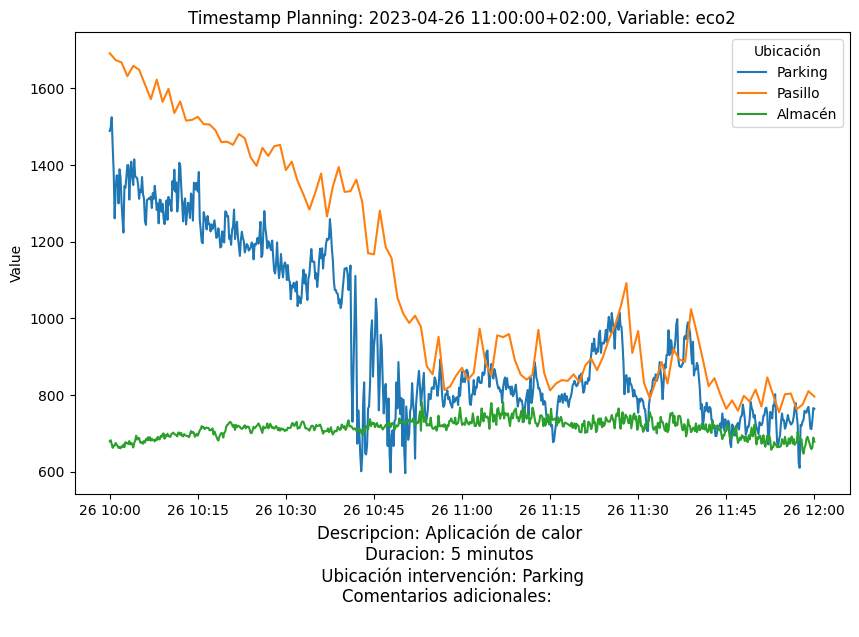

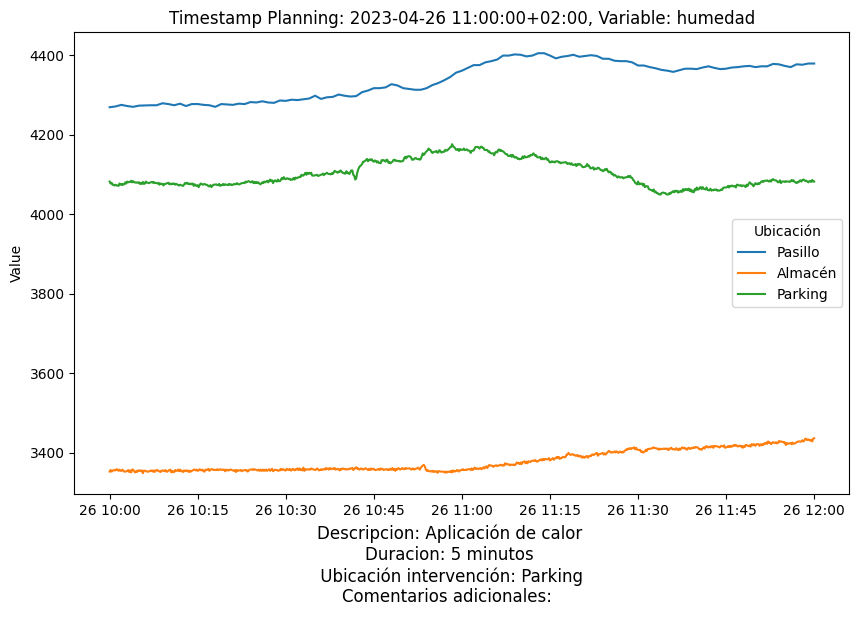

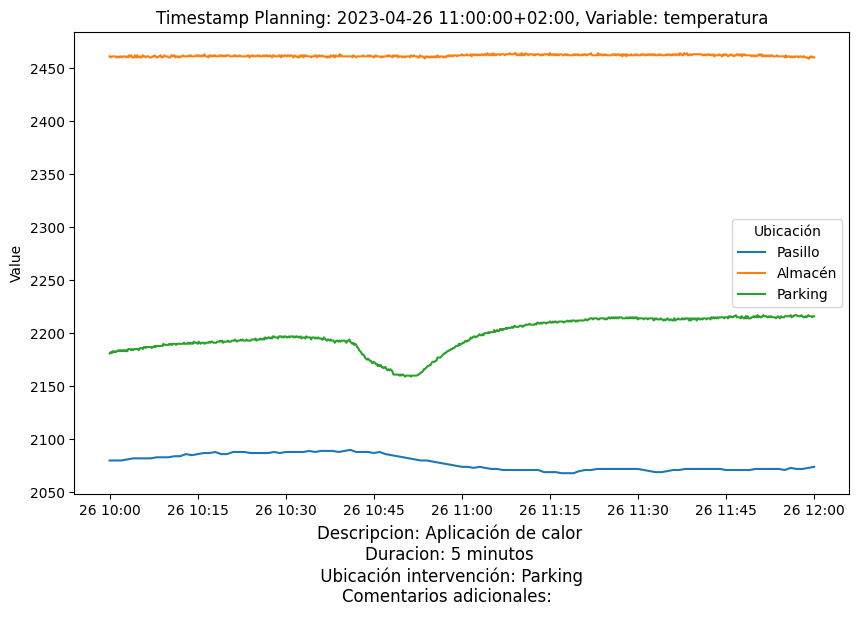

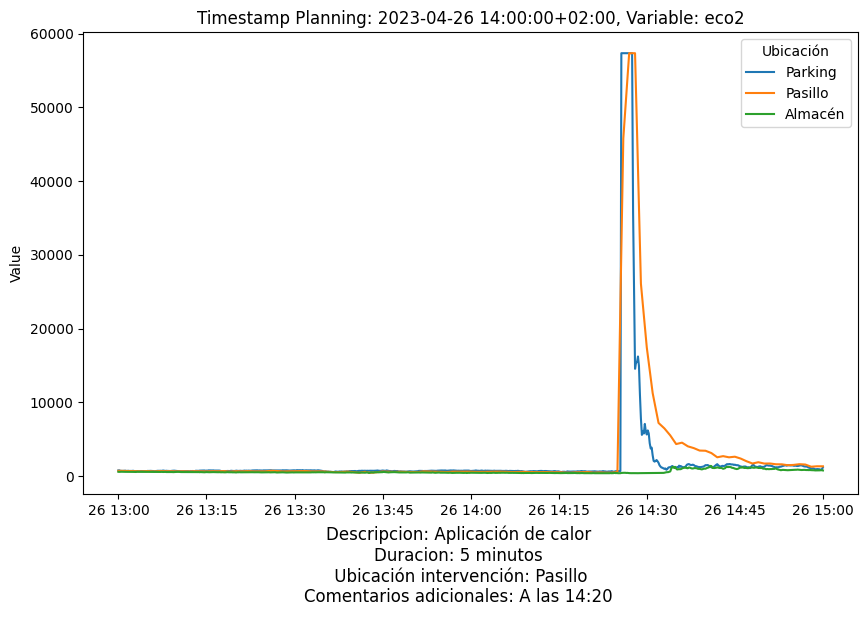

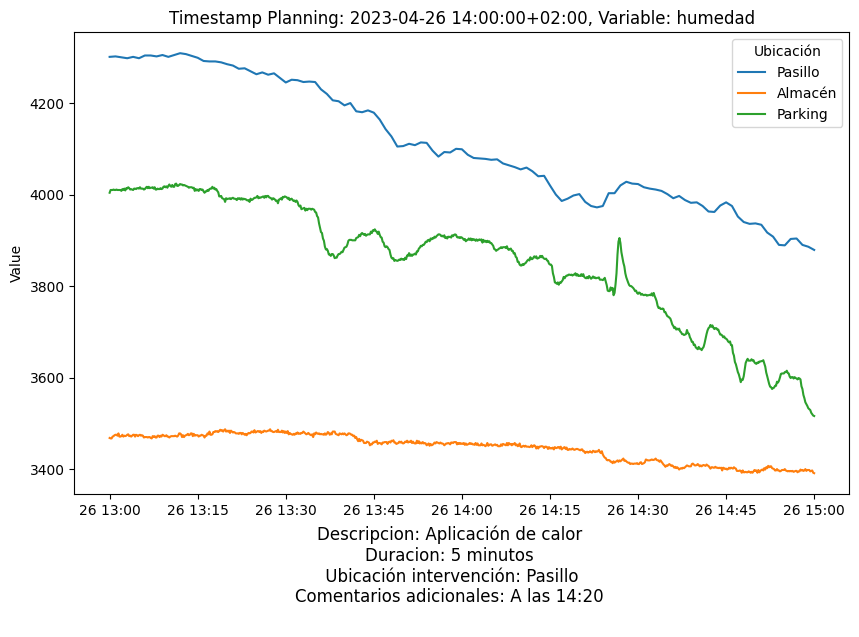

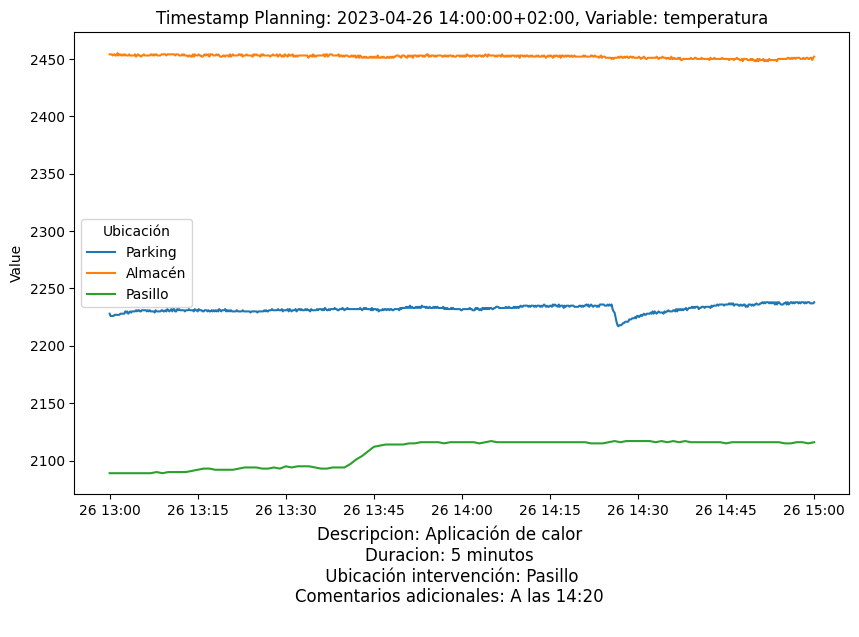

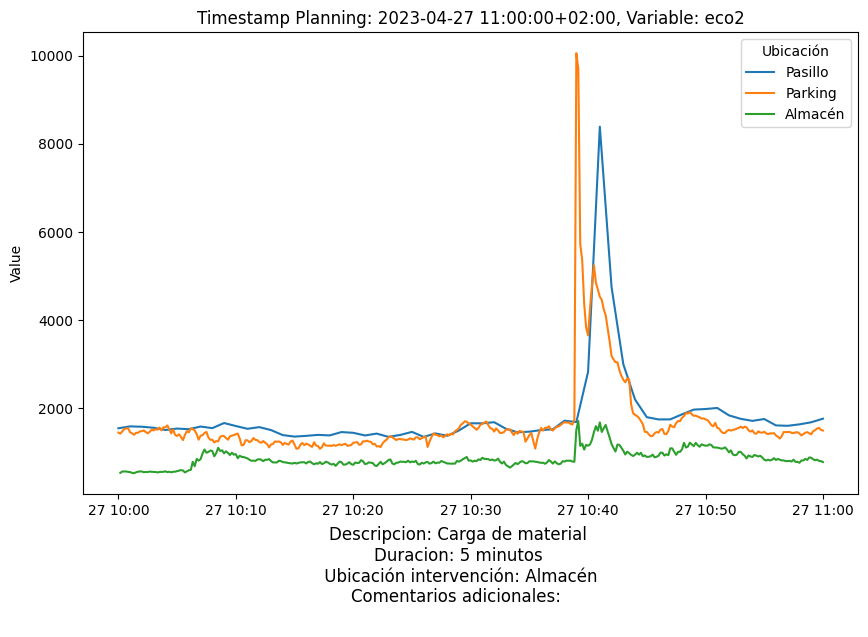

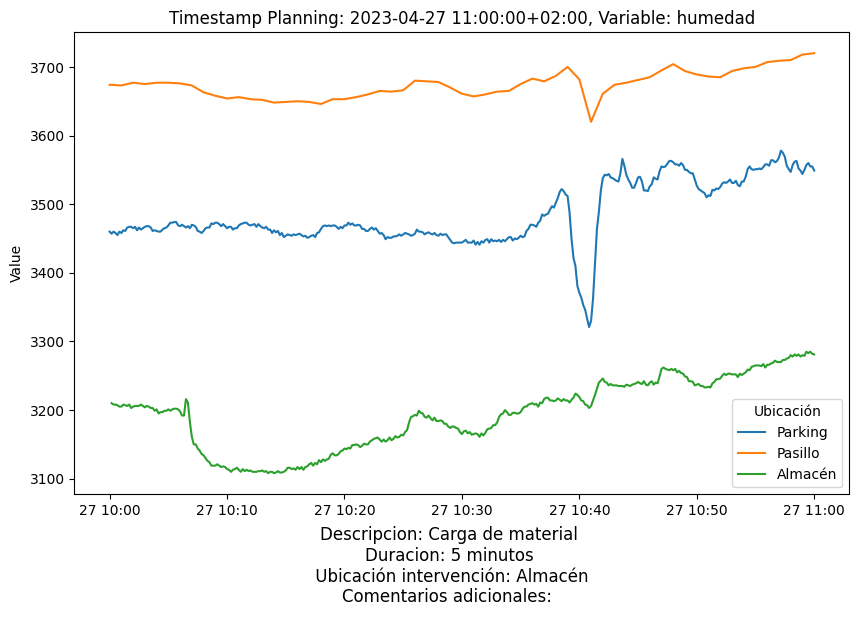

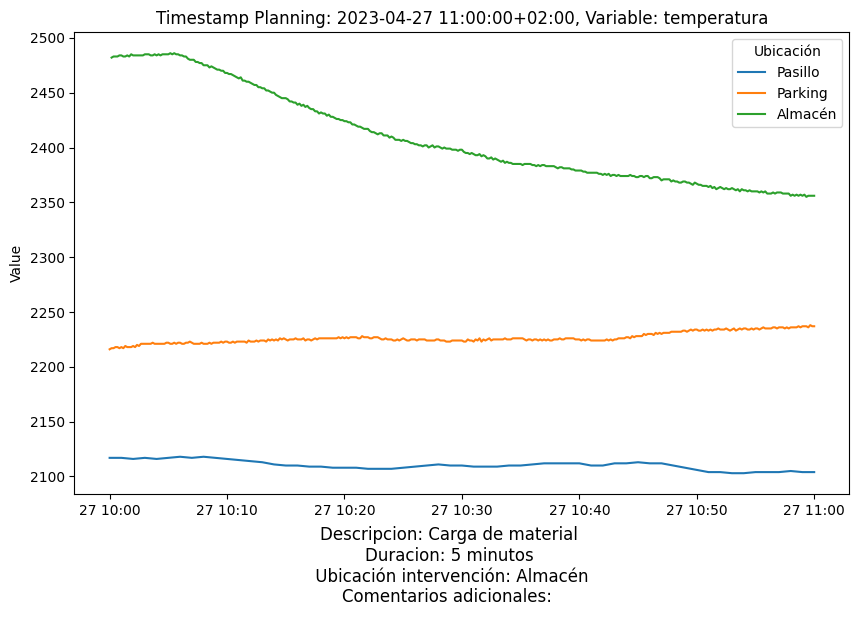

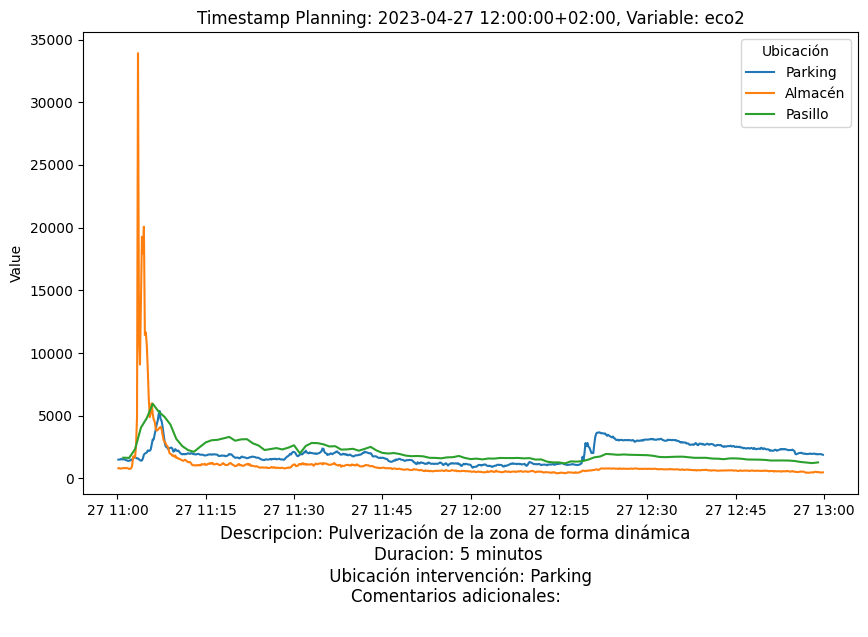

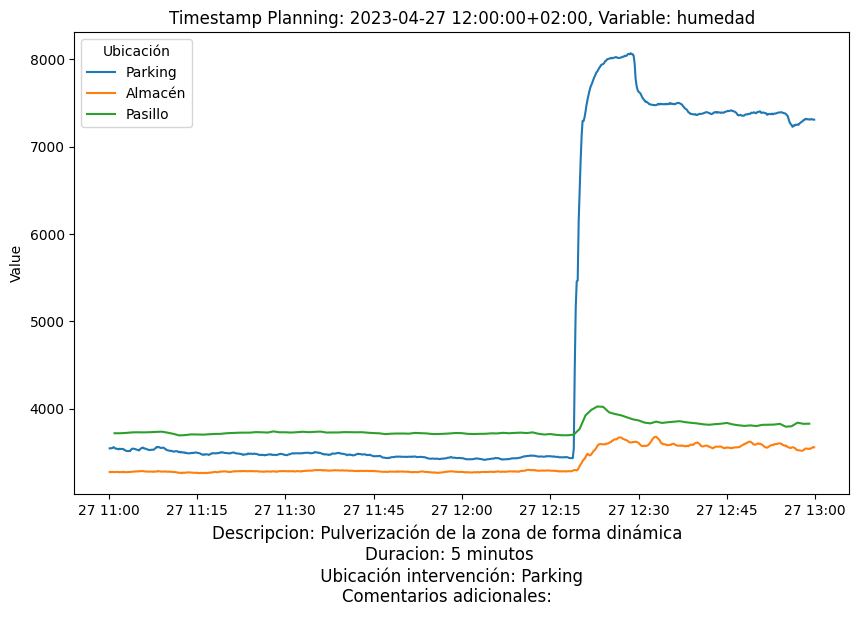

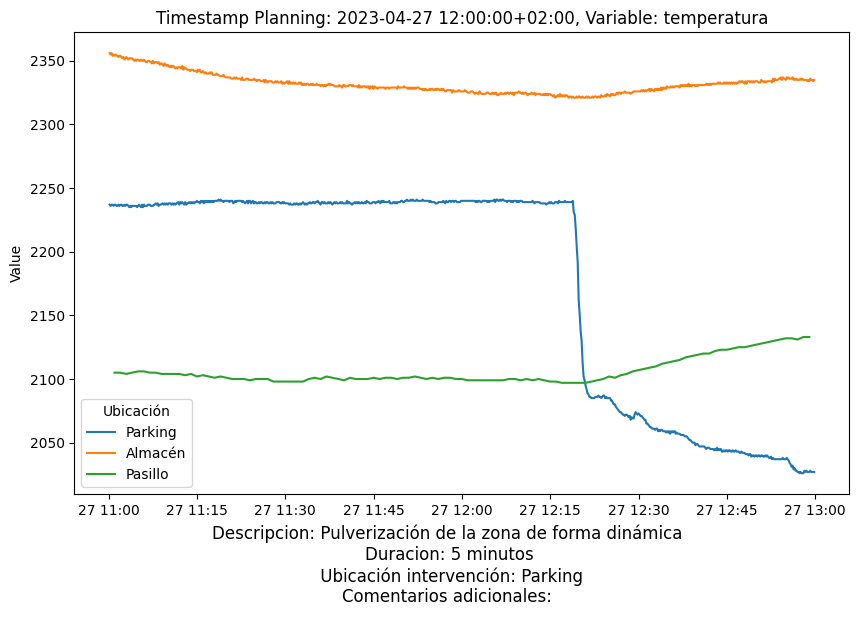

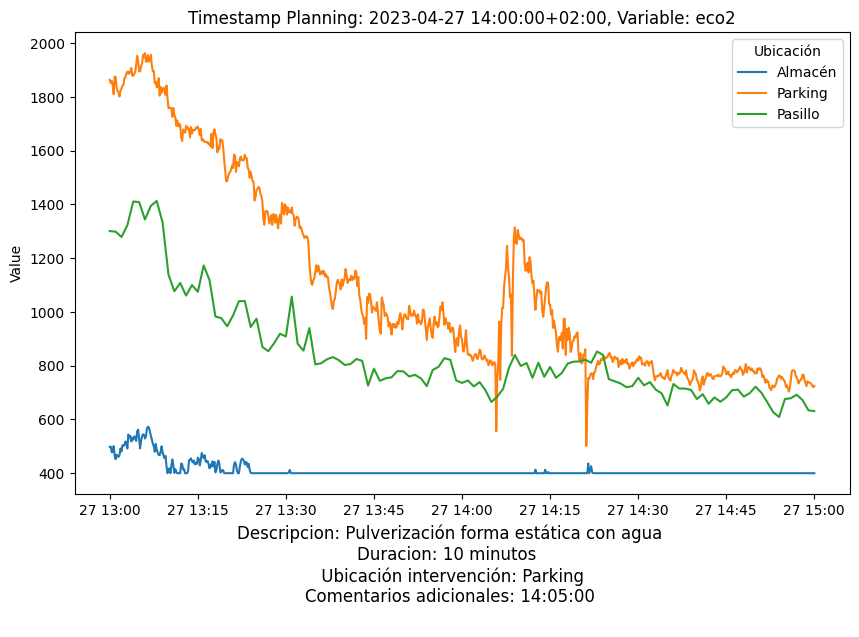

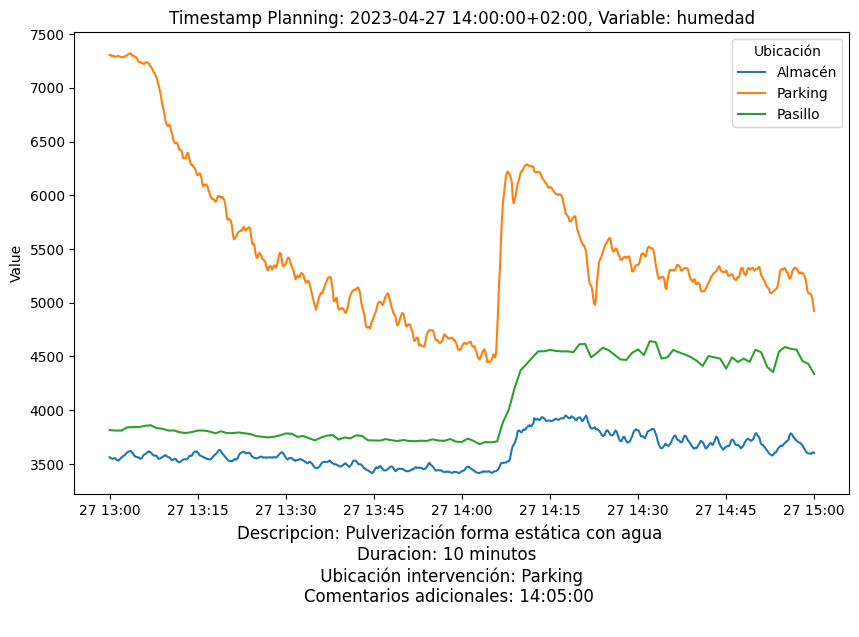

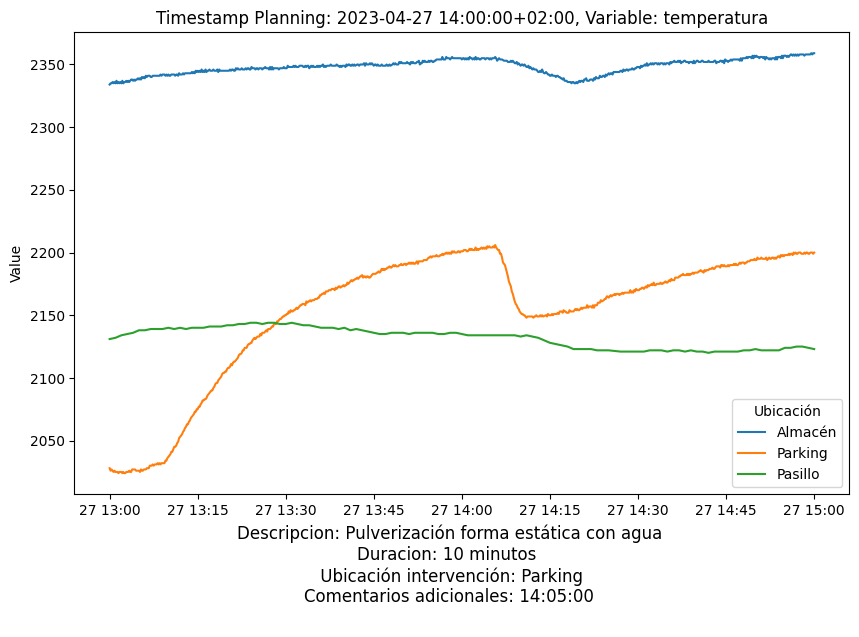

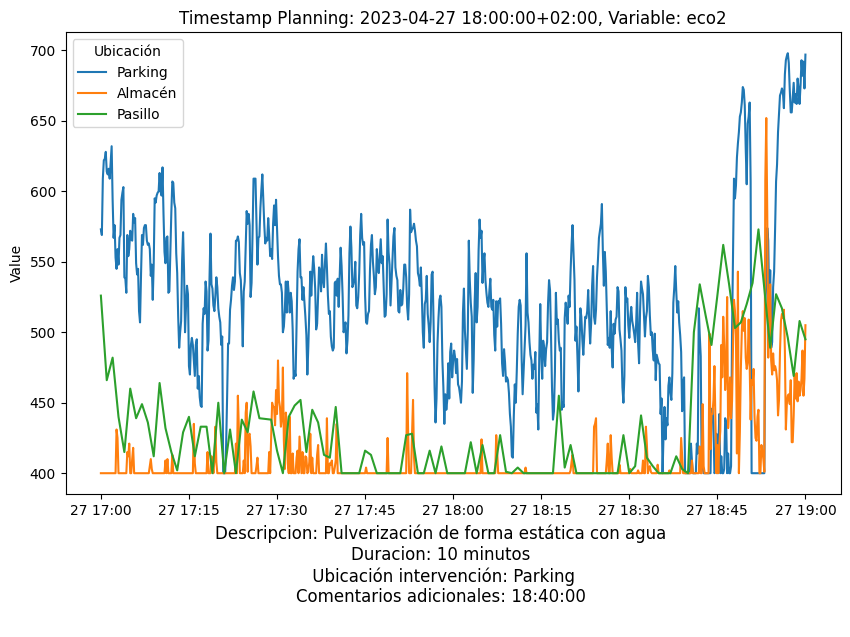

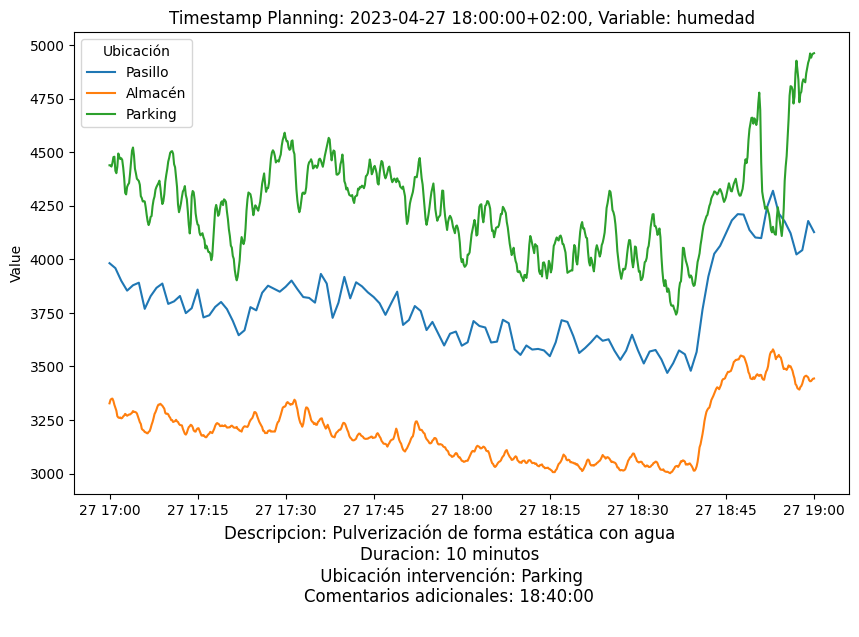

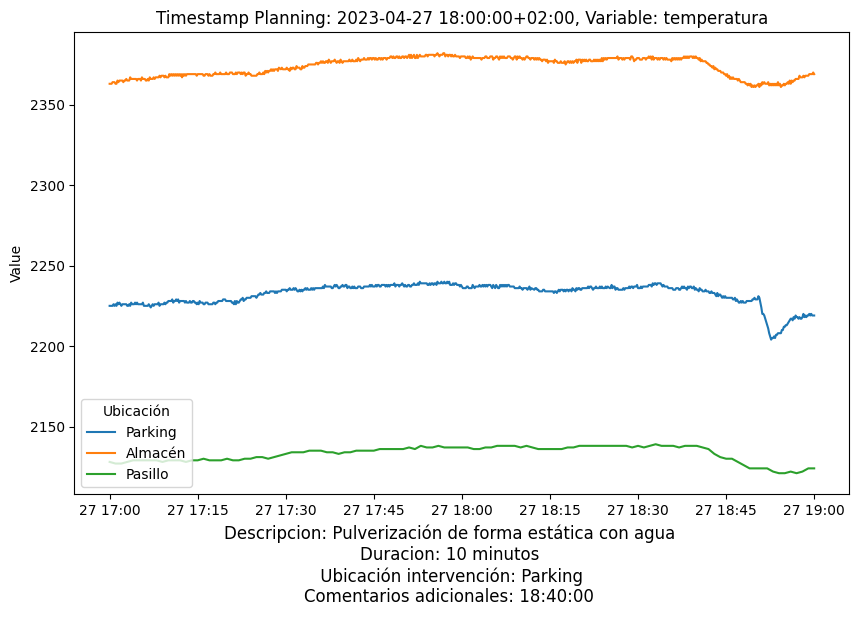

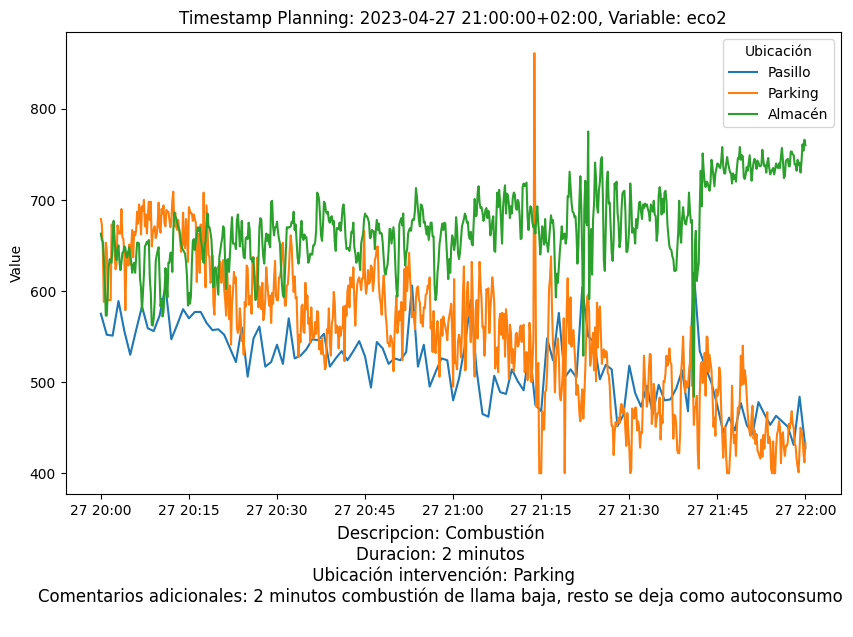

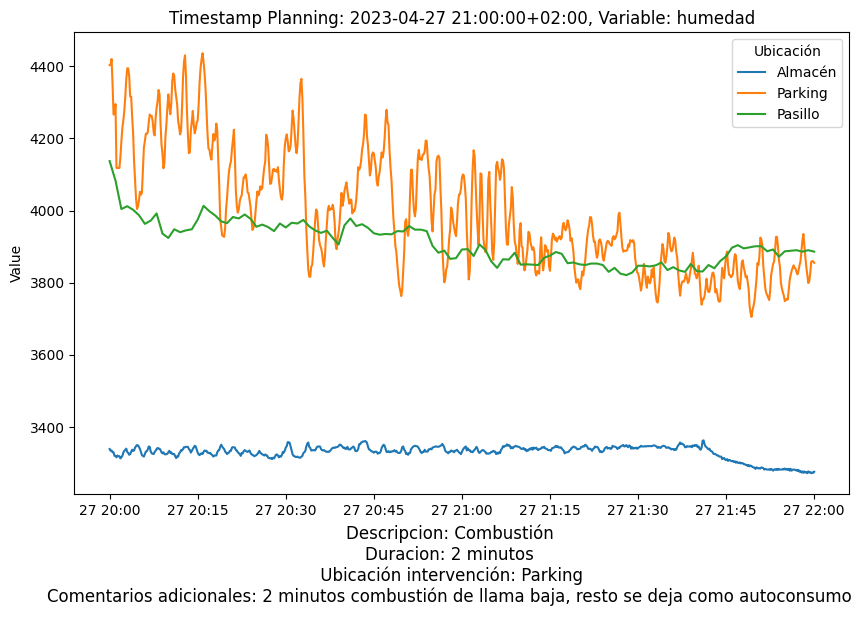

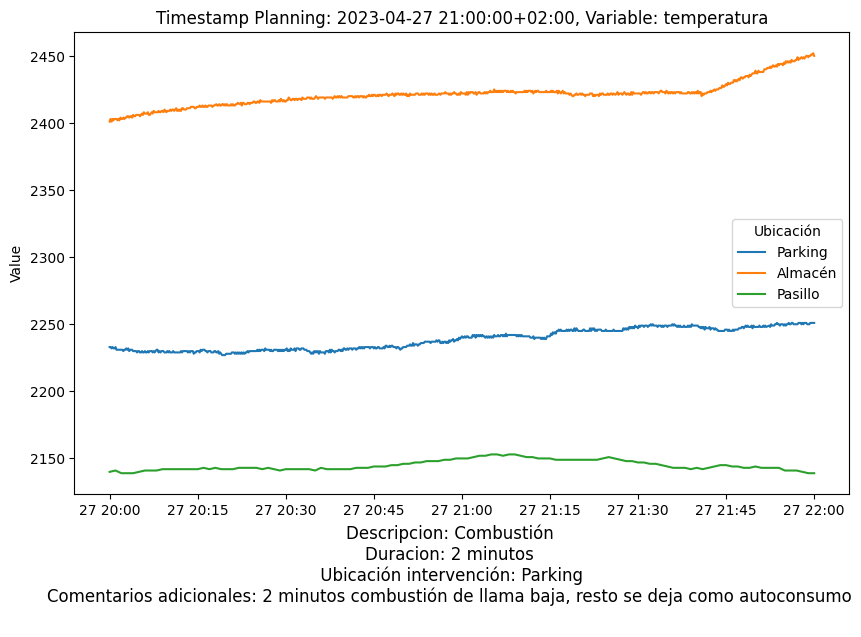

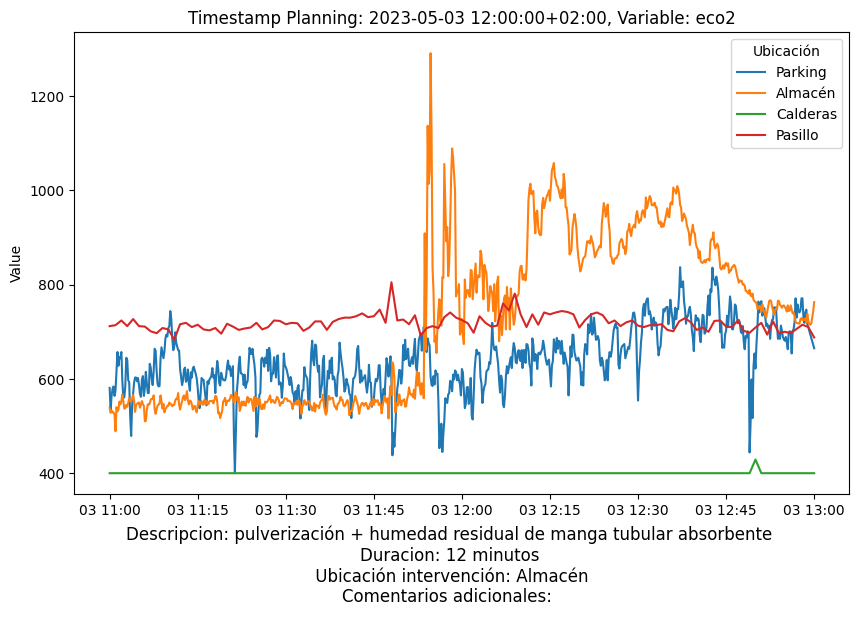

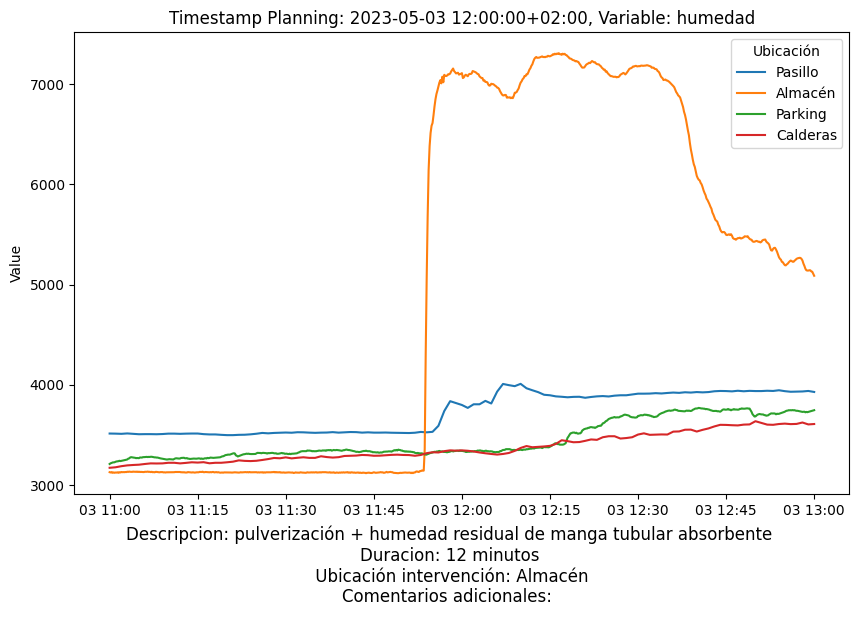

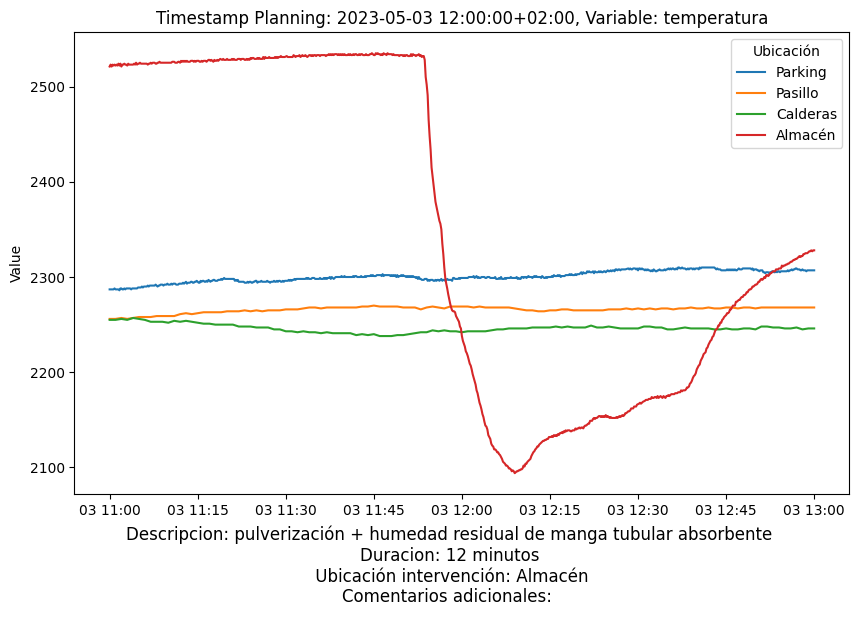

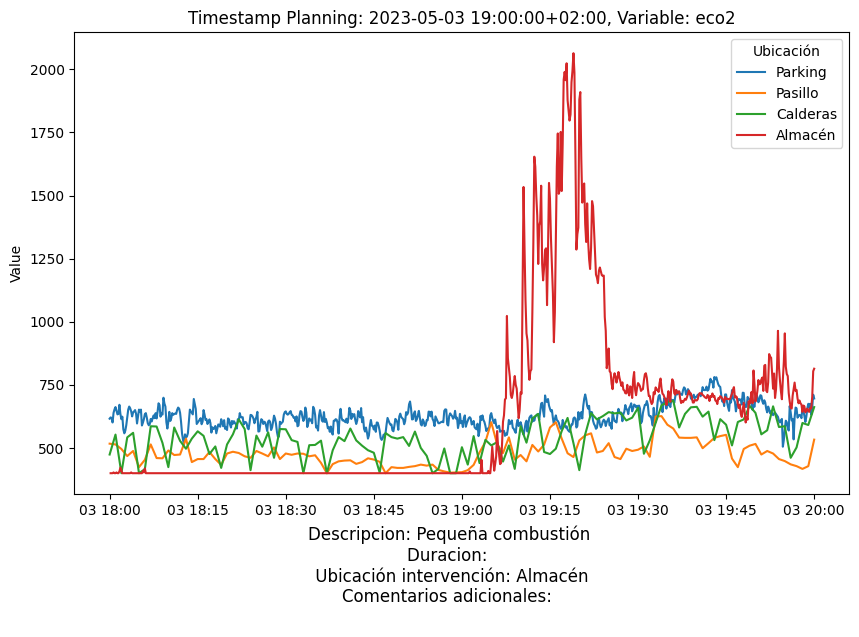

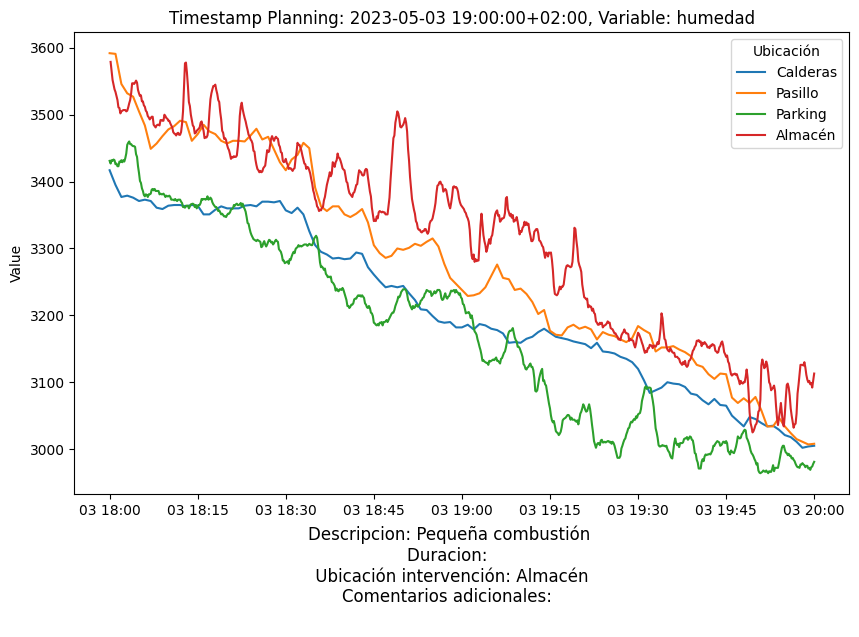

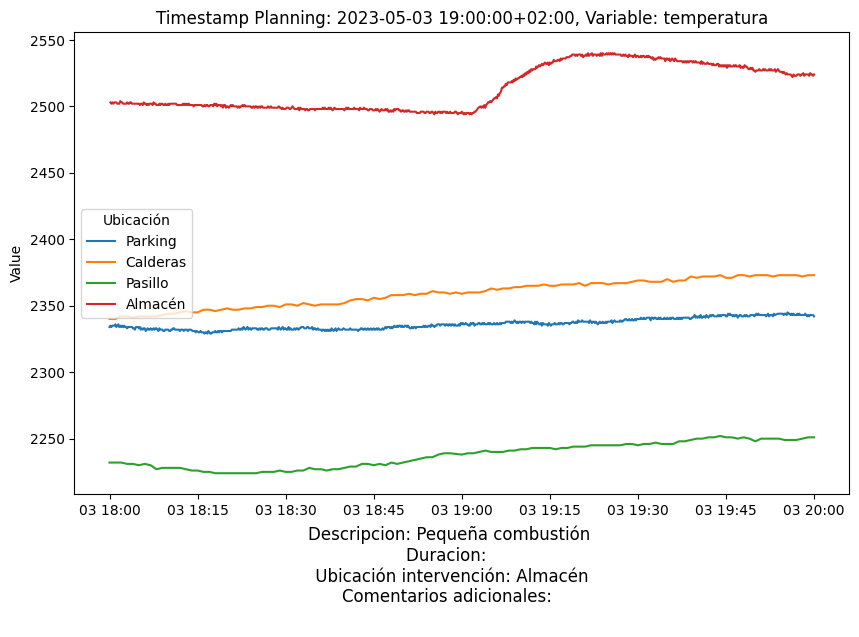

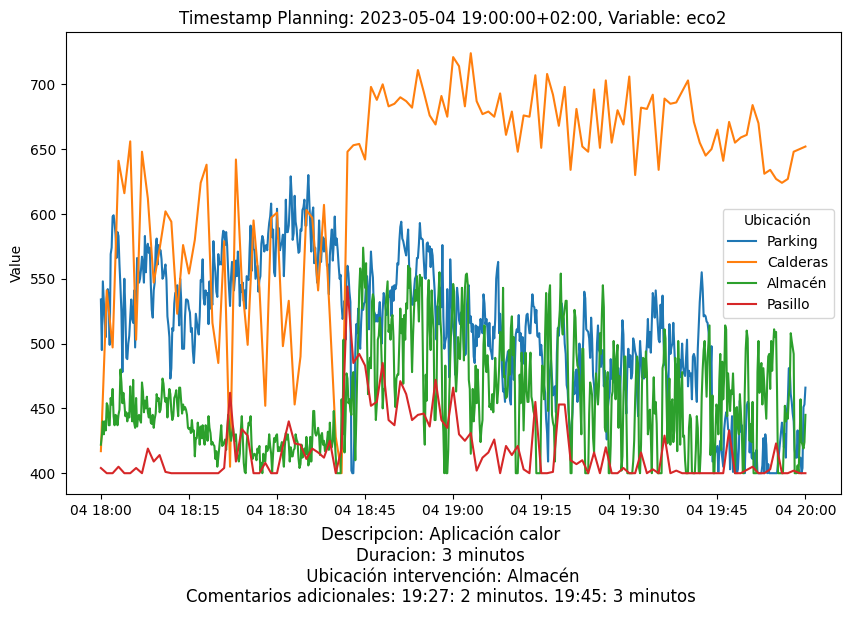

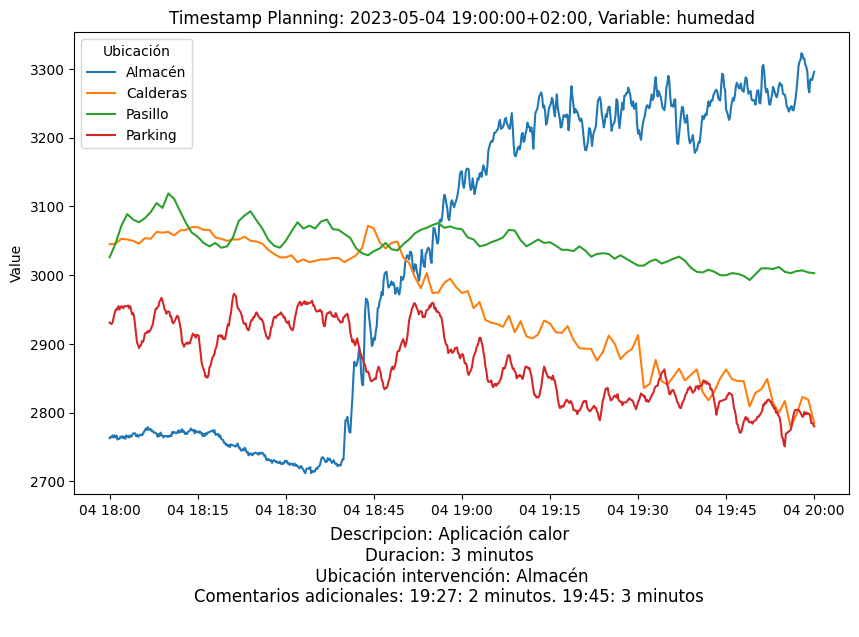

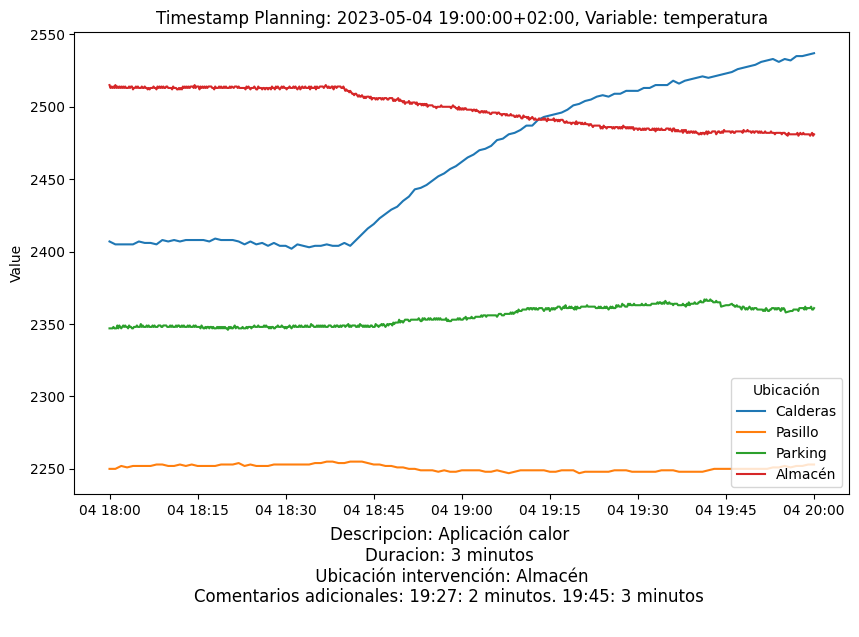

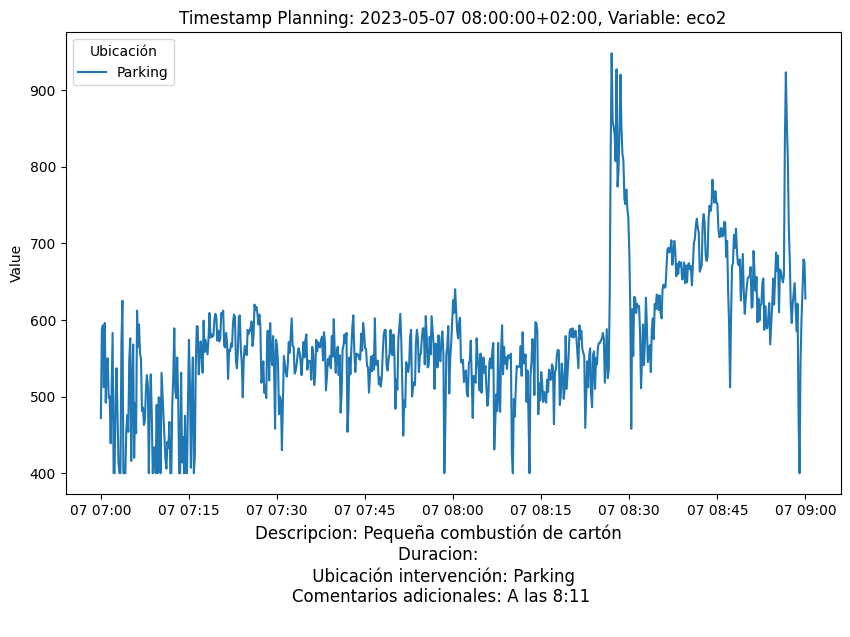

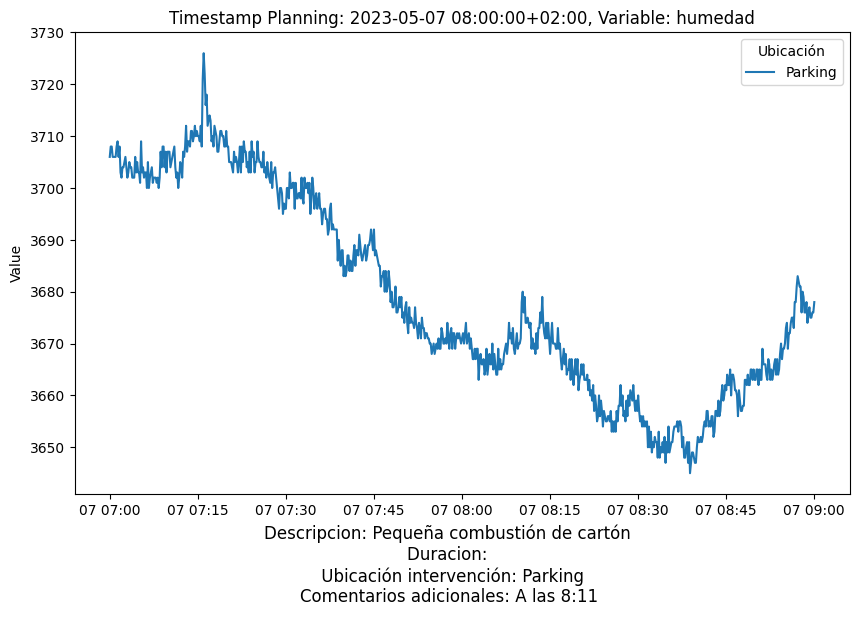

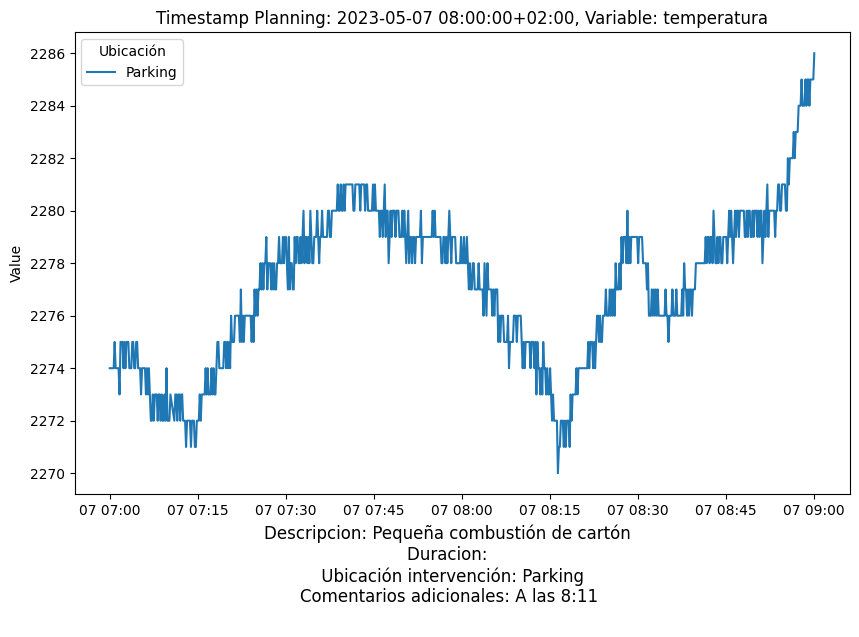

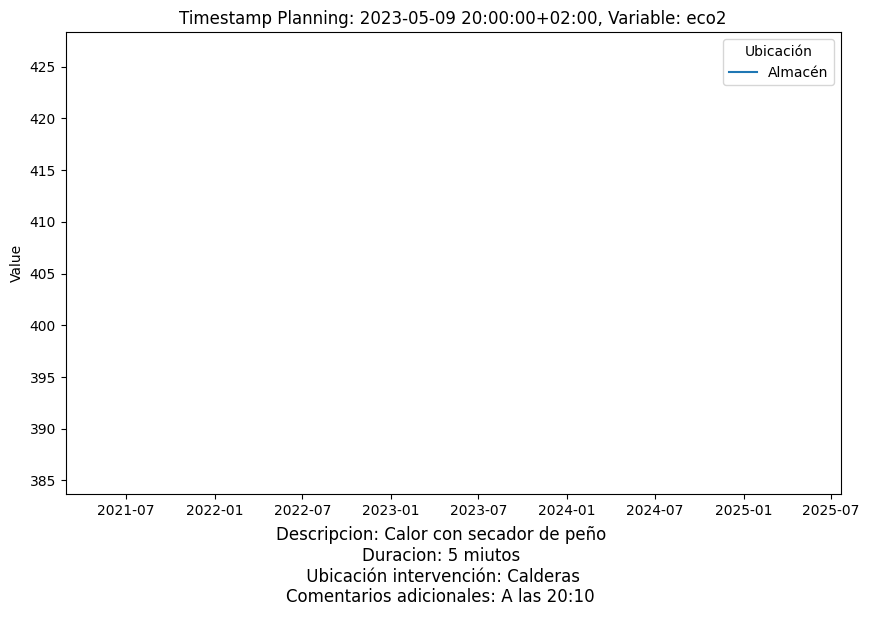

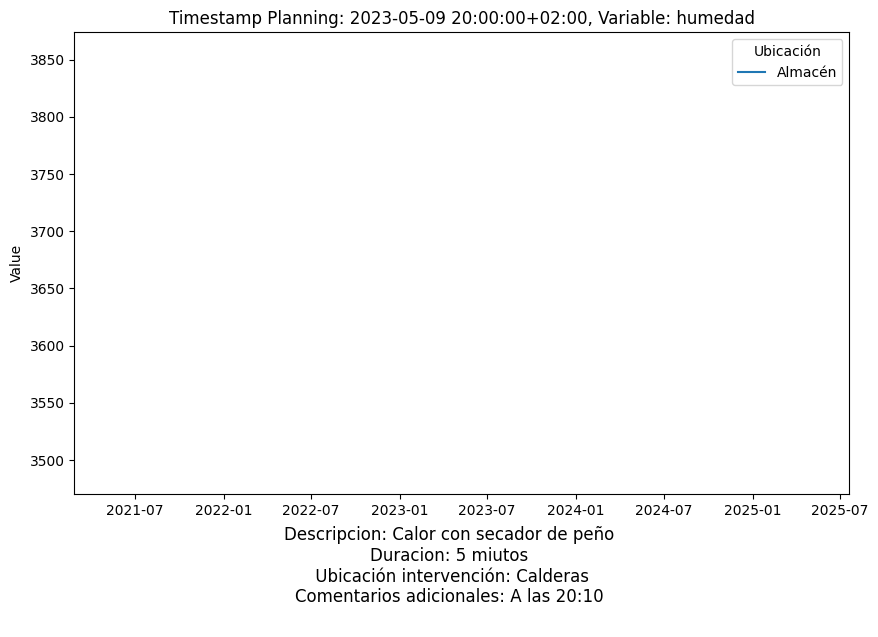

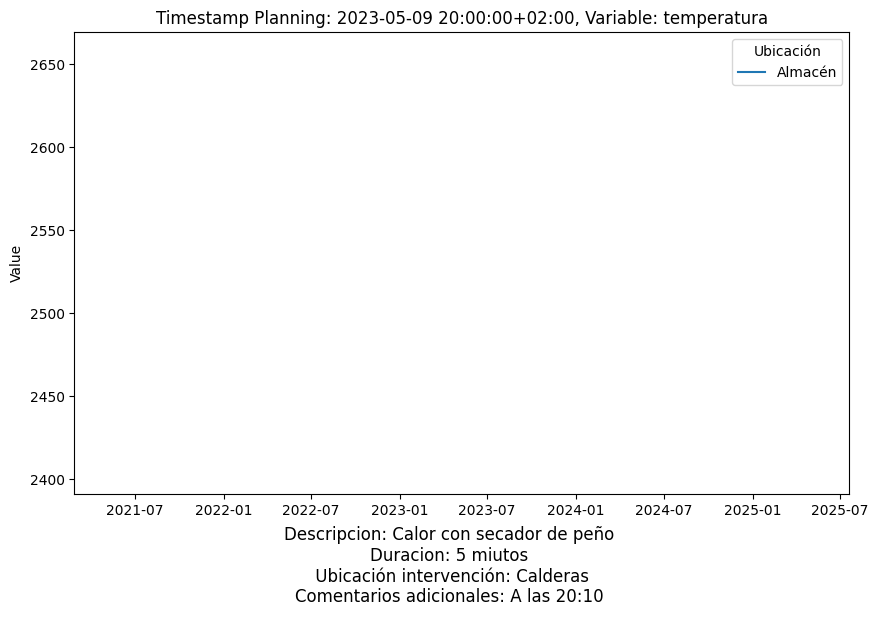

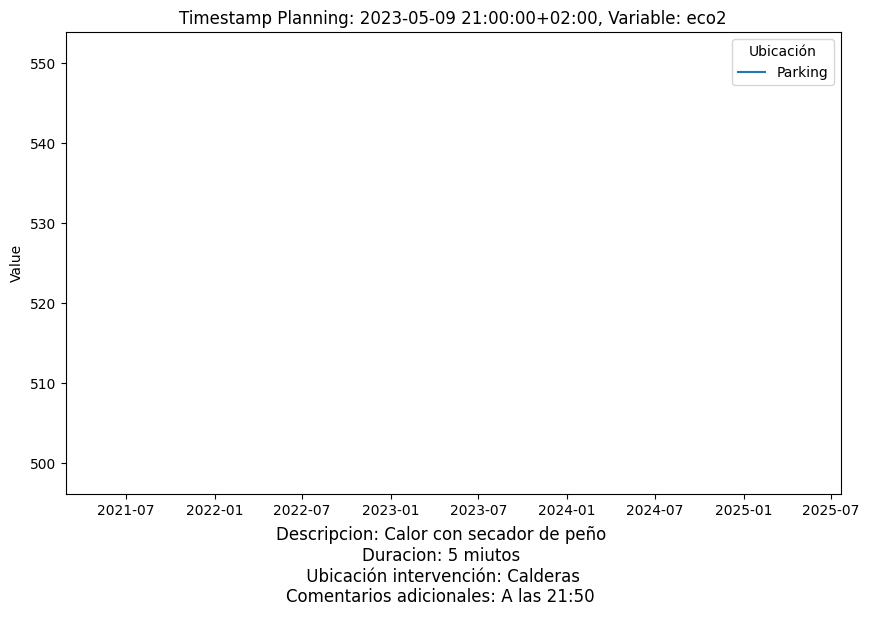

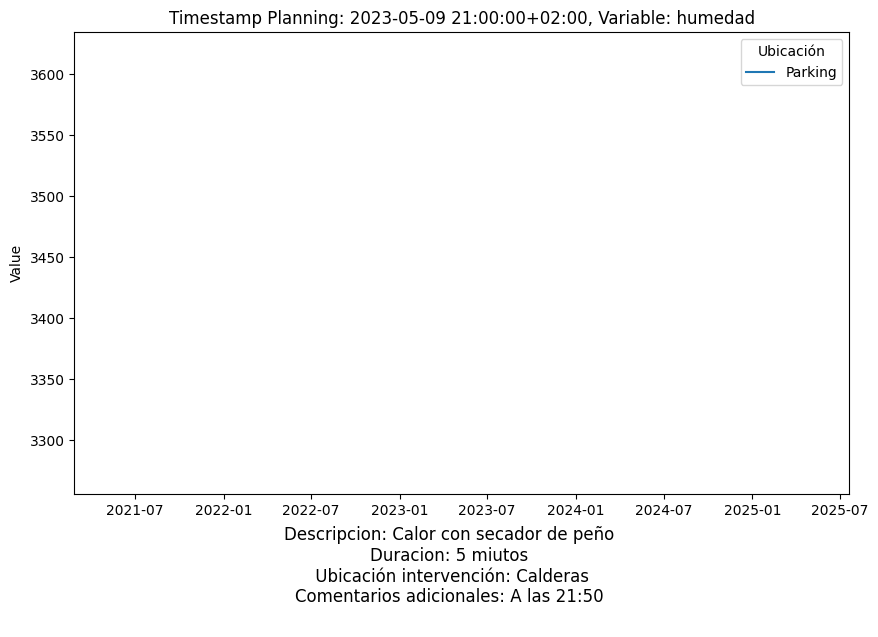

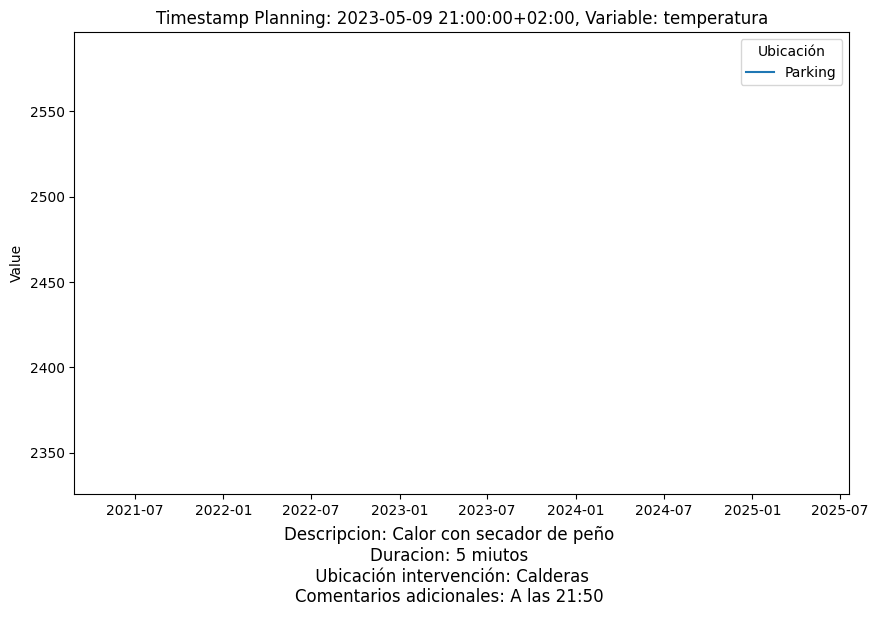

In [205]:
# Agrupa los datos por 'timestamp_planning' y 'variable'
variables_filtered = ["temperatura","humedad","eco2"]
grouped = df_including_interventions_only_hours_interventions\
.query("variable.isin(@variables_filtered)")\
.replace({"DBEM003":"Almacén","DBEM004":"Parking","DBEM006":"Calderas","DBEM007":"Pasillo"})\
.groupby(['timestamp_planning', 'variable'])

# Para cada grupo, crea una gráfica
for (timestamp_planning, variable), group in grouped:
    plt.figure(figsize=(10,6)) # Ajusta el tamaño del gráfico
    beacons = group['id_beacon'].unique()
    for beacon in beacons:
        beacon_data = group[group['id_beacon'] == beacon]
        plt.plot(beacon_data['timestamp'], beacon_data['value'], label=beacon)
    plt.title(f'Timestamp Planning: {timestamp_planning}, Variable: {variable}')
#     plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend(title='Ubicación')
    # Agrega una caption debajo del gráfico con los comentarios
    descripcion = "\n".join(group['descripcion'].astype(str).replace('nan', '').unique())
    duracion = "\n".join(group['duracion'].astype(str).replace('nan', '').unique())
    comentarios = "\n".join(group['comentarios adicionales'].astype(str).replace('nan', '').unique())
    ubicacion_intervencion = "\n".join(group['id_beacon_intervention'].astype(str).replace('nan', '').unique())
    
    plt.figtext(0.5, -0.1, f'\nDescripcion: {descripcion}\nDuracion: {duracion}\n Ubicación intervención: {ubicacion_intervencion}\nComentarios adicionales: {comentarios}\n', wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

In [211]:
df_interventions_filled.shape[0]

24

In [253]:
from docx import Document
from docx.shared import Inches

# Crea un nuevo documento de Word
doc = Document()

for i, timestamp in enumerate(timestamps_unique, start=1):
    fig, axs = plt.subplots(1, len(variables_filtered), figsize=(22, 8))  # Una fila, tantas columnas como variables
    for ax, variable in zip(axs, variables_filtered):
        data = grouped.get_group((timestamp, variable))
        beacons = data['id_beacon'].unique()
        for beacon in beacons:
            beacon_data = data[data['id_beacon'] == beacon]
            ax.plot(beacon_data['timestamp'], beacon_data['value'], label=beacon)
        ax.set_ylabel('Valor', fontweight='bold')
        ax.set_xlabel(f'{variable}', fontweight='bold', fontsize=15)  # Aumenta el tamaño de la fuente del eje X
        ax.legend(title='Ubicación')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('Europe/Madrid')))  # Aquí se formatea la fecha en el eje X

    descripcion = "\n".join(data['descripcion'].astype(str).replace('nan', '').unique())
    duracion = "\n".join(data['duracion'].astype(str).replace('nan', '').unique())
    comentarios = "\n".join(data['comentarios adicionales'].astype(str).replace('nan', '').unique())
    ubicacion_intervencion = "\n".join(data['id_beacon_intervention'].astype(str).replace('nan', '').unique())

    caption_text = f'\nDescripción intervención: {descripcion}\nHorario planeado:{timestamp}\nDuración: {duracion}\nUbicación intervención: {ubicacion_intervencion}\nComentarios adicionales: {comentarios}\n'

    plt.tight_layout()

    # Guarda la figura en un archivo
    fig.savefig('figure.png')
    
    # Añade un título antes de la figura
    doc.add_heading(f'Intervención {i}', level=1)
    
    # Añade un título antes de la figura
    doc.add_heading(f'Gráfica', level=2)
    # Inserta la figura en el documento de Word
    doc.add_picture('figure.png', width=Inches(6.0))

    doc.add_heading(f'Descripción de la intervención de los bomberos', level=2)
    # Añade el título después de la figura
    doc.add_paragraph(caption_text)
    
    doc.add_heading(f'Análisis', level=2)

    plt.close(fig)  # Cierra la figura para liberar memoria

# Guarda el documento de Word
doc.save('informe-intervenciones-imagenes.docx')


In [251]:
from docx import Document
from docx.shared import Inches

# Crea un nuevo documento de Word
doc = Document()

for i, timestamp in enumerate(timestamps_unique, start=1):
    fig, axs = plt.subplots(1, len(variables_filtered), figsize=(22, 8))  # Una fila, tantas columnas como variables
    for ax, variable in zip(axs, variables_filtered):
        data = grouped.get_group((timestamp, variable))
        beacons = data['id_beacon'].unique()
        for beacon in beacons:
            beacon_data = data[data['id_beacon'] == beacon]
            ax.plot(beacon_data['timestamp'], beacon_data['value'], label=beacon)
        ax.set_ylabel('Valor', fontweight='bold')
        ax.set_xlabel(f'{variable}', fontweight='bold')
        ax.legend(title='Ubicación')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('Europe/Madrid')))  # Aquí se formatea la fecha en el eje X

    descripcion = "\n".join(data['descripcion'].astype(str).replace('nan', '').unique())
    duracion = "\n".join(data['duracion'].astype(str).replace('nan', '').unique())
    comentarios = "\n".join(data['comentarios adicionales'].astype(str).replace('nan', '').unique())
    ubicacion_intervencion = "\n".join(data['id_beacon_intervention'].astype(str).replace('nan', '').unique())

    caption_text = f'\nDescripcion intervencion: {descripcion}\nHorario planeado:{timestamp}\nDuracion: {duracion}\nUbicación intervención: {ubicacion_intervencion}\nComentarios adicionales: {comentarios}\n'

    plt.tight_layout()

    # Guarda la figura en un archivo
    fig.savefig('figure.png')
    
    # Añade un título antes de la figura
    doc.add_heading(f'Intervención {i}', level=1)
    
    # Añade un título antes de la figura
    doc.add_heading(f'Gráfica', level=2)
    # Inserta la figura en el documento de Word
    doc.add_picture('figure.png', width=Inches(6.0))

    doc.add_heading(f'Descripción de la intervención de los bomberos', level=2)
    # Añade el título después de la figura
    doc.add_paragraph(caption_text)
    
    doc.add_heading(f'Análisis', level=2)

    plt.close(fig)  # Cierra la figura para liberar memoria

# Guarda el documento de Word
doc.save('informe-intervenciones-imagenes.docx')


In [200]:
stop

NameError: name 'stop' is not defined

In [ ]:
df.query("~descripcion.isna()")